In [3]:
%%capture
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import importlib as imp

from collections import namedtuple
from random import sample, shuffle
from functools import reduce
from itertools import accumulate
from math import floor, ceil, sqrt, log, pi
from tensorflow.keras import layers, utils, losses, models as mds, optimizers
from matplotlib import pyplot as plt

if imp.find_loader('aggdraw'): import aggdraw
if imp.find_loader('tensorflow_addons'): from tensorflow_addons import layers as tfa_layers

2022-04-07 13:20:35.826762: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-07 13:20:35.843358: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Summary

<style>
    .heatMap {
        width: 70%;
        text-align: center;
    }
    .heatMap th {
        background: grey;
        word-wrap: break-word;
        text-align: center;
    }
    /* .heatMap tr:nth-child(1) { background: red; } */
    /* .heatMap tr:nth-child(2) { background: orange; } */
    .heatMap tr:nth-child(13) { background: green; }
    .heatMap tr:nth-child(25) { background: green; }
    .heatMap tr:nth-child(26) { background: green; }

</style>

<div class="heatMap">

| Version | Depth | Skips | Others | Accuracy | Validation Accuracy |
| :-- | :-: | :-- | :-- | :-: | :-: |
| 3 | 20 | [2, 3, 5, 8] || 0.134314  |  0.103922 |
| 5 | 30 | [2, 3, 5, 8, 13, 21] | heat=1, chill=3, skip_start_depth=10 | 0.240196 | 0.137255 |
| 6 | 60 | [2, 3, 5, 8, 13, 21] | heat=1, chill=2, reheat=7, skip_start_depth=10 | 0.036275 | 0.037255 |
| 7 | 30 | [2, 3, 5, 8, 13, 21] || 0.134314 | 0.094118 |
| 8 | 30 | [2, 3, 5, 8, 13, 21] || 0.041176 | 0.035294 |
| 10 | 20 | [2, 3, 5, 8, 13] || 0.182353 | 0.083333 |
| 11 | 30 | [2, 3, 5, 8, 13, 21] | Conv Merge | 0.079412 | 0.055882 |
| 12 | 30 | [2, 3, 5, 8, 13, 21] | Dense Merge | 0.185294 | 0.089216 |
| 13 | 30 | [2, 3, 5, 8, 13] || 0.131373 | 0.098039 |
| 21 | 4 |[]|| 0.976471 | 0.32549 |
| 22 | 4 | [3] | skip_start_depth=2 | 0.896078 | 0.19902 |
| 23 | 4 | [3] | Conv Regularization, skip_start_depth=2 | 0.42451 | 0.130392 |
| 24 | 4 | [] | Basic Augmentations | 0.890196 | 0.469608 |
| 25 | 4 | [] | RandAugment | 0.513726 | 0.45098 |
| 26 | 4 | [] | AutoAugment | 0.872549 | 0.451961 |
| 27 | 4 | [] | Basic Augmentations, SpatialDropout | 0.641176 | 0.37549 |
| 28 | 4 | [] | Basic Augmentations, SpatialDropout, PReLU | 0.729412 | 0.401961 |
| 32 | 4 | [] | MixUp | 0.995098 | 0.214706 |
| 33 | 4 | [] | MixUp, Basic Augmentations | 0.95 | 0.431373 |
| 36 | 4 | [] | Basic Augmentations, SpatialDropout(r) for Conv layers | 0.909804 | 0.437255 |
| 37 | 4 | [] | Basic Augmentations, SpatialDropout(r) for Conv layers, PReLU | 0.934314 | 0.42451 |
| 39 | 4 | [] | Basic Augmentations, SpatialDropout(r) for Conv layers, SEBlock | 0.911765 | 0.429412 |
| 40 | 4 | [] | heat=1, chill=1, Basic Augmentations, SpatialDropout(r) | 0.987255 | 0.372549 |
| 41 | 4 | [] | heat=1, chill=1, Basic Augmentations, SpatialDropout(r), MaxPool(2) after all convs | 0.952941 | 0.42549 |
| 43 | 2x4 | [] | heat=1, chill=1, Basic Augmentations, SpatialDropout(r), MaxPool(2) after all convs | 0.978431 | 0.471569 |
| 44 | 2x4 | [] | heat=1, chill=1, Basic Augmentations, SpatialDropout(r), MaxPool(2) after all convs, lr=0.00088 based on random search | 0.977451 | 0.472549 |

</div>


* Versions correspond to the kaggle [runs](https://www.kaggle.com/naresh/auto-model)
* Chill is non-impactful in shallow networks. Dimensionality reduction using Strides (Conv and MaxPool) helps.
* Smaller the spatial dimensions in the feature vector, better the accuracy. Model head likes smaller parameter set to choose from.

## Common Functions

In [4]:
def plot_history(h):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), facecolor='w', edgecolor='k')

    axes[0].plot(h['loss'], label='Loss')
    axes[0].plot(h['val_loss'], label='Validation Loss')

    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Losses')

    axes[1].plot(h['accuracy'], label='Accuracy')
    axes[1].plot(h['val_accuracy'], label='Validation Accuracy')

    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracies')

    fig.legend()

def run_summary(h):
    plot_history(h)
    print(max(h['accuracy']), '|', max(h['val_accuracy']))

## Model 3 (depth=20, skips=[2, 3, 5, 8])

0.134314  |  0.103922


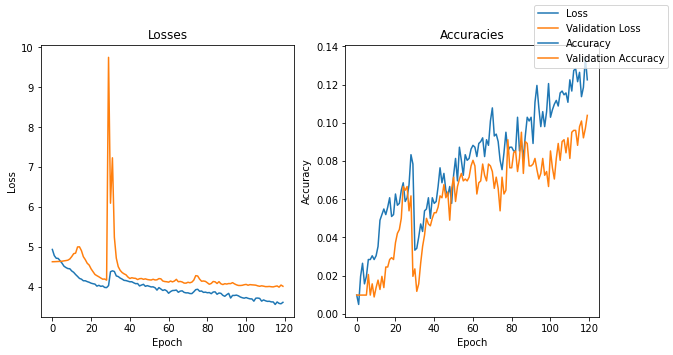

In [13]:
history = {'loss': [4.933203, 4.778612, 4.712742, 4.708459, 4.648549, 4.588217, 4.513692, 4.480162, 4.454505, 4.449397, 4.394504, 4.359779, 4.304623, 4.257103, 4.206994, 4.188591, 4.148404, 4.148549, 4.126994, 4.11091, 4.087538, 4.07413, 4.06407, 4.013563, 4.034152, 4.008312, 4.018239, 3.981055, 3.976682, 4.026988, 4.375055, 4.397504, 4.38144, 4.269544, 4.253957, 4.215819, 4.1906, 4.158627, 4.153378, 4.138384, 4.122829, 4.123641, 4.097038, 4.074889, 4.078626, 4.018622, 4.040771, 4.059194, 4.009147, 4.025974, 4.009773, 3.993738, 3.996207, 3.972915, 3.913933, 3.976903, 3.942168, 3.905067, 3.923758, 3.89599, 3.835392, 3.87707, 3.903397, 3.906101, 3.915708, 3.859696, 3.888864, 3.895969, 3.857346, 3.845021, 3.846014, 3.828249, 3.826698, 3.871985, 3.925412, 3.935275, 3.884717, 3.892021, 3.856905, 3.863206, 3.848062, 3.853007, 3.824827, 3.866418, 3.870789, 3.809691, 3.841761, 3.832773, 3.783296, 3.758727, 3.800392, 3.832429, 3.715098, 3.781051, 3.779994, 3.788924, 3.770988, 3.741774, 3.723493, 3.711463, 3.727117, 3.708482, 3.695006, 3.693289, 3.636789, 3.711948, 3.715095, 3.705999, 3.637983, 3.668371, 3.646361, 3.631687, 3.634435, 3.618837, 3.617585, 3.554697, 3.616818, 3.580964, 3.571679, 3.607831], 'accuracy': [0.009804, 0.004902, 0.019608, 0.026471, 0.015686, 0.019608, 0.028431, 0.028431, 0.030392, 0.028431, 0.030392, 0.035294, 0.04902, 0.051961, 0.054902, 0.051961, 0.055882, 0.060784, 0.05098, 0.051961, 0.062745, 0.056863, 0.057843, 0.064706, 0.068627, 0.058824, 0.060784, 0.067647, 0.083333, 0.078431, 0.033333, 0.034314, 0.040196, 0.047059, 0.043137, 0.053922, 0.054902, 0.060784, 0.05, 0.060784, 0.057843, 0.058824, 0.066667, 0.076471, 0.068627, 0.073529, 0.064706, 0.061765, 0.066667, 0.057843, 0.072549, 0.081373, 0.069608, 0.087255, 0.080392, 0.072549, 0.083333, 0.080392, 0.081373, 0.086275, 0.088235, 0.087255, 0.082353, 0.089216, 0.090196, 0.092157, 0.082353, 0.091176, 0.088235, 0.10098, 0.107843, 0.093137, 0.094118, 0.090196, 0.080392, 0.07549, 0.084314, 0.095098, 0.085294, 0.087255, 0.087255, 0.085294, 0.085294, 0.102941, 0.085294, 0.090196, 0.081373, 0.093137, 0.102941, 0.10098, 0.102941, 0.089216, 0.110784, 0.119608, 0.107843, 0.098039, 0.105882, 0.098039, 0.105882, 0.120588, 0.102941, 0.106863, 0.109804, 0.111765, 0.108824, 0.115686, 0.116667, 0.114706, 0.115686, 0.110784, 0.122549, 0.116667, 0.127451, 0.128431, 0.121569, 0.126471, 0.113725, 0.118627, 0.134314, 0.122549], 'val_loss': [4.62539, 4.62667, 4.629114, 4.631567, 4.634011, 4.638593, 4.647288, 4.654223, 4.66458, 4.693739, 4.75419, 4.82733, 4.840985, 4.996055, 4.998963, 4.904411, 4.752005, 4.677692, 4.587276, 4.541486, 4.446252, 4.37524, 4.306014, 4.275507, 4.24798, 4.216964, 4.18828, 4.192066, 4.163744, 9.749428, 6.092951, 7.23126, 5.240884, 4.715438, 4.50229, 4.409367, 4.355366, 4.322562, 4.297664, 4.242298, 4.204638, 4.224226, 4.21281, 4.208085, 4.178112, 4.200573, 4.204943, 4.184776, 4.19652, 4.180181, 4.172164, 4.16689, 4.18571, 4.168423, 4.172199, 4.203022, 4.197083, 4.142873, 4.12869, 4.12424, 4.113154, 4.141653, 4.1207, 4.142071, 4.184143, 4.12376, 4.131168, 4.118142, 4.090275, 4.089031, 4.110732, 4.098159, 4.114439, 4.164806, 4.276163, 4.268165, 4.189748, 4.136752, 4.142606, 4.132891, 4.098209, 4.060516, 4.081059, 4.130078, 4.121747, 4.080022, 4.126055, 4.071929, 4.053438, 4.074533, 4.065908, 4.078722, 4.076477, 4.101745, 4.070296, 4.046974, 4.031009, 4.029749, 4.034566, 4.048853, 4.05707, 4.036119, 4.051802, 4.045996, 4.042667, 4.037658, 4.020865, 4.010103, 4.022012, 4.013093, 4.001687, 4.001912, 4.006242, 3.998025, 3.994699, 4.008087, 4.018971, 3.987945, 4.041105, 4.010334], 'val_accuracy': [0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.020588, 0.009804, 0.015686, 0.008824, 0.013725, 0.017647, 0.012745, 0.019608, 0.013725, 0.02451, 0.02451, 0.028431, 0.029412, 0.028431, 0.037255, 0.042157, 0.044118, 0.05, 0.066667, 0.064706, 0.066667, 0.053922, 0.061765, 0.019608, 0.023529, 0.011765, 0.015686, 0.026471, 0.035294, 0.041176, 0.05, 0.047059, 0.046078, 0.05, 0.052941, 0.052941, 0.055882, 0.061765, 0.060784, 0.067647, 0.060784, 0.063725, 0.04902, 0.065686, 0.071569, 0.058824, 0.066667, 0.070588, 0.073529, 0.069608, 0.070588, 0.069608, 0.071569, 0.077451, 0.080392, 0.077451, 0.062745, 0.068627, 0.069608, 0.078431, 0.072549, 0.069608, 0.078431, 0.077451, 0.07451, 0.065686, 0.071569, 0.065686, 0.053922, 0.071569, 0.062745, 0.064706, 0.091176, 0.076471, 0.076471, 0.084314, 0.085294, 0.07451, 0.081373, 0.095098, 0.073529, 0.090196, 0.089216, 0.077451, 0.077451, 0.078431, 0.081373, 0.07549, 0.070588, 0.073529, 0.081373, 0.072549, 0.07451, 0.066667, 0.085294, 0.076471, 0.070588, 0.081373, 0.089216, 0.080392, 0.090196, 0.091176, 0.084314, 0.092157, 0.081373, 0.095098, 0.096078, 0.096078, 0.088235, 0.098039, 0.10098, 0.092157, 0.097059, 0.103922]}

plot_history(history)
print(max(history['accuracy']), ' | ', max(history['val_accuracy']))

## Model 5 (depth=30, skips=[2, 3, 5, 8, 13, 21], heat=1, chill=3, skip_start_depth=10)

0.240196  |  0.137255


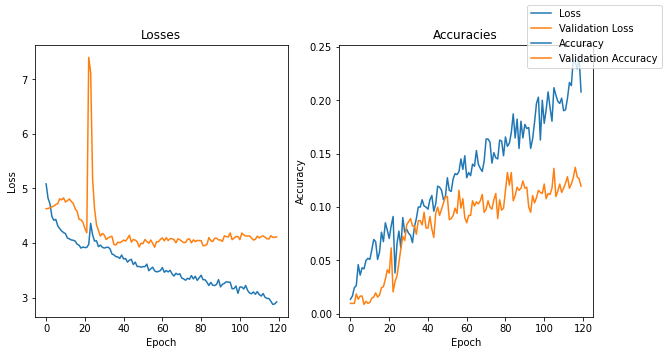

In [14]:
history = {'loss': [5.08202, 4.819621, 4.716983, 4.483245, 4.416396, 4.432909, 4.315057, 4.263754, 4.220068, 4.191669, 4.171094, 4.091025, 4.074702, 4.056173, 4.049688, 4.035142, 3.979259, 3.958887, 3.906689, 3.927642, 3.916417, 3.919084, 3.975762, 4.359375, 4.149557, 4.034146, 4.041173, 3.933278, 3.961383, 3.922744, 3.906954, 3.918675, 3.924459, 3.892485, 3.798182, 3.783285, 3.750587, 3.745043, 3.71676, 3.780182, 3.708059, 3.715294, 3.65002, 3.686789, 3.700323, 3.605301, 3.650727, 3.569188, 3.569695, 3.557832, 3.567948, 3.56724, 3.612507, 3.491871, 3.528569, 3.556596, 3.491038, 3.471278, 3.479214, 3.495702, 3.550088, 3.464159, 3.495129, 3.470653, 3.499215, 3.435348, 3.394361, 3.446206, 3.420403, 3.437433, 3.357577, 3.342773, 3.318233, 3.354416, 3.336018, 3.404278, 3.342278, 3.39087, 3.315174, 3.36144, 3.409714, 3.328965, 3.32656, 3.282478, 3.222616, 3.278791, 3.225756, 3.221463, 3.242636, 3.329258, 3.196331, 3.243092, 3.26086, 3.290672, 3.28424, 3.28024, 3.162009, 3.16485, 3.212407, 3.078687, 3.195147, 3.194067, 3.158886, 3.221695, 3.132141, 3.084609, 3.070798, 3.10358, 3.061512, 3.108913, 3.056469, 3.02902, 3.074347, 3.005686, 2.98518, 2.984784, 2.931827, 2.874935, 2.885488, 2.922639], 'accuracy': [0.013725, 0.016667, 0.02451, 0.026471, 0.046078, 0.036275, 0.043137, 0.042157, 0.05, 0.051961, 0.05098, 0.059804, 0.069608, 0.067647, 0.05098, 0.057843, 0.076471, 0.067647, 0.085294, 0.078431, 0.070588, 0.082353, 0.091176, 0.038235, 0.065686, 0.077451, 0.061765, 0.090196, 0.076471, 0.079412, 0.07549, 0.073529, 0.066667, 0.081373, 0.089216, 0.1, 0.1, 0.106863, 0.10098, 0.1, 0.098039, 0.106863, 0.110784, 0.096078, 0.102941, 0.119608, 0.118627, 0.115686, 0.106863, 0.109804, 0.127451, 0.115686, 0.114706, 0.126471, 0.131373, 0.130392, 0.133333, 0.145098, 0.135294, 0.148039, 0.127451, 0.132353, 0.129412, 0.140196, 0.138235, 0.152941, 0.140196, 0.136275, 0.133333, 0.143137, 0.163725, 0.163725, 0.160784, 0.141176, 0.15098, 0.146078, 0.145098, 0.162745, 0.161765, 0.148039, 0.165686, 0.156863, 0.159804, 0.169608, 0.187255, 0.164706, 0.182353, 0.154902, 0.180392, 0.164706, 0.177451, 0.173529, 0.17451, 0.154902, 0.163725, 0.179412, 0.197059, 0.202941, 0.162745, 0.2, 0.178431, 0.191176, 0.207843, 0.193137, 0.180392, 0.211765, 0.204902, 0.19902, 0.197059, 0.201961, 0.190196, 0.191176, 0.201961, 0.216667, 0.213725, 0.239216, 0.235294, 0.229412, 0.240196, 0.207843], 'val_loss': [4.626829, 4.632754, 4.643215, 4.661314, 4.675892, 4.705829, 4.719478, 4.809616, 4.789927, 4.825948, 4.750421, 4.775087, 4.805618, 4.761539, 4.724574, 4.626783, 4.58021, 4.434513, 4.425264, 4.381207, 4.268774, 4.186358, 7.398898, 7.120559, 5.169884, 4.625681, 4.335425, 4.231638, 4.12731, 4.174619, 4.146463, 4.063861, 4.092452, 4.112526, 4.121077, 3.973517, 3.962801, 4.015025, 4.002467, 4.025596, 4.053897, 4.035242, 4.080892, 4.142901, 4.015429, 4.06359, 4.052771, 4.024175, 3.927985, 3.995973, 3.988003, 4.064321, 4.02897, 3.994488, 4.055334, 3.994421, 3.922415, 4.024814, 4.022743, 4.067485, 4.093081, 4.039825, 4.098719, 4.044085, 4.079669, 4.077246, 4.062093, 4.002919, 4.07676, 4.060016, 4.033825, 4.006979, 4.011385, 4.067197, 4.075503, 4.001678, 4.058403, 4.026282, 4.046602, 4.044794, 4.043406, 3.949922, 3.953758, 3.972687, 4.099406, 4.044067, 4.025789, 4.085836, 4.088439, 4.056159, 4.056087, 4.028655, 4.130606, 4.117023, 4.11008, 4.183101, 4.059671, 4.089977, 4.117671, 4.119698, 4.06254, 4.182285, 4.148942, 4.129984, 4.125878, 4.129038, 4.091982, 4.053788, 4.067334, 4.125665, 4.092779, 4.118197, 4.128987, 4.106688, 4.077177, 4.073472, 4.133739, 4.101246, 4.104944, 4.112055], 'val_accuracy': [0.009804, 0.009804, 0.009804, 0.018627, 0.013725, 0.016667, 0.016667, 0.008824, 0.011765, 0.009804, 0.010784, 0.014706, 0.015686, 0.019608, 0.015686, 0.017647, 0.02451, 0.02549, 0.032353, 0.041176, 0.038235, 0.061765, 0.020588, 0.030392, 0.035294, 0.048039, 0.060784, 0.072549, 0.068627, 0.083333, 0.086275, 0.089216, 0.082353, 0.082353, 0.07451, 0.087255, 0.087255, 0.083333, 0.095098, 0.080392, 0.080392, 0.091176, 0.079412, 0.071569, 0.094118, 0.1, 0.092157, 0.098039, 0.103922, 0.109804, 0.109804, 0.088235, 0.089216, 0.092157, 0.09902, 0.094118, 0.115686, 0.09902, 0.107843, 0.090196, 0.085294, 0.092157, 0.092157, 0.105882, 0.10098, 0.104902, 0.102941, 0.105882, 0.111765, 0.095098, 0.098039, 0.105882, 0.1, 0.098039, 0.106863, 0.112745, 0.089216, 0.106863, 0.097059, 0.09902, 0.115686, 0.132353, 0.120588, 0.132353, 0.105882, 0.110784, 0.118627, 0.115686, 0.117647, 0.12451, 0.117647, 0.118627, 0.1, 0.095098, 0.110784, 0.103922, 0.108824, 0.115686, 0.113725, 0.112745, 0.121569, 0.107843, 0.112745, 0.111765, 0.117647, 0.136275, 0.109804, 0.114706, 0.121569, 0.113725, 0.117647, 0.122549, 0.128431, 0.117647, 0.121569, 0.127451, 0.137255, 0.128431, 0.126471, 0.119608]}

plot_history(history)
print(max(history['accuracy']), '|', max(history['val_accuracy']))

## Model 6 (depth=60, skips=[2, 3, 5, 8, 13, 21], heat=1, chill=2, reheat=7, skip_start_depth=10)

0.036275 | 0.037255


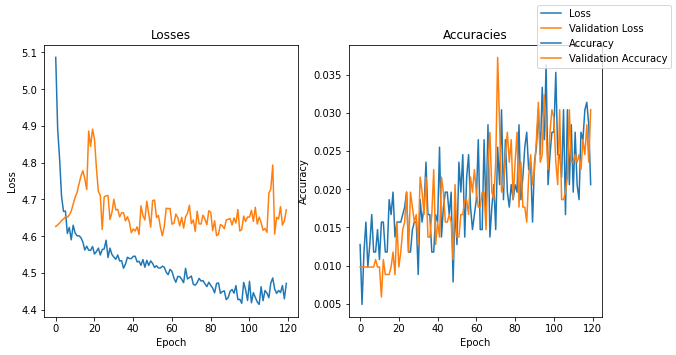

In [15]:
history = {'loss': [5.086607, 4.891028, 4.8105, 4.708412, 4.667637, 4.668048, 4.607385, 4.623818, 4.590005, 4.629722, 4.608683, 4.600798, 4.601169, 4.59583, 4.584163, 4.56228, 4.572638, 4.561872, 4.561254, 4.571932, 4.551338, 4.557903, 4.567478, 4.548749, 4.563562, 4.565157, 4.588894, 4.541884, 4.5674, 4.55, 4.543119, 4.536981, 4.548764, 4.532374, 4.533117, 4.512661, 4.524113, 4.542648, 4.53928, 4.538929, 4.545011, 4.545416, 4.530054, 4.531574, 4.520584, 4.536413, 4.51542, 4.534223, 4.520367, 4.532617, 4.525941, 4.514729, 4.51959, 4.513301, 4.513412, 4.51804, 4.515697, 4.501948, 4.495141, 4.509619, 4.503923, 4.48602, 4.474618, 4.490482, 4.489851, 4.48263, 4.473358, 4.512384, 4.483433, 4.487516, 4.4915, 4.469053, 4.466578, 4.473519, 4.484977, 4.477784, 4.478937, 4.470525, 4.462652, 4.474607, 4.466379, 4.458621, 4.445833, 4.471166, 4.472764, 4.444281, 4.449082, 4.451083, 4.427259, 4.432781, 4.449745, 4.454885, 4.444834, 4.465352, 4.427247, 4.42814, 4.417213, 4.474117, 4.453881, 4.424933, 4.476944, 4.418689, 4.44616, 4.433253, 4.421053, 4.414151, 4.46243, 4.424349, 4.452108, 4.445038, 4.432463, 4.472701, 4.486156, 4.456181, 4.444152, 4.452184, 4.44653, 4.465623, 4.429575, 4.471505], 'accuracy': [0.012745, 0.004902, 0.011765, 0.015686, 0.009804, 0.012745, 0.016667, 0.011765, 0.011765, 0.014706, 0.010784, 0.015686, 0.015686, 0.011765, 0.011765, 0.018627, 0.016667, 0.019608, 0.013725, 0.015686, 0.015686, 0.015686, 0.016667, 0.017647, 0.019608, 0.011765, 0.011765, 0.014706, 0.015686, 0.015686, 0.008824, 0.018627, 0.015686, 0.017647, 0.023529, 0.016667, 0.016667, 0.011765, 0.011765, 0.016667, 0.015686, 0.02549, 0.013725, 0.017647, 0.019608, 0.019608, 0.016667, 0.019608, 0.007843, 0.017647, 0.012745, 0.023529, 0.019608, 0.02451, 0.013725, 0.021569, 0.02451, 0.017647, 0.014706, 0.016667, 0.018627, 0.026471, 0.014706, 0.014706, 0.026471, 0.016667, 0.028431, 0.013725, 0.017647, 0.020588, 0.014706, 0.02549, 0.020588, 0.030392, 0.018627, 0.026471, 0.019608, 0.017647, 0.020588, 0.018627, 0.020588, 0.019608, 0.028431, 0.018627, 0.021569, 0.02549, 0.027451, 0.022549, 0.023529, 0.015686, 0.023529, 0.02549, 0.030392, 0.02451, 0.033333, 0.026471, 0.036275, 0.020588, 0.02451, 0.027451, 0.027451, 0.035294, 0.02451, 0.02451, 0.021569, 0.030392, 0.016667, 0.030392, 0.020588, 0.028431, 0.019608, 0.027451, 0.020588, 0.018627, 0.027451, 0.026471, 0.030392, 0.031373, 0.028431, 0.020588], 'val_loss': [4.626326, 4.63062, 4.635654, 4.642103, 4.646683, 4.652645, 4.651061, 4.657796, 4.667763, 4.686968, 4.705644, 4.718877, 4.741728, 4.763182, 4.778108, 4.756696, 4.726862, 4.886054, 4.843894, 4.891243, 4.863743, 4.785094, 4.722126, 4.71072, 4.618298, 4.706527, 4.710077, 4.71031, 4.645178, 4.664491, 4.700613, 4.671383, 4.672904, 4.652552, 4.663566, 4.663706, 4.641615, 4.652676, 4.638361, 4.609532, 4.619546, 4.613894, 4.62533, 4.604316, 4.682426, 4.656075, 4.644166, 4.695048, 4.660466, 4.62442, 4.696877, 4.698255, 4.65069, 4.656452, 4.625062, 4.601114, 4.625152, 4.676119, 4.674817, 4.675453, 4.632724, 4.634773, 4.659993, 4.650397, 4.628004, 4.651185, 4.621832, 4.65242, 4.662443, 4.684025, 4.634041, 4.644066, 4.612929, 4.667909, 4.633537, 4.633047, 4.657104, 4.646379, 4.630963, 4.669167, 4.664824, 4.614663, 4.641692, 4.601323, 4.605618, 4.631657, 4.628471, 4.620119, 4.643978, 4.6459, 4.647717, 4.630309, 4.649545, 4.635818, 4.672568, 4.613959, 4.618248, 4.654753, 4.639708, 4.652062, 4.651803, 4.670183, 4.640388, 4.678689, 4.633212, 4.651684, 4.637454, 4.615968, 4.620916, 4.610462, 4.717381, 4.728336, 4.793654, 4.605659, 4.651418, 4.646565, 4.68029, 4.630121, 4.641466, 4.671687], 'val_accuracy': [0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.010784, 0.009804, 0.009804, 0.005882, 0.010784, 0.008824, 0.008824, 0.008824, 0.009804, 0.011765, 0.008824, 0.015686, 0.009804, 0.011765, 0.014706, 0.015686, 0.019608, 0.011765, 0.019608, 0.017647, 0.015686, 0.016667, 0.012745, 0.021569, 0.019608, 0.016667, 0.021569, 0.013725, 0.013725, 0.016667, 0.022549, 0.012745, 0.015686, 0.013725, 0.021569, 0.019608, 0.015686, 0.015686, 0.016667, 0.015686, 0.010784, 0.020588, 0.013725, 0.013725, 0.016667, 0.016667, 0.018627, 0.018627, 0.016667, 0.021569, 0.019608, 0.022549, 0.019608, 0.017647, 0.017647, 0.019608, 0.019608, 0.014706, 0.023529, 0.027451, 0.019608, 0.018627, 0.023529, 0.037255, 0.028431, 0.019608, 0.020588, 0.02451, 0.027451, 0.023529, 0.026471, 0.018627, 0.023529, 0.027451, 0.017647, 0.023529, 0.017647, 0.017647, 0.015686, 0.021569, 0.02451, 0.020588, 0.022549, 0.026471, 0.031373, 0.023529, 0.02451, 0.032353, 0.027451, 0.022549, 0.027451, 0.030392, 0.029412, 0.023529, 0.020588, 0.030392, 0.018627, 0.018627, 0.019608, 0.021569, 0.030392, 0.023529, 0.023529, 0.02451, 0.023529, 0.02451, 0.022549, 0.026471, 0.02451, 0.028431, 0.023529, 0.030392]}

plot_history(history)
print(max(history['accuracy']), '|', max(history['val_accuracy']))

## Model 7 (depth=30, skips=[2, 3, 5, 8, 13, 21])

0.134314 | 0.094118


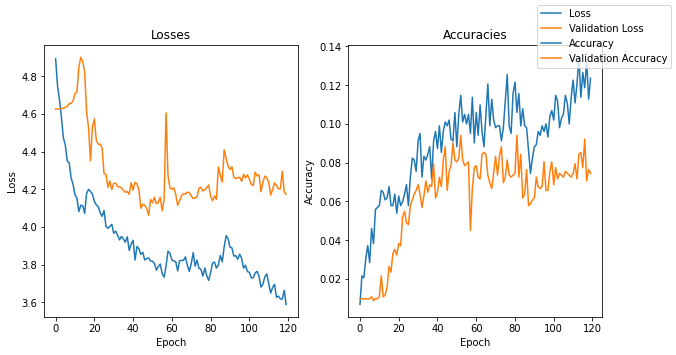

In [16]:
history = {'loss': [4.89319, 4.748472, 4.674715, 4.581836, 4.474596, 4.435531, 4.350806, 4.341587, 4.260673, 4.226339, 4.171782, 4.153233, 4.082014, 4.115816, 4.112966, 4.072747, 4.179003, 4.199831, 4.188788, 4.175401, 4.136713, 4.117488, 4.108925, 4.076506, 4.05667, 4.087366, 4.003995, 3.993302, 4.003372, 4.013997, 3.967226, 3.978596, 3.956987, 3.932001, 3.950158, 3.935851, 3.919649, 3.948306, 3.875764, 3.909902, 3.92994, 3.825122, 3.897415, 3.884278, 3.855343, 3.866032, 3.824916, 3.832913, 3.835671, 3.820174, 3.818907, 3.806987, 3.771234, 3.790526, 3.803489, 3.752725, 3.734184, 3.791926, 3.872354, 3.861012, 3.826539, 3.818668, 3.816846, 3.767223, 3.821784, 3.823178, 3.823016, 3.841707, 3.796979, 3.765137, 3.805636, 3.864723, 3.792702, 3.824722, 3.781343, 3.776093, 3.739763, 3.782628, 3.741928, 3.716815, 3.758336, 3.809286, 3.814099, 3.782213, 3.798878, 3.849283, 3.815409, 3.894301, 3.954411, 3.939066, 3.893346, 3.889401, 3.846056, 3.847886, 3.830166, 3.856184, 3.834092, 3.782107, 3.79715, 3.763752, 3.759734, 3.730277, 3.730864, 3.756003, 3.765157, 3.737581, 3.681499, 3.697661, 3.736296, 3.751325, 3.699051, 3.649718, 3.679616, 3.696214, 3.627156, 3.633719, 3.618989, 3.617933, 3.664513, 3.589396], 'accuracy': [0.006863, 0.021569, 0.020588, 0.030392, 0.037255, 0.028431, 0.046078, 0.038235, 0.055882, 0.056863, 0.057843, 0.065686, 0.064706, 0.060784, 0.061765, 0.067647, 0.057843, 0.057843, 0.063725, 0.053922, 0.062745, 0.057843, 0.059804, 0.063725, 0.068627, 0.057843, 0.072549, 0.082353, 0.081373, 0.07549, 0.091176, 0.095098, 0.072549, 0.083333, 0.081373, 0.084314, 0.088235, 0.071569, 0.091176, 0.096078, 0.087255, 0.09902, 0.085294, 0.096078, 0.10098, 0.09902, 0.101961, 0.092157, 0.091176, 0.105882, 0.088235, 0.104902, 0.114706, 0.10098, 0.104902, 0.1, 0.104902, 0.095098, 0.113725, 0.090196, 0.105882, 0.094118, 0.109804, 0.096078, 0.088235, 0.104902, 0.120588, 0.09902, 0.112745, 0.101961, 0.098039, 0.09902, 0.09902, 0.091176, 0.098039, 0.111765, 0.12549, 0.09902, 0.095098, 0.115686, 0.121569, 0.105882, 0.115686, 0.09902, 0.107843, 0.09902, 0.098039, 0.086275, 0.07451, 0.082353, 0.088235, 0.089216, 0.096078, 0.094118, 0.09902, 0.096078, 0.1, 0.093137, 0.103922, 0.106863, 0.101961, 0.114706, 0.111765, 0.098039, 0.102941, 0.104902, 0.114706, 0.110784, 0.1, 0.113725, 0.122549, 0.110784, 0.120588, 0.134314, 0.113725, 0.126471, 0.118627, 0.132353, 0.112745, 0.123529], 'val_loss': [4.625312, 4.626233, 4.627368, 4.628398, 4.630377, 4.634328, 4.64099, 4.654519, 4.655835, 4.6695, 4.708912, 4.715391, 4.849381, 4.900312, 4.877799, 4.822409, 4.611162, 4.526411, 4.351426, 4.531445, 4.573833, 4.460775, 4.439425, 4.440091, 4.419261, 4.283057, 4.278862, 4.210562, 4.24494, 4.19893, 4.231928, 4.23245, 4.21445, 4.213881, 4.207698, 4.194581, 4.184648, 4.18801, 4.173934, 4.23514, 4.196141, 4.237589, 4.229328, 4.196502, 4.099384, 4.120906, 4.116441, 4.099752, 4.062182, 4.146082, 4.128891, 4.158196, 4.124437, 4.130949, 4.158114, 4.085565, 4.14671, 4.605816, 4.275327, 4.208591, 4.200085, 4.208328, 4.173362, 4.115704, 4.139313, 4.165803, 4.177214, 4.175583, 4.184608, 4.1838, 4.165493, 4.150487, 4.154879, 4.160483, 4.206968, 4.211187, 4.191308, 4.197796, 4.208929, 4.223096, 4.161884, 4.139555, 4.164786, 4.146377, 4.317959, 4.27507, 4.238742, 4.409851, 4.363943, 4.324187, 4.305372, 4.320487, 4.264472, 4.256396, 4.2624, 4.2639, 4.243307, 4.279937, 4.261032, 4.277226, 4.253881, 4.227236, 4.220273, 4.291605, 4.271335, 4.276573, 4.187117, 4.238476, 4.270308, 4.261165, 4.236718, 4.169761, 4.198946, 4.234412, 4.2195, 4.203311, 4.202725, 4.296415, 4.185305, 4.174029], 'val_accuracy': [0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.010784, 0.008824, 0.009804, 0.009804, 0.010784, 0.021569, 0.010784, 0.011765, 0.015686, 0.026471, 0.023529, 0.033333, 0.035294, 0.032353, 0.038235, 0.037255, 0.051961, 0.054902, 0.04902, 0.048039, 0.057843, 0.060784, 0.063725, 0.065686, 0.068627, 0.063725, 0.056863, 0.062745, 0.070588, 0.064706, 0.068627, 0.067647, 0.079412, 0.061765, 0.064706, 0.072549, 0.067647, 0.081373, 0.088235, 0.065686, 0.07549, 0.078431, 0.090196, 0.081373, 0.080392, 0.082353, 0.094118, 0.081373, 0.078431, 0.079412, 0.080392, 0.045098, 0.066667, 0.077451, 0.078431, 0.072549, 0.071569, 0.084314, 0.085294, 0.084314, 0.073529, 0.069608, 0.066667, 0.07451, 0.083333, 0.073529, 0.083333, 0.088235, 0.069608, 0.072549, 0.081373, 0.073529, 0.072549, 0.073529, 0.07451, 0.094118, 0.072549, 0.084314, 0.061765, 0.063725, 0.076471, 0.057843, 0.058824, 0.060784, 0.061765, 0.072549, 0.067647, 0.066667, 0.067647, 0.080392, 0.065686, 0.065686, 0.07549, 0.080392, 0.068627, 0.077451, 0.071569, 0.07451, 0.073529, 0.072549, 0.07549, 0.07451, 0.073529, 0.072549, 0.07451, 0.079412, 0.071569, 0.084314, 0.085294, 0.077451, 0.092157, 0.070588, 0.076471, 0.07451]}

plot_history(history)
print(max(history['accuracy']), '|', max(history['val_accuracy']))

## Model 8 (depth=30, skips=[2, 3, 5, 8, 13, 21])

0.041176 | 0.035294


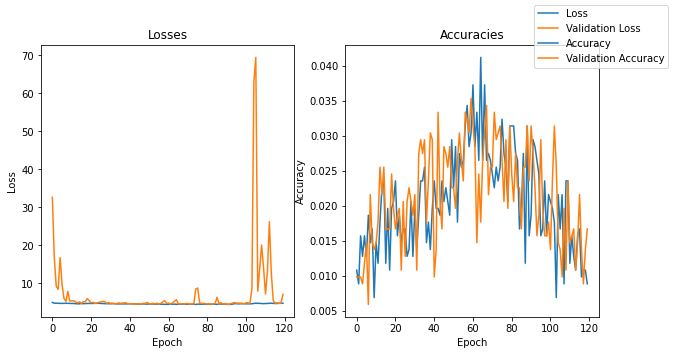

In [17]:
history = {'loss': [5.018319, 4.779753, 4.802488, 4.775996, 4.74552, 4.758286, 4.744069, 4.775954, 4.760247, 4.742341, 4.722905, 4.740964, 4.649823, 4.641815, 4.636615, 4.707096, 4.67471, 4.691229, 4.730086, 4.740242, 4.725834, 4.740756, 4.752261, 4.759723, 4.780746, 4.726988, 4.710612, 4.678868, 4.666587, 4.670634, 4.638478, 4.673852, 4.689576, 4.604233, 4.620131, 4.601905, 4.62193, 4.597948, 4.611623, 4.629493, 4.646375, 4.59472, 4.618809, 4.574564, 4.581422, 4.564669, 4.563642, 4.610848, 4.580721, 4.552442, 4.593291, 4.557953, 4.609929, 4.500214, 4.57601, 4.555871, 4.510363, 4.53485, 4.491439, 4.482675, 4.515558, 4.555814, 4.524419, 4.549991, 4.494314, 4.528429, 4.542193, 4.540282, 4.541557, 4.527471, 4.540826, 4.521359, 4.522701, 4.535301, 4.467257, 4.559382, 4.540923, 4.506108, 4.564288, 4.514729, 4.507807, 4.524325, 4.481069, 4.542775, 4.521578, 4.500359, 4.59283, 4.576167, 4.538449, 4.605937, 4.502556, 4.494589, 4.480803, 4.543866, 4.686048, 4.642325, 4.626705, 4.637412, 4.667173, 4.652041, 4.63263, 4.63566, 4.626862, 4.650987, 4.732451, 4.787997, 4.760582, 4.753429, 4.714588, 4.670189, 4.708257, 4.738136, 4.756654, 4.81454, 4.732295, 4.73491, 4.709717, 4.782801, 4.777371, 4.790549], 'accuracy': [0.010784, 0.008824, 0.015686, 0.012745, 0.015686, 0.012745, 0.018627, 0.014706, 0.016667, 0.006863, 0.014706, 0.011765, 0.017647, 0.022549, 0.023529, 0.011765, 0.019608, 0.010784, 0.019608, 0.020588, 0.023529, 0.015686, 0.018627, 0.014706, 0.016667, 0.016667, 0.012745, 0.013725, 0.020588, 0.012745, 0.019608, 0.013725, 0.018627, 0.023529, 0.023529, 0.02549, 0.014706, 0.017647, 0.013725, 0.019608, 0.023529, 0.019608, 0.019608, 0.018627, 0.023529, 0.020588, 0.022549, 0.020588, 0.018627, 0.029412, 0.022549, 0.028431, 0.017647, 0.027451, 0.02549, 0.026471, 0.031373, 0.034314, 0.028431, 0.030392, 0.037255, 0.028431, 0.033333, 0.026471, 0.041176, 0.026471, 0.037255, 0.026471, 0.027451, 0.026471, 0.02451, 0.022549, 0.02549, 0.023529, 0.02549, 0.032353, 0.027451, 0.02549, 0.020588, 0.031373, 0.031373, 0.031373, 0.027451, 0.026471, 0.016667, 0.019608, 0.027451, 0.011765, 0.031373, 0.015686, 0.018627, 0.029412, 0.028431, 0.026471, 0.02451, 0.015686, 0.016667, 0.023529, 0.015686, 0.021569, 0.020588, 0.019608, 0.017647, 0.006863, 0.021569, 0.016667, 0.021569, 0.008824, 0.023529, 0.023529, 0.011765, 0.015686, 0.012745, 0.010784, 0.015686, 0.016667, 0.009804, 0.010784, 0.010784, 0.008824], 'val_loss': [32.647339, 16.852898, 9.305022, 8.426834, 16.759232, 9.794376, 6.063621, 5.256626, 7.928391, 5.362111, 5.441419, 5.448738, 5.141125, 4.86142, 5.158536, 4.721582, 5.194083, 5.174717, 6.01574, 5.48115, 4.901421, 5.002525, 4.777328, 4.831126, 5.034332, 5.135834, 5.267183, 5.211328, 4.752306, 4.960628, 4.774394, 4.813505, 4.66797, 4.592009, 4.895043, 4.751924, 4.803123, 4.866985, 4.902477, 4.668949, 4.658471, 4.700261, 4.582715, 4.586608, 4.57607, 4.649817, 4.58282, 4.764093, 4.785077, 4.982596, 4.662374, 4.57453, 4.78883, 4.589334, 4.809214, 4.569542, 4.736009, 5.182258, 5.430211, 4.759276, 4.838012, 4.569517, 4.85003, 5.298418, 5.728078, 4.640728, 4.650486, 4.654794, 4.579152, 4.708127, 4.706294, 4.5505, 4.623923, 4.583755, 8.499419, 8.788205, 4.927567, 4.699174, 4.766953, 4.657785, 4.583264, 4.582983, 4.580199, 4.614234, 4.696314, 6.344117, 4.638328, 4.926001, 4.577174, 4.735002, 4.560447, 4.480626, 4.657842, 4.845149, 4.924364, 4.823381, 4.812016, 4.777755, 4.792552, 4.650595, 4.90894, 4.853524, 4.795535, 8.581131, 63.020199, 69.444809, 7.944332, 13.740808, 20.098265, 14.075443, 7.198413, 13.093271, 26.242802, 12.700982, 5.479875, 4.81461, 4.889169, 4.746357, 4.761895, 7.134878], 'val_accuracy': [0.009804, 0.009804, 0.009804, 0.008824, 0.011765, 0.014706, 0.005882, 0.021569, 0.014706, 0.013725, 0.014706, 0.017647, 0.02549, 0.021569, 0.02549, 0.016667, 0.016667, 0.016667, 0.02451, 0.019608, 0.016667, 0.018627, 0.019608, 0.010784, 0.020588, 0.012745, 0.020588, 0.022549, 0.020588, 0.018627, 0.021569, 0.010784, 0.027451, 0.029412, 0.027451, 0.029412, 0.017647, 0.023529, 0.030392, 0.029412, 0.009804, 0.013725, 0.033333, 0.020588, 0.016667, 0.028431, 0.027451, 0.02549, 0.028431, 0.022549, 0.022549, 0.019608, 0.026471, 0.030392, 0.026471, 0.023529, 0.033333, 0.032353, 0.030392, 0.035294, 0.031373, 0.028431, 0.014706, 0.02451, 0.017647, 0.026471, 0.030392, 0.034314, 0.021569, 0.02549, 0.02549, 0.033333, 0.029412, 0.030392, 0.031373, 0.026471, 0.020588, 0.029412, 0.019608, 0.031373, 0.02451, 0.020588, 0.027451, 0.022549, 0.022549, 0.016667, 0.02549, 0.02549, 0.031373, 0.023529, 0.031373, 0.027451, 0.022549, 0.015686, 0.018627, 0.029412, 0.019608, 0.015686, 0.015686, 0.017647, 0.013725, 0.023529, 0.031373, 0.02549, 0.014706, 0.013725, 0.009804, 0.019608, 0.010784, 0.023529, 0.014706, 0.015686, 0.016667, 0.010784, 0.014706, 0.021569, 0.013725, 0.008824, 0.013725, 0.016667]}

plot_history(history)
print(max(history['accuracy']), '|', max(history['val_accuracy']))

## Model 10 (depth=20, skips=[2, 3, 5, 8, 13])

0.182353 | 0.083333


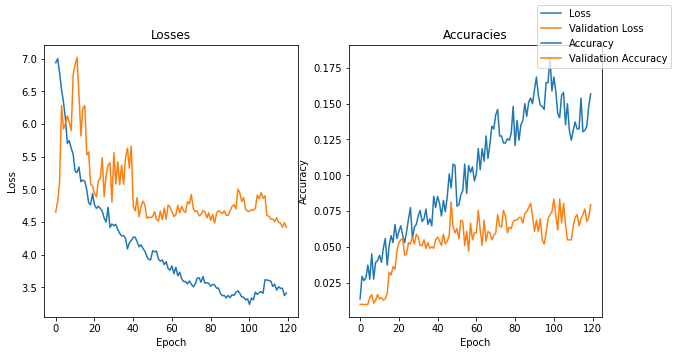

In [18]:
history = {'loss': [6.940204, 7.002898, 6.784101, 6.526034, 6.339378, 6.080689, 5.702124, 5.745649, 5.627224, 5.536824, 5.274893, 5.257538, 5.342301, 5.116095, 5.140645, 5.121687, 4.993644, 4.794036, 4.761634, 4.935325, 4.762495, 4.707802, 4.740272, 4.708177, 4.664823, 4.559032, 4.496655, 4.72429, 4.4165, 4.468568, 4.442174, 4.462479, 4.383713, 4.324912, 4.287296, 4.289674, 4.250465, 4.086909, 4.180121, 4.213561, 4.265695, 4.266548, 4.19797, 4.120072, 4.150098, 4.094834, 4.051987, 3.971443, 3.925952, 3.919888, 4.057845, 4.041041, 4.053149, 3.932688, 3.899347, 3.918228, 3.844831, 3.890835, 3.786227, 3.760092, 3.825287, 3.706306, 3.805942, 3.672983, 3.728793, 3.62766, 3.586881, 3.586058, 3.550383, 3.594558, 3.54523, 3.506837, 3.548215, 3.639202, 3.642845, 3.576254, 3.663532, 3.560896, 3.567774, 3.559167, 3.515053, 3.54264, 3.534796, 3.482798, 3.486548, 3.40355, 3.369373, 3.373264, 3.335808, 3.372968, 3.340362, 3.385139, 3.373716, 3.422683, 3.444773, 3.406734, 3.349534, 3.345654, 3.305927, 3.322388, 3.235415, 3.334422, 3.304423, 3.424141, 3.389128, 3.416719, 3.43182, 3.406692, 3.614195, 3.608709, 3.60321, 3.592753, 3.512208, 3.546088, 3.455436, 3.506756, 3.482839, 3.483637, 3.371015, 3.408784], 'accuracy': [0.013725, 0.029412, 0.026471, 0.028431, 0.037255, 0.027451, 0.045098, 0.027451, 0.039216, 0.040196, 0.044118, 0.039216, 0.04902, 0.055882, 0.037255, 0.05098, 0.057843, 0.052941, 0.065686, 0.055882, 0.060784, 0.064706, 0.057843, 0.052941, 0.060784, 0.069608, 0.077451, 0.055882, 0.063725, 0.065686, 0.071569, 0.07549, 0.067647, 0.069608, 0.076471, 0.065686, 0.069608, 0.064706, 0.085294, 0.077451, 0.085294, 0.080392, 0.071569, 0.082353, 0.07451, 0.085294, 0.10098, 0.091176, 0.107843, 0.106863, 0.078431, 0.079412, 0.086275, 0.089216, 0.107843, 0.087255, 0.106863, 0.101961, 0.105882, 0.096078, 0.10098, 0.118627, 0.103922, 0.118627, 0.109804, 0.127451, 0.111765, 0.121569, 0.134314, 0.132353, 0.142157, 0.146078, 0.127451, 0.127451, 0.122549, 0.122549, 0.12549, 0.12451, 0.129412, 0.148039, 0.120588, 0.138235, 0.12451, 0.135294, 0.138235, 0.15, 0.141176, 0.15098, 0.153922, 0.15, 0.159804, 0.168627, 0.155882, 0.14902, 0.148039, 0.146078, 0.164706, 0.164706, 0.182353, 0.158824, 0.168627, 0.158824, 0.143137, 0.140196, 0.155882, 0.157843, 0.135294, 0.15, 0.131373, 0.12451, 0.131373, 0.137255, 0.132353, 0.132353, 0.153922, 0.130392, 0.131373, 0.134314, 0.148039, 0.156863], 'val_loss': [4.651115, 4.814884, 5.115777, 6.284649, 5.923137, 6.007481, 6.125083, 6.031417, 5.903734, 6.75604, 6.908544, 7.022505, 6.452855, 5.817385, 6.245041, 6.286623, 5.52632, 5.572699, 5.078659, 5.050117, 4.937332, 4.882754, 5.134053, 5.171484, 5.483562, 4.889366, 5.219658, 5.368108, 5.406523, 4.803712, 5.56194, 5.084082, 5.421613, 5.072665, 5.371349, 5.074384, 5.475353, 5.631331, 5.322906, 5.663823, 4.743503, 4.669759, 4.874737, 4.579206, 4.730824, 4.81766, 4.765118, 4.556639, 4.575018, 4.566443, 4.579643, 4.657675, 4.539955, 4.513513, 4.66374, 4.535061, 4.712255, 4.54031, 4.757336, 4.730162, 4.65991, 4.583112, 4.609755, 4.753982, 4.639436, 4.739721, 4.670716, 4.644306, 4.811457, 4.776536, 4.920889, 4.702613, 4.659714, 4.670702, 4.593781, 4.61336, 4.675054, 4.655025, 4.561477, 4.639565, 4.524003, 4.616895, 4.482769, 4.632099, 4.671894, 4.654536, 4.626021, 4.671453, 4.602194, 4.599741, 4.676706, 4.736252, 4.765104, 4.698506, 5.001764, 4.943662, 4.8141, 4.87464, 4.689519, 4.664718, 4.659949, 4.688707, 4.678889, 4.706817, 4.908169, 4.853237, 4.950951, 4.859975, 4.90093, 4.598701, 4.586836, 4.541528, 4.544498, 4.504681, 4.566061, 4.494113, 4.481194, 4.418008, 4.489461, 4.417152], 'val_accuracy': [0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.014706, 0.016667, 0.010784, 0.012745, 0.016667, 0.013725, 0.014706, 0.012745, 0.013725, 0.017647, 0.032353, 0.030392, 0.036275, 0.034314, 0.047059, 0.052941, 0.054902, 0.055882, 0.044118, 0.045098, 0.052941, 0.051961, 0.056863, 0.051961, 0.058824, 0.056863, 0.05098, 0.05098, 0.054902, 0.04902, 0.052941, 0.04902, 0.05, 0.04902, 0.054902, 0.056863, 0.053922, 0.05098, 0.058824, 0.051961, 0.053922, 0.057843, 0.081373, 0.063725, 0.059804, 0.062745, 0.055882, 0.068627, 0.067647, 0.05098, 0.060784, 0.047059, 0.066667, 0.054902, 0.059804, 0.059804, 0.07549, 0.061765, 0.05098, 0.068627, 0.053922, 0.060784, 0.059804, 0.054902, 0.057843, 0.059804, 0.072549, 0.064706, 0.063725, 0.07549, 0.071569, 0.059804, 0.063725, 0.062745, 0.067647, 0.068627, 0.068627, 0.070588, 0.070588, 0.066667, 0.073529, 0.07451, 0.077451, 0.080392, 0.071569, 0.060784, 0.068627, 0.060784, 0.069608, 0.054902, 0.051961, 0.059804, 0.069608, 0.072549, 0.07451, 0.083333, 0.072549, 0.061765, 0.083333, 0.066667, 0.080392, 0.065686, 0.054902, 0.054902, 0.054902, 0.064706, 0.070588, 0.072549, 0.064706, 0.069608, 0.072549, 0.076471, 0.067647, 0.070588, 0.079412]}
plot_history(history)
print(max(history['accuracy']), '|', max(history['val_accuracy']))

## Model 11 (depth=30, skips=[2, 3, 5, 8, 13, 21])
* Uses Conv Merge

0.079412 | 0.055882


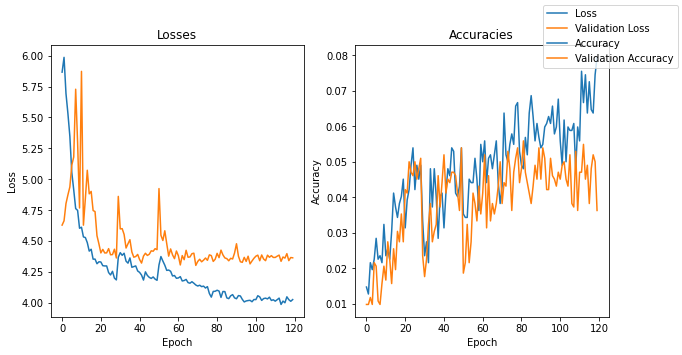

In [19]:
history = {'loss': [5.866611, 5.986466, 5.693815, 5.531745, 5.348197, 5.0545, 4.914179, 4.762941, 4.748116, 4.603439, 4.611916, 4.533374, 4.528438, 4.486985, 4.418464, 4.433768, 4.353338, 4.353845, 4.316489, 4.332121, 4.330582, 4.30052, 4.298563, 4.298521, 4.245007, 4.225518, 4.254998, 4.199982, 4.185589, 4.3685, 4.406151, 4.384432, 4.401584, 4.337368, 4.321167, 4.363352, 4.287633, 4.293253, 4.298619, 4.257904, 4.246351, 4.224438, 4.184179, 4.250708, 4.221687, 4.205845, 4.197616, 4.209483, 4.191937, 4.182221, 4.306802, 4.374598, 4.338168, 4.304595, 4.262655, 4.265309, 4.255359, 4.217422, 4.220952, 4.198682, 4.201245, 4.212051, 4.176865, 4.18054, 4.189457, 4.163688, 4.158689, 4.170909, 4.1587, 4.14431, 4.136045, 4.142623, 4.131215, 4.135197, 4.11981, 4.131111, 4.075687, 4.046198, 4.09236, 4.093594, 4.101944, 4.095336, 4.04395, 4.09168, 4.090886, 4.040012, 4.033986, 4.056805, 4.066476, 4.040143, 4.033004, 4.058699, 4.055569, 4.028018, 4.007383, 4.015224, 4.01852, 4.020333, 4.00886, 4.026878, 4.026116, 4.057587, 4.047835, 4.01969, 4.03443, 4.037948, 4.031868, 4.045723, 4.01938, 4.024822, 4.013637, 4.025424, 4.0383, 3.986954, 4.014225, 4.000497, 4.048674, 4.025579, 4.012519, 4.026234], 'accuracy': [0.014706, 0.012745, 0.021569, 0.019608, 0.022549, 0.028431, 0.022549, 0.023529, 0.021569, 0.032353, 0.023529, 0.02549, 0.022549, 0.030392, 0.041176, 0.037255, 0.034314, 0.038235, 0.040196, 0.045098, 0.031373, 0.039216, 0.042157, 0.04902, 0.053922, 0.042157, 0.04902, 0.045098, 0.04902, 0.033333, 0.023529, 0.027451, 0.021569, 0.048039, 0.037255, 0.048039, 0.040196, 0.028431, 0.040196, 0.041176, 0.031373, 0.041176, 0.048039, 0.046078, 0.053922, 0.052941, 0.041176, 0.040196, 0.043137, 0.053922, 0.035294, 0.034314, 0.034314, 0.045098, 0.044118, 0.044118, 0.05098, 0.045098, 0.036275, 0.054902, 0.05, 0.055882, 0.044118, 0.05098, 0.051961, 0.048039, 0.051961, 0.055882, 0.044118, 0.038235, 0.043137, 0.063725, 0.051961, 0.05, 0.054902, 0.057843, 0.054902, 0.065686, 0.066667, 0.052941, 0.04902, 0.048039, 0.056863, 0.051961, 0.063725, 0.068627, 0.062745, 0.055882, 0.060784, 0.056863, 0.053922, 0.054902, 0.059804, 0.060784, 0.062745, 0.060784, 0.065686, 0.057843, 0.059804, 0.067647, 0.055882, 0.04902, 0.061765, 0.05, 0.059804, 0.058824, 0.058824, 0.060784, 0.048039, 0.059804, 0.055882, 0.07549, 0.066667, 0.07451, 0.063725, 0.072549, 0.064706, 0.063725, 0.07451, 0.079412], 'val_loss': [4.628933, 4.663774, 4.80317, 4.873614, 4.937685, 5.114433, 5.180275, 5.72859, 5.296259, 4.76743, 5.87298, 4.628457, 4.843412, 5.073045, 4.882081, 4.901689, 4.746908, 4.738619, 4.543138, 4.477118, 4.40391, 4.432523, 4.403654, 4.404356, 4.438665, 4.388883, 4.390574, 4.433818, 4.362976, 4.861298, 4.598218, 4.600385, 4.553518, 4.443452, 4.478133, 4.51095, 4.411345, 4.369209, 4.374806, 4.391713, 4.350201, 4.321772, 4.378219, 4.401244, 4.383451, 4.393385, 4.420859, 4.41774, 4.438173, 4.430201, 4.92458, 4.546896, 4.504485, 4.583047, 4.4791, 4.37794, 4.436018, 4.388044, 4.357508, 4.419444, 4.381517, 4.306558, 4.382335, 4.349058, 4.425268, 4.368777, 4.371519, 4.397568, 4.401779, 4.302866, 4.334894, 4.352465, 4.332059, 4.345401, 4.362664, 4.343892, 4.388277, 4.382218, 4.335007, 4.352758, 4.400578, 4.365473, 4.426558, 4.387881, 4.363371, 4.357911, 4.340279, 4.360326, 4.354974, 4.403349, 4.478178, 4.377765, 4.332533, 4.327694, 4.36794, 4.335213, 4.377372, 4.31506, 4.338732, 4.360327, 4.377596, 4.385763, 4.340635, 4.387261, 4.354486, 4.341194, 4.385799, 4.368563, 4.381855, 4.367323, 4.367476, 4.377456, 4.386176, 4.335989, 4.370876, 4.362085, 4.397976, 4.341549, 4.366626, 4.364275], 'val_accuracy': [0.009804, 0.009804, 0.011765, 0.009804, 0.021569, 0.020588, 0.010784, 0.009804, 0.015686, 0.020588, 0.016667, 0.027451, 0.022549, 0.015686, 0.02549, 0.019608, 0.030392, 0.027451, 0.035294, 0.027451, 0.042157, 0.041176, 0.05, 0.047059, 0.046078, 0.05, 0.045098, 0.048039, 0.05098, 0.023529, 0.017647, 0.022549, 0.032353, 0.038235, 0.027451, 0.030392, 0.032353, 0.046078, 0.037255, 0.044118, 0.051961, 0.041176, 0.045098, 0.044118, 0.047059, 0.047059, 0.046078, 0.041176, 0.036275, 0.053922, 0.018627, 0.021569, 0.032353, 0.021569, 0.027451, 0.041176, 0.038235, 0.033333, 0.043137, 0.035294, 0.041176, 0.051961, 0.031373, 0.046078, 0.033333, 0.038235, 0.035294, 0.038235, 0.043137, 0.05, 0.038235, 0.044118, 0.043137, 0.052941, 0.048039, 0.036275, 0.047059, 0.05098, 0.053922, 0.044118, 0.048039, 0.055882, 0.047059, 0.044118, 0.041176, 0.038235, 0.043137, 0.04902, 0.045098, 0.053922, 0.045098, 0.053922, 0.05098, 0.042157, 0.042157, 0.05098, 0.046078, 0.045098, 0.043137, 0.047059, 0.045098, 0.04902, 0.05, 0.045098, 0.043137, 0.051961, 0.038235, 0.037255, 0.052941, 0.036275, 0.047059, 0.047059, 0.054902, 0.045098, 0.04902, 0.038235, 0.048039, 0.051961, 0.05, 0.036275]}

plot_history(history)
print(max(history['accuracy']), '|', max(history['val_accuracy']))


## Model 12 (depth=30, skips=[2, 3, 5, 8, 13, 21])
* Uses Dense Merge

0.185294 | 0.089216


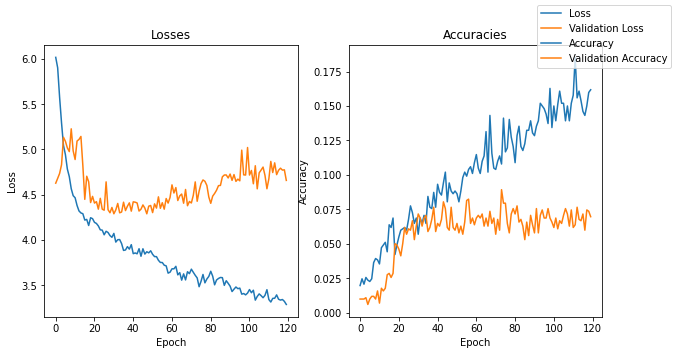

In [20]:
history = {'loss': [6.015894, 5.900825, 5.575938, 5.292697, 5.044319, 4.942483, 4.783807, 4.700113, 4.566978, 4.490133, 4.467162, 4.382183, 4.321878, 4.299568, 4.29094, 4.220905, 4.228153, 4.161135, 4.246659, 4.236358, 4.195755, 4.183529, 4.15624, 4.113066, 4.110096, 4.058498, 4.097252, 4.083723, 4.049861, 4.030771, 4.073817, 3.978166, 4.004461, 4.005783, 3.961231, 3.886083, 3.890865, 3.927771, 3.900445, 3.949588, 3.850421, 3.858187, 3.848899, 3.904911, 3.821562, 3.904393, 3.845587, 3.871548, 3.85919, 3.882108, 3.842995, 3.817919, 3.817778, 3.777169, 3.753211, 3.752674, 3.722704, 3.716101, 3.635473, 3.646072, 3.683441, 3.682965, 3.710595, 3.616582, 3.640886, 3.558267, 3.627316, 3.560688, 3.651298, 3.62972, 3.67934, 3.644833, 3.611681, 3.582685, 3.485706, 3.545867, 3.620921, 3.528394, 3.570902, 3.599214, 3.656217, 3.60212, 3.506569, 3.559863, 3.576679, 3.587711, 3.585622, 3.500665, 3.551907, 3.522945, 3.49165, 3.432332, 3.458516, 3.482734, 3.464061, 3.470294, 3.40362, 3.410676, 3.395911, 3.415549, 3.454465, 3.419413, 3.446895, 3.337657, 3.37804, 3.406459, 3.387028, 3.364351, 3.390811, 3.452921, 3.344301, 3.316866, 3.357511, 3.358222, 3.395463, 3.347714, 3.33819, 3.34476, 3.324317, 3.290164], 'accuracy': [0.019608, 0.02451, 0.020588, 0.02549, 0.023529, 0.022549, 0.02451, 0.036275, 0.039216, 0.038235, 0.035294, 0.047059, 0.04902, 0.05098, 0.044118, 0.063725, 0.061765, 0.068627, 0.042157, 0.04902, 0.054902, 0.059804, 0.060784, 0.061765, 0.059804, 0.067647, 0.077451, 0.072549, 0.064706, 0.068627, 0.056863, 0.068627, 0.064706, 0.070588, 0.064706, 0.084314, 0.076471, 0.07549, 0.087255, 0.076471, 0.093137, 0.087255, 0.085294, 0.094118, 0.101961, 0.080392, 0.094118, 0.088235, 0.086275, 0.088235, 0.086275, 0.080392, 0.088235, 0.098039, 0.101961, 0.09902, 0.103922, 0.105882, 0.10098, 0.108824, 0.114706, 0.104902, 0.10098, 0.109804, 0.113725, 0.131373, 0.101961, 0.143137, 0.115686, 0.104902, 0.103922, 0.109804, 0.113725, 0.107843, 0.141176, 0.116667, 0.119608, 0.140196, 0.127451, 0.120588, 0.108824, 0.128431, 0.135294, 0.120588, 0.117647, 0.122549, 0.132353, 0.132353, 0.139216, 0.130392, 0.128431, 0.135294, 0.139216, 0.151961, 0.15, 0.148039, 0.144118, 0.137255, 0.162745, 0.134314, 0.15, 0.139216, 0.15098, 0.160784, 0.151961, 0.151961, 0.139216, 0.15, 0.139216, 0.151961, 0.157843, 0.185294, 0.155882, 0.160784, 0.153922, 0.146078, 0.143137, 0.15, 0.159804, 0.161765], 'val_loss': [4.627974, 4.680903, 4.735023, 4.831739, 5.134456, 5.089382, 5.017103, 4.976289, 5.227515, 4.984959, 4.889005, 5.0928, 5.110307, 5.143511, 4.821533, 4.449454, 4.704485, 4.643034, 4.414062, 4.482258, 4.408204, 4.424108, 4.341455, 4.460896, 4.341353, 4.329812, 4.642344, 4.335189, 4.301862, 4.360102, 4.290412, 4.332961, 4.404238, 4.301114, 4.309831, 4.418189, 4.325501, 4.373901, 4.410888, 4.319384, 4.42214, 4.418212, 4.409889, 4.320298, 4.341056, 4.387923, 4.352644, 4.289942, 4.374397, 4.381658, 4.303286, 4.399817, 4.353086, 4.47717, 4.350617, 4.412477, 4.341023, 4.458548, 4.408125, 4.470556, 4.609345, 4.519488, 4.579195, 4.436503, 4.487694, 4.508008, 4.406933, 4.558453, 4.379143, 4.425945, 4.409428, 4.494512, 4.641959, 4.428424, 4.540409, 4.623711, 4.663584, 4.648619, 4.603005, 4.475445, 4.405708, 4.484723, 4.514583, 4.550246, 4.600704, 4.603069, 4.697789, 4.718046, 4.718679, 4.685128, 4.728647, 4.658999, 4.722695, 4.647643, 4.672843, 4.654042, 4.992322, 4.719851, 4.717705, 5.021373, 4.717676, 4.768123, 4.621274, 4.820329, 4.565541, 4.741817, 4.773018, 4.805477, 4.713447, 4.56618, 4.676413, 4.868036, 4.74528, 4.852143, 4.722189, 4.770218, 4.793365, 4.772024, 4.775234, 4.658586], 'val_accuracy': [0.009804, 0.009804, 0.009804, 0.010784, 0.005882, 0.009804, 0.011765, 0.011765, 0.009804, 0.015686, 0.006863, 0.017647, 0.015686, 0.017647, 0.027451, 0.028431, 0.02549, 0.028431, 0.05, 0.04902, 0.046078, 0.041176, 0.05, 0.061765, 0.056863, 0.060784, 0.059804, 0.066667, 0.052941, 0.062745, 0.071569, 0.068627, 0.062745, 0.068627, 0.070588, 0.058824, 0.061765, 0.067647, 0.076471, 0.058824, 0.064706, 0.062745, 0.067647, 0.080392, 0.07549, 0.061765, 0.059804, 0.076471, 0.061765, 0.059804, 0.064706, 0.057843, 0.062745, 0.056863, 0.065686, 0.081373, 0.082353, 0.064706, 0.068627, 0.063725, 0.068627, 0.070588, 0.068627, 0.071569, 0.062745, 0.068627, 0.062745, 0.073529, 0.064706, 0.068627, 0.056863, 0.067647, 0.059804, 0.089216, 0.079412, 0.079412, 0.064706, 0.057843, 0.071569, 0.07549, 0.071569, 0.077451, 0.065686, 0.067647, 0.062745, 0.052941, 0.065686, 0.055882, 0.070588, 0.063725, 0.057843, 0.07549, 0.057843, 0.070588, 0.07451, 0.068627, 0.068627, 0.07549, 0.068627, 0.065686, 0.061765, 0.068627, 0.060784, 0.066667, 0.064706, 0.070588, 0.07549, 0.071569, 0.062745, 0.07451, 0.061765, 0.063725, 0.076471, 0.067647, 0.066667, 0.071569, 0.059804, 0.07451, 0.073529, 0.069608]}

plot_history(history)
print(max(history['accuracy']), '|', max(history['val_accuracy']))

## Model 13 (depth=30, skips=[2, 3, 5, 8, 13])

0.131373 | 0.098039


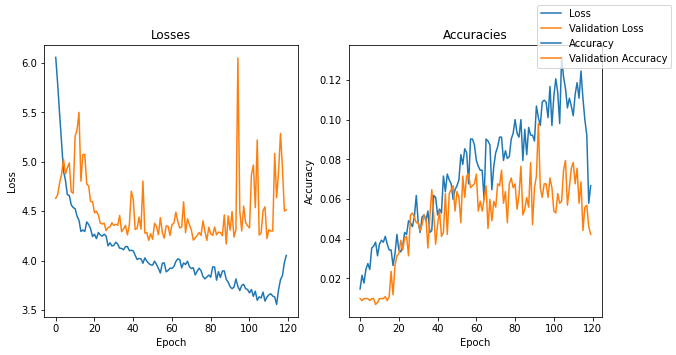

In [21]:
history = {'loss': [6.054215, 5.785926, 5.482844, 5.196342, 4.903621, 4.814833, 4.665305, 4.657789, 4.563179, 4.535764, 4.524893, 4.448732, 4.407328, 4.293612, 4.308867, 4.293216, 4.390233, 4.363356, 4.321597, 4.242415, 4.266517, 4.221354, 4.283732, 4.258945, 4.24683, 4.266548, 4.247328, 4.148732, 4.179712, 4.146996, 4.153595, 4.185728, 4.165442, 4.124728, 4.122862, 4.109126, 4.140209, 4.14167, 4.099525, 4.104393, 4.097873, 4.053221, 4.010542, 4.021713, 4.016195, 3.973129, 4.026817, 3.994184, 3.970705, 3.956261, 3.953622, 3.993676, 3.960386, 3.920689, 3.874067, 3.972203, 3.976675, 3.885864, 3.899912, 3.923632, 3.920359, 3.939577, 3.990419, 4.016676, 4.009859, 3.925329, 3.976515, 3.959809, 3.993507, 3.937474, 3.919184, 3.927308, 3.854149, 3.891754, 3.922504, 3.897025, 3.837827, 3.814434, 3.833303, 3.852973, 3.831594, 3.936492, 3.934212, 3.801324, 3.886952, 3.829486, 3.894344, 3.895128, 3.809984, 3.781684, 3.735099, 3.715419, 3.730964, 3.813891, 3.737773, 3.696958, 3.747626, 3.759792, 3.715926, 3.707093, 3.672711, 3.706959, 3.638744, 3.690042, 3.598272, 3.632962, 3.621426, 3.6814, 3.58976, 3.629637, 3.653083, 3.663971, 3.64043, 3.63203, 3.556142, 3.70465, 3.806488, 3.84698, 3.979234, 4.051758], 'accuracy': [0.014706, 0.021569, 0.017647, 0.02451, 0.027451, 0.02451, 0.035294, 0.036275, 0.038235, 0.031373, 0.037255, 0.039216, 0.038235, 0.041176, 0.037255, 0.034314, 0.034314, 0.026471, 0.032353, 0.042157, 0.034314, 0.033333, 0.036275, 0.043137, 0.042157, 0.04902, 0.048039, 0.046078, 0.05098, 0.061765, 0.048039, 0.043137, 0.05098, 0.051961, 0.04902, 0.053922, 0.043137, 0.044118, 0.061765, 0.060784, 0.051961, 0.054902, 0.052941, 0.071569, 0.063725, 0.072549, 0.069608, 0.067647, 0.059804, 0.064706, 0.066667, 0.069608, 0.082353, 0.077451, 0.085294, 0.083333, 0.067647, 0.090196, 0.090196, 0.087255, 0.079412, 0.076471, 0.07451, 0.07451, 0.059804, 0.090196, 0.089216, 0.087255, 0.064706, 0.076471, 0.083333, 0.086275, 0.091176, 0.091176, 0.079412, 0.084314, 0.080392, 0.081373, 0.090196, 0.093137, 0.1, 0.093137, 0.091176, 0.1, 0.079412, 0.095098, 0.082353, 0.096078, 0.092157, 0.092157, 0.089216, 0.106863, 0.10098, 0.097059, 0.108824, 0.109804, 0.108824, 0.10098, 0.116667, 0.097059, 0.111765, 0.120588, 0.113725, 0.098039, 0.131373, 0.121569, 0.115686, 0.105882, 0.110784, 0.106863, 0.101961, 0.112745, 0.118627, 0.110784, 0.12451, 0.110784, 0.1, 0.092157, 0.057843, 0.066667], 'val_loss': [4.6291, 4.666695, 4.785149, 4.873291, 5.026415, 4.875466, 4.937228, 4.986723, 4.695001, 4.680115, 5.256859, 5.320936, 5.498356, 4.80193, 5.070002, 5.074072, 4.773203, 4.754928, 4.595882, 4.595111, 4.48279, 4.498529, 4.45898, 4.377513, 4.369937, 4.377309, 4.302323, 4.333803, 4.34011, 4.381389, 4.354999, 4.367118, 4.35654, 4.456041, 4.291284, 4.3181, 4.356291, 4.259381, 4.363782, 4.700639, 4.617132, 4.314528, 4.325209, 4.440257, 4.317918, 4.804203, 4.276947, 4.283072, 4.204214, 4.272045, 4.215316, 4.376519, 4.345206, 4.260873, 4.433187, 4.285724, 4.226414, 4.350721, 4.345616, 4.254079, 4.361404, 4.380233, 4.488991, 4.394555, 4.329936, 4.339065, 4.594329, 4.281428, 4.42184, 4.360566, 4.308719, 4.206115, 4.229719, 4.253768, 4.283306, 4.255054, 4.401086, 4.295702, 4.203907, 4.335894, 4.270896, 4.254085, 4.3384, 4.260756, 4.287182, 4.283509, 4.251901, 4.461349, 4.167988, 4.451089, 4.307246, 4.495557, 4.237618, 4.310531, 6.048751, 4.498125, 4.29945, 4.549633, 4.383325, 4.352137, 4.329022, 4.867774, 4.966162, 4.534436, 5.219469, 4.258421, 4.277653, 4.506125, 4.543108, 4.222507, 4.311616, 4.298402, 4.298363, 5.083171, 4.635273, 4.897256, 5.28371, 4.941187, 4.500695, 4.513122], 'val_accuracy': [0.009804, 0.008824, 0.009804, 0.009804, 0.009804, 0.008824, 0.009804, 0.009804, 0.006863, 0.007843, 0.009804, 0.009804, 0.009804, 0.010784, 0.008824, 0.010784, 0.023529, 0.011765, 0.026471, 0.031373, 0.032353, 0.039216, 0.034314, 0.040196, 0.041176, 0.031373, 0.051961, 0.052941, 0.05098, 0.048039, 0.048039, 0.044118, 0.047059, 0.051961, 0.05, 0.035294, 0.05098, 0.064706, 0.051961, 0.037255, 0.047059, 0.053922, 0.041176, 0.043137, 0.062745, 0.042157, 0.062745, 0.064706, 0.066667, 0.053922, 0.063725, 0.060784, 0.048039, 0.071569, 0.060784, 0.071569, 0.072549, 0.065686, 0.066667, 0.067647, 0.072549, 0.053922, 0.058824, 0.053922, 0.059804, 0.066667, 0.045098, 0.059804, 0.04902, 0.058824, 0.055882, 0.067647, 0.066667, 0.07451, 0.057843, 0.063725, 0.048039, 0.067647, 0.070588, 0.065686, 0.067647, 0.054902, 0.061765, 0.076471, 0.051961, 0.054902, 0.060784, 0.055882, 0.078431, 0.047059, 0.065686, 0.071569, 0.098039, 0.065686, 0.060784, 0.067647, 0.067647, 0.060784, 0.070588, 0.065686, 0.053922, 0.052941, 0.062745, 0.057843, 0.058824, 0.07451, 0.079412, 0.056863, 0.065686, 0.07549, 0.078431, 0.067647, 0.07549, 0.057843, 0.068627, 0.044118, 0.055882, 0.056863, 0.046078, 0.042157]}
plot_history(history)
print(max(history['accuracy']), '|', max(history['val_accuracy']))

## Model 15
* depth=30, skips=[2, 3, 5, 8, 13, 21], skip_start_depth=10
* heat=1, chill=3, reheat=0, min_channels=32, max_channels=256

0.244118 | 0.106863


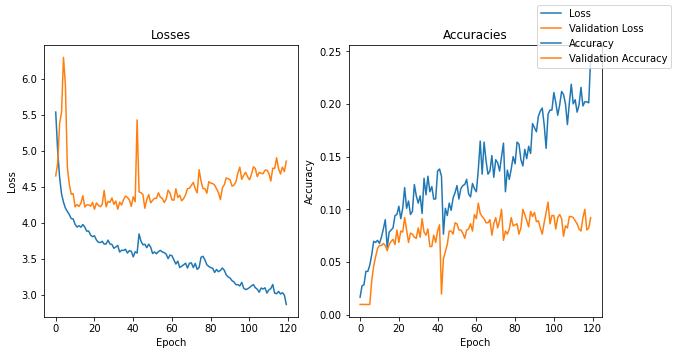

In [5]:
history = {'loss': [5.536274, 4.993477, 4.632351, 4.400572, 4.284237, 4.202638, 4.155856, 4.11271, 4.056193, 4.051891, 3.975818, 3.9389, 3.957584, 3.937419, 3.974126, 3.938051, 3.881925, 3.883922, 3.826439, 3.805271, 3.816988, 3.759807, 3.727982, 3.72317, 3.741451, 3.702019, 3.703482, 3.75725, 3.703315, 3.697093, 3.643899, 3.663211, 3.682113, 3.591743, 3.616124, 3.615262, 3.630246, 3.577754, 3.611365, 3.601992, 3.52517, 3.595528, 3.577371, 3.843477, 3.742067, 3.6928, 3.699981, 3.651918, 3.70134, 3.659356, 3.571108, 3.593341, 3.568048, 3.598187, 3.614367, 3.591824, 3.584394, 3.562167, 3.500552, 3.551227, 3.539699, 3.481599, 3.424394, 3.465747, 3.377347, 3.39496, 3.414252, 3.437029, 3.369815, 3.436349, 3.441375, 3.376668, 3.433643, 3.350498, 3.376273, 3.519964, 3.532763, 3.482932, 3.414901, 3.391872, 3.374984, 3.366931, 3.30829, 3.349404, 3.318717, 3.33672, 3.370087, 3.337354, 3.275119, 3.245677, 3.229227, 3.193479, 3.175446, 3.138577, 3.1386, 3.120887, 3.170035, 3.090143, 3.070039, 3.080594, 3.098392, 3.120902, 3.139442, 3.097104, 3.075296, 3.033009, 3.091186, 3.077903, 3.094802, 3.021253, 3.066143, 3.083349, 3.140977, 3.019323, 3.01302, 3.044597, 3.008937, 3.026612, 2.994068, 2.863598], 'accuracy': [0.016667, 0.027451, 0.028431, 0.041176, 0.041176, 0.047059, 0.056863, 0.069608, 0.068627, 0.070588, 0.067647, 0.073529, 0.081373, 0.090196, 0.063725, 0.078431, 0.080392, 0.082353, 0.094118, 0.095098, 0.102941, 0.091176, 0.10098, 0.120588, 0.10098, 0.107843, 0.095098, 0.098039, 0.123529, 0.112745, 0.105882, 0.112745, 0.096078, 0.129412, 0.113725, 0.131373, 0.116667, 0.121569, 0.109804, 0.109804, 0.136275, 0.138235, 0.131373, 0.076471, 0.10098, 0.094118, 0.105882, 0.09902, 0.110784, 0.115686, 0.122549, 0.109804, 0.119608, 0.122549, 0.123529, 0.128431, 0.114706, 0.111765, 0.12451, 0.119608, 0.116667, 0.137255, 0.164706, 0.133333, 0.163725, 0.146078, 0.133333, 0.136275, 0.15098, 0.130392, 0.147059, 0.144118, 0.136275, 0.15, 0.162745, 0.116667, 0.137255, 0.128431, 0.138235, 0.15, 0.143137, 0.163725, 0.161765, 0.147059, 0.141176, 0.156863, 0.148039, 0.159804, 0.152941, 0.181373, 0.177451, 0.173529, 0.188235, 0.193137, 0.196078, 0.180392, 0.157843, 0.190196, 0.194118, 0.194118, 0.210784, 0.20098, 0.189216, 0.19902, 0.211765, 0.208824, 0.2, 0.180392, 0.20098, 0.218627, 0.2, 0.203922, 0.192157, 0.19902, 0.215686, 0.198039, 0.201961, 0.201961, 0.20098, 0.244118], 'val_loss': [4.650072, 4.825594, 5.38053, 5.530797, 6.296842, 5.908079, 4.766269, 4.534273, 4.395364, 4.403523, 4.219553, 4.250991, 4.225577, 4.269758, 4.373871, 4.218633, 4.247396, 4.246975, 4.228945, 4.280674, 4.18603, 4.274776, 4.241843, 4.220643, 4.255244, 4.447372, 4.219778, 4.295826, 4.281943, 4.343822, 4.254745, 4.300503, 4.187218, 4.284276, 4.24587, 4.320876, 4.369665, 4.350195, 4.317116, 4.226509, 4.360094, 4.290666, 5.427366, 4.427502, 4.417524, 4.390625, 4.200261, 4.322777, 4.390047, 4.275359, 4.310504, 4.337167, 4.338964, 4.415094, 4.352321, 4.336462, 4.280568, 4.326277, 4.45149, 4.410202, 4.316596, 4.312085, 4.470498, 4.349976, 4.381222, 4.30409, 4.334014, 4.386824, 4.472154, 4.47881, 4.51754, 4.559649, 4.471919, 4.413827, 4.735658, 4.579099, 4.472845, 4.472551, 4.409549, 4.569163, 4.549353, 4.54307, 4.522135, 4.469812, 4.416013, 4.320113, 4.484236, 4.528025, 4.621921, 4.610322, 4.594408, 4.507814, 4.522683, 4.565703, 4.689722, 4.770717, 4.602601, 4.659383, 4.699421, 4.637835, 4.596123, 4.670212, 4.776459, 4.752884, 4.640412, 4.697469, 4.68671, 4.679582, 4.729327, 4.729766, 4.684772, 4.578316, 4.755779, 4.753884, 4.901177, 4.747099, 4.676806, 4.771779, 4.709968, 4.85527], 'val_accuracy': [0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.032353, 0.046078, 0.054902, 0.062745, 0.065686, 0.065686, 0.067647, 0.065686, 0.060784, 0.066667, 0.069608, 0.071569, 0.066667, 0.080392, 0.068627, 0.079412, 0.078431, 0.092157, 0.080392, 0.068627, 0.077451, 0.076471, 0.073529, 0.072549, 0.082353, 0.073529, 0.091176, 0.078431, 0.07549, 0.081373, 0.064706, 0.064706, 0.07549, 0.068627, 0.079412, 0.085294, 0.019608, 0.052941, 0.059804, 0.066667, 0.079412, 0.079412, 0.076471, 0.087255, 0.086275, 0.080392, 0.080392, 0.077451, 0.072549, 0.080392, 0.081373, 0.086275, 0.079412, 0.095098, 0.091176, 0.105882, 0.096078, 0.093137, 0.091176, 0.087255, 0.087255, 0.090196, 0.07549, 0.086275, 0.092157, 0.082353, 0.089216, 0.1, 0.070588, 0.079412, 0.076471, 0.081373, 0.092157, 0.084314, 0.085294, 0.086275, 0.076471, 0.082353, 0.1, 0.095098, 0.089216, 0.083333, 0.098039, 0.093137, 0.097059, 0.088235, 0.089216, 0.082353, 0.076471, 0.087255, 0.097059, 0.106863, 0.086275, 0.094118, 0.094118, 0.081373, 0.092157, 0.095098, 0.091176, 0.07451, 0.084314, 0.082353, 0.093137, 0.093137, 0.092157, 0.089216, 0.086275, 0.081373, 0.079412, 0.092157, 0.1, 0.080392, 0.082353, 0.092157]}

run_summary(history)

## Model 16
* depth=30, skips=[5, 8, 13, 21], skip_start_depth=10
* heat=1, chill=3, reheat=0, min_channels=32, max_channels=256

0.012745 | 0.010784


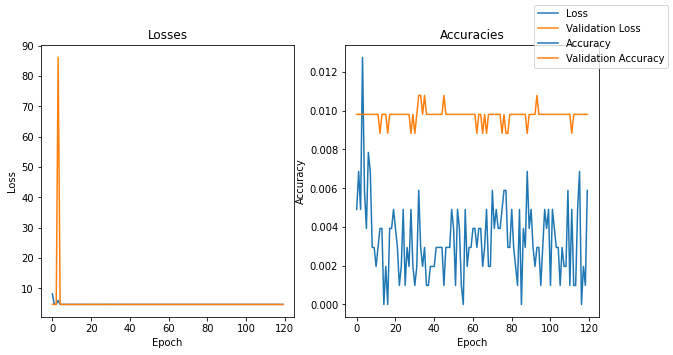

In [6]:
history = {'loss': [8.107353, 4.668014, 4.636436, 5.948383, 4.648056, 4.637525, 4.635263, 4.635285, 4.635172, 4.635009, 4.63535, 4.635157, 4.635493, 4.63595, 4.635153, 4.63538, 4.63552, 4.635382, 4.635445, 4.635191, 4.635669, 4.635463, 4.635111, 4.635412, 4.635711, 4.635271, 4.63484, 4.635444, 4.63556, 4.662135, 4.639126, 4.63572, 4.634955, 4.635171, 4.635461, 4.635015, 4.635457, 4.644987, 4.635242, 4.635611, 4.634885, 4.634888, 4.635121, 4.635246, 4.635407, 4.635383, 4.635422, 4.634939, 4.635337, 4.635571, 4.635543, 4.634747, 4.635523, 4.635196, 4.634825, 4.635035, 4.635637, 4.635323, 4.634748, 4.6356, 4.634761, 4.63524, 4.634982, 4.634934, 4.634642, 4.634482, 4.634912, 4.63518, 4.634826, 4.636244, 4.635141, 4.635348, 4.635082, 4.634567, 4.635418, 4.634493, 4.634676, 4.635731, 4.635341, 4.635173, 4.635612, 4.634902, 4.634915, 4.634991, 4.634633, 4.634897, 4.634834, 4.635208, 4.634656, 4.635061, 4.634756, 4.634879, 4.635653, 4.63486, 4.634687, 4.634566, 4.634543, 4.635149, 4.634795, 4.63483, 4.6353, 4.635151, 4.635016, 4.634186, 4.634668, 4.634679, 4.635074, 4.634875, 4.635229, 4.634905, 4.635102, 4.63485, 4.634492, 4.635016, 4.635433, 4.635683, 4.634511, 4.634597, 4.634397, 4.634914], 'accuracy': [0.004902, 0.006863, 0.004902, 0.012745, 0.005882, 0.003922, 0.007843, 0.006863, 0.002941, 0.002941, 0.001961, 0.002941, 0.003922, 0.003922, 0.0, 0.001961, 0.0, 0.003922, 0.003922, 0.004902, 0.003922, 0.002941, 0.00098, 0.001961, 0.004902, 0.00098, 0.002941, 0.001961, 0.004902, 0.001961, 0.00098, 0.001961, 0.005882, 0.002941, 0.001961, 0.002941, 0.00098, 0.00098, 0.001961, 0.001961, 0.001961, 0.002941, 0.002941, 0.002941, 0.002941, 0.00098, 0.002941, 0.002941, 0.002941, 0.004902, 0.003922, 0.00098, 0.004902, 0.003922, 0.00098, 0.0, 0.004902, 0.001961, 0.002941, 0.002941, 0.003922, 0.003922, 0.002941, 0.003922, 0.003922, 0.001961, 0.002941, 0.004902, 0.001961, 0.001961, 0.005882, 0.003922, 0.004902, 0.003922, 0.003922, 0.004902, 0.005882, 0.005882, 0.002941, 0.002941, 0.004902, 0.002941, 0.001961, 0.00098, 0.004902, 0.0, 0.003922, 0.002941, 0.006863, 0.003922, 0.004902, 0.002941, 0.001961, 0.002941, 0.002941, 0.00098, 0.002941, 0.004902, 0.003922, 0.004902, 0.00098, 0.004902, 0.003922, 0.002941, 0.002941, 0.00098, 0.002941, 0.001961, 0.001961, 0.005882, 0.00098, 0.004902, 0.00098, 0.00098, 0.004902, 0.006863, 0.0, 0.001961, 0.00098, 0.005882], 'val_loss': [4.683701, 4.625417, 4.625637, 86.119202, 4.810477, 4.625421, 4.62525, 4.625169, 4.625104, 4.625074, 4.62506, 4.625196, 4.625519, 4.626249, 4.625543, 4.626193, 4.626847, 4.626854, 4.628443, 4.629088, 4.628376, 4.630496, 4.625541, 4.628336, 4.626603, 4.627239, 4.626796, 4.630466, 4.629552, 4.636973, 4.626369, 4.625711, 4.625745, 4.625904, 4.628053, 4.628758, 4.627579, 4.624857, 4.624474, 4.62473, 4.624936, 4.62464, 4.624506, 4.624411, 4.624447, 4.624565, 4.62454, 4.624743, 4.624432, 4.624568, 4.624558, 4.624722, 4.624599, 4.624704, 4.624696, 4.624705, 4.624606, 4.624619, 4.624743, 4.62465, 4.624727, 4.624767, 4.62464, 4.624804, 4.624831, 4.624865, 4.624623, 4.624791, 4.624836, 4.624577, 4.62452, 4.624581, 4.624507, 4.624561, 4.6245, 4.624509, 4.62447, 4.624697, 4.625032, 4.624625, 4.624637, 4.624745, 4.624671, 4.624796, 4.624774, 4.624524, 4.624709, 4.624583, 4.624555, 4.624587, 4.624595, 4.624517, 4.62473, 4.624625, 4.624913, 4.624724, 4.624684, 4.62438, 4.624468, 4.624297, 4.624348, 4.624453, 4.624315, 4.624654, 4.6246, 4.624747, 4.62476, 4.624676, 4.624675, 4.624607, 4.624701, 4.624714, 4.624747, 4.624928, 4.624818, 4.624776, 4.624717, 4.624994, 4.625103, 4.624768], 'val_accuracy': [0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.008824, 0.009804, 0.009804, 0.009804, 0.008824, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.008824, 0.009804, 0.008824, 0.009804, 0.010784, 0.010784, 0.009804, 0.010784, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.010784, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.008824, 0.009804, 0.009804, 0.008824, 0.009804, 0.008824, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.008824, 0.009804, 0.008824, 0.008824, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.008824, 0.009804, 0.009804, 0.009804, 0.009804, 0.010784, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.008824, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804]}

run_summary(history)

## Model 17
* depth=30, skips=[], skip_start_depth=10, **kwargs
* heat=1, chill=3, reheat=0, min_channels=32, max_channels=256

0.955882 | 0.142157


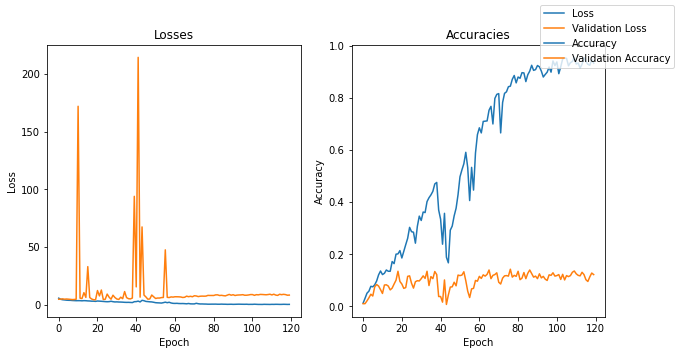

In [7]:
history = {'loss': [5.592106, 4.612902, 4.245629, 4.06916, 3.856554, 3.759481, 3.722899, 3.574567, 3.48276, 3.411261, 3.436161, 3.436061, 3.29543, 3.456244, 3.379206, 3.222725, 3.154624, 2.991542, 2.982483, 2.82044, 3.128771, 3.029031, 2.901202, 2.763915, 2.612958, 2.514657, 2.594712, 2.919304, 2.547246, 2.317412, 2.387638, 2.260883, 2.216465, 2.133602, 2.003903, 1.944303, 1.983049, 1.885635, 1.77446, 2.536668, 2.612296, 3.047676, 2.335273, 3.746856, 3.386025, 2.780627, 2.628834, 2.436891, 2.338678, 2.040129, 1.677808, 1.565296, 1.483537, 1.350093, 1.704273, 2.138779, 1.676432, 2.048523, 1.423669, 1.110796, 1.045256, 1.121861, 0.954032, 0.909774, 0.946325, 0.849194, 0.715212, 0.980918, 0.669546, 0.628935, 0.629466, 1.146807, 0.771122, 0.568736, 0.585025, 0.506885, 0.481744, 0.374422, 0.377425, 0.418483, 0.411067, 0.434504, 0.342491, 0.340964, 0.434478, 0.35058, 0.34071, 0.250875, 0.29069, 0.337342, 0.239547, 0.285361, 0.339848, 0.383174, 0.337414, 0.308875, 0.293171, 0.341626, 0.196426, 0.249877, 0.23378, 0.357634, 0.267125, 0.173068, 0.181366, 0.153944, 0.270974, 0.222735, 0.194589, 0.15399, 0.241931, 0.209706, 0.280175, 0.255386, 0.193086, 0.209364, 0.293138, 0.251459, 0.182298, 0.211749], 'accuracy': [0.011765, 0.030392, 0.05, 0.057843, 0.076471, 0.07451, 0.082353, 0.097059, 0.120588, 0.135294, 0.121569, 0.126471, 0.139216, 0.134314, 0.134314, 0.171569, 0.163725, 0.2, 0.20098, 0.213725, 0.185294, 0.210784, 0.236275, 0.260784, 0.302941, 0.286275, 0.284314, 0.242157, 0.306863, 0.346078, 0.329412, 0.361765, 0.359804, 0.401961, 0.416667, 0.427451, 0.441176, 0.469608, 0.47549, 0.369608, 0.334314, 0.238235, 0.356863, 0.188235, 0.166667, 0.292157, 0.307843, 0.347059, 0.376471, 0.428431, 0.497059, 0.523529, 0.547059, 0.591176, 0.532353, 0.405882, 0.533333, 0.446078, 0.588235, 0.658824, 0.685294, 0.665686, 0.709804, 0.710784, 0.711765, 0.752941, 0.767647, 0.7, 0.798039, 0.813725, 0.816667, 0.665686, 0.782353, 0.817647, 0.823529, 0.843137, 0.845098, 0.871569, 0.886275, 0.857843, 0.880392, 0.87549, 0.897059, 0.896078, 0.862745, 0.889216, 0.902941, 0.92549, 0.905882, 0.908824, 0.92451, 0.919608, 0.902941, 0.880392, 0.890196, 0.89902, 0.918627, 0.89902, 0.942157, 0.92451, 0.938235, 0.893137, 0.919608, 0.95, 0.953922, 0.951961, 0.923529, 0.935294, 0.940196, 0.955882, 0.930392, 0.934314, 0.914706, 0.929412, 0.954902, 0.940196, 0.929412, 0.92549, 0.948039, 0.933333], 'val_loss': [4.658133, 4.739519, 5.006958, 4.696227, 4.865866, 4.723618, 4.557548, 4.390136, 4.459458, 4.682786, 172.02124, 5.611772, 5.257137, 10.381396, 6.259373, 32.954273, 6.179713, 4.851186, 4.265794, 4.191954, 12.218324, 7.546309, 12.663316, 4.43459, 4.64685, 9.124617, 6.451657, 4.696491, 8.173133, 6.153766, 4.876655, 4.499529, 6.446455, 5.149163, 11.323174, 6.093146, 5.148079, 4.958189, 5.712851, 93.914581, 15.381338, 214.449066, 6.470473, 67.390175, 8.284958, 6.641525, 4.705769, 4.910334, 8.316898, 6.787944, 5.316938, 5.720865, 5.695783, 6.095757, 6.199803, 47.502476, 6.321078, 6.14014, 6.695528, 6.511611, 6.823812, 6.815316, 6.759239, 6.626575, 6.198578, 6.38989, 7.346974, 6.869823, 7.223507, 6.832352, 7.682318, 7.509385, 6.963733, 7.282256, 7.380098, 7.316401, 7.388378, 8.009515, 7.936806, 7.935128, 7.927566, 8.460303, 8.478038, 7.900926, 8.075174, 7.784445, 7.583346, 8.23074, 8.855562, 8.162069, 8.587874, 7.918191, 8.257031, 8.374498, 8.423062, 8.621605, 8.133873, 8.169545, 8.387053, 8.720013, 8.71155, 8.050611, 8.643885, 8.468121, 8.847361, 8.785559, 8.657656, 8.544936, 8.726389, 9.010827, 8.416876, 9.027211, 8.279429, 8.003911, 8.994015, 8.625094, 8.929731, 8.707896, 8.163895, 8.257979], 'val_accuracy': [0.009804, 0.009804, 0.020588, 0.032353, 0.046078, 0.039216, 0.07451, 0.083333, 0.077451, 0.063725, 0.04902, 0.081373, 0.082353, 0.077451, 0.062745, 0.069608, 0.085294, 0.1, 0.134314, 0.095098, 0.085294, 0.068627, 0.071569, 0.114706, 0.116667, 0.088235, 0.069608, 0.094118, 0.098039, 0.097059, 0.105882, 0.116667, 0.106863, 0.134314, 0.079412, 0.113725, 0.105882, 0.133333, 0.121569, 0.037255, 0.037255, 0.015686, 0.10098, 0.006863, 0.043137, 0.073529, 0.07451, 0.092157, 0.078431, 0.119608, 0.117647, 0.119608, 0.132353, 0.098039, 0.057843, 0.033333, 0.066667, 0.068627, 0.09902, 0.096078, 0.114706, 0.106863, 0.120588, 0.115686, 0.122549, 0.139216, 0.105882, 0.118627, 0.121569, 0.128431, 0.092157, 0.085294, 0.107843, 0.116667, 0.117647, 0.115686, 0.142157, 0.111765, 0.118627, 0.114706, 0.134314, 0.101961, 0.107843, 0.129412, 0.105882, 0.126471, 0.139216, 0.12549, 0.111765, 0.115686, 0.105882, 0.12451, 0.108824, 0.114706, 0.103922, 0.09902, 0.120588, 0.118627, 0.128431, 0.115686, 0.117647, 0.121569, 0.102941, 0.122549, 0.10098, 0.117647, 0.113725, 0.117647, 0.130392, 0.135294, 0.12451, 0.118627, 0.116667, 0.130392, 0.121569, 0.101961, 0.095098, 0.112745, 0.127451, 0.121569]}

run_summary(history)

0.094118 | 0.019608


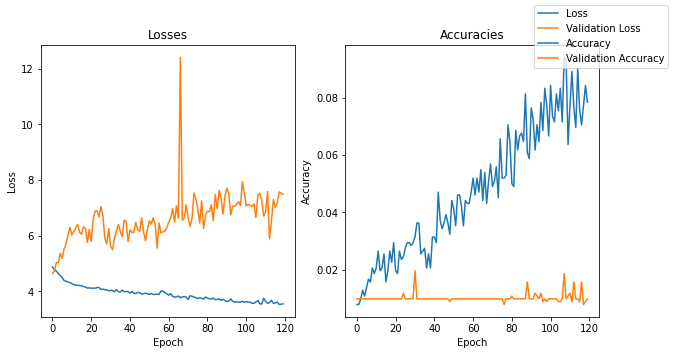

In [8]:
history = {'loss': [4.871417, 4.771596, 4.723434, 4.643519, 4.556887, 4.501026, 4.383354, 4.365506, 4.327738, 4.315321, 4.273868, 4.243465, 4.217766, 4.214127, 4.209206, 4.195657, 4.16769, 4.15327, 4.115177, 4.122167, 4.113773, 4.112818, 4.11344, 4.133971, 4.138291, 4.064088, 4.078293, 4.056037, 4.056769, 4.014827, 4.037381, 4.026498, 3.984112, 4.059134, 3.988096, 3.973626, 4.040638, 3.985075, 3.991102, 3.993538, 3.933818, 3.994849, 3.92111, 3.925516, 3.957804, 3.95215, 3.898625, 3.90997, 3.932093, 3.91096, 3.889164, 3.919622, 3.890255, 3.886805, 3.896146, 3.887223, 4.007841, 4.004412, 3.955366, 3.903688, 3.860383, 3.917065, 3.818202, 3.78963, 3.804612, 3.826782, 3.769608, 3.798153, 3.812695, 3.790601, 3.705191, 3.841148, 3.823512, 3.791054, 3.771092, 3.737417, 3.768944, 3.746271, 3.720238, 3.795049, 3.756722, 3.728386, 3.732321, 3.754666, 3.698235, 3.707903, 3.731474, 3.66897, 3.715488, 3.667234, 3.633199, 3.652515, 3.72405, 3.641031, 3.610712, 3.621687, 3.612502, 3.606526, 3.638023, 3.607559, 3.627126, 3.605467, 3.603972, 3.571634, 3.565548, 3.621187, 3.66445, 3.555748, 3.542195, 3.746808, 3.639762, 3.568217, 3.594761, 3.676035, 3.567914, 3.585137, 3.617995, 3.527932, 3.534631, 3.548791], 'accuracy': [0.007843, 0.007843, 0.009804, 0.012745, 0.010784, 0.013725, 0.016667, 0.015686, 0.020588, 0.018627, 0.020588, 0.026471, 0.019608, 0.020588, 0.02549, 0.015686, 0.019608, 0.026471, 0.022549, 0.029412, 0.019608, 0.018627, 0.026471, 0.023529, 0.02451, 0.027451, 0.029412, 0.029412, 0.028431, 0.029412, 0.031373, 0.036275, 0.036275, 0.02549, 0.026471, 0.027451, 0.020588, 0.02549, 0.020588, 0.031373, 0.031373, 0.029412, 0.047059, 0.037255, 0.034314, 0.036275, 0.039216, 0.036275, 0.032353, 0.044118, 0.041176, 0.035294, 0.046078, 0.046078, 0.042157, 0.035294, 0.044118, 0.043137, 0.043137, 0.047059, 0.051961, 0.046078, 0.051961, 0.047059, 0.054902, 0.044118, 0.053922, 0.043137, 0.05098, 0.056863, 0.04902, 0.05098, 0.055882, 0.045098, 0.065686, 0.051961, 0.051961, 0.052941, 0.070588, 0.064706, 0.05, 0.04902, 0.068627, 0.061765, 0.066667, 0.067647, 0.064706, 0.081373, 0.060784, 0.058824, 0.076471, 0.072549, 0.061765, 0.070588, 0.064706, 0.078431, 0.068627, 0.083333, 0.077451, 0.066667, 0.084314, 0.073529, 0.071569, 0.081373, 0.07549, 0.083333, 0.071569, 0.094118, 0.093137, 0.063725, 0.077451, 0.089216, 0.076471, 0.069608, 0.090196, 0.07549, 0.070588, 0.077451, 0.084314, 0.078431], 'val_loss': [4.635621, 4.730699, 5.02878, 5.032125, 5.360426, 5.185587, 5.527984, 5.695534, 6.017393, 6.293448, 6.035131, 6.140839, 6.276914, 6.40065, 6.120183, 6.049806, 6.317244, 6.252729, 5.757877, 6.225894, 5.788705, 6.59946, 6.878463, 6.88942, 6.670075, 7.042904, 6.725554, 5.909064, 5.700595, 6.250113, 5.614655, 5.494224, 5.916559, 6.154147, 6.401573, 6.14586, 5.965441, 6.549826, 6.511126, 5.785333, 6.199446, 6.118809, 6.109448, 6.479402, 6.20494, 6.154323, 6.639084, 6.13592, 5.816686, 6.228883, 6.525671, 6.411066, 6.644239, 6.421186, 5.551446, 6.455317, 6.093859, 6.139711, 6.166828, 6.282398, 6.485676, 6.613594, 6.968403, 6.490037, 7.066725, 6.620941, 12.401568, 6.553042, 6.625939, 7.104714, 6.63432, 6.33031, 6.614089, 7.530832, 7.330595, 6.955163, 6.453693, 7.246184, 6.254165, 6.742824, 6.878531, 6.85371, 7.111371, 6.529348, 7.471056, 6.960398, 7.628593, 7.338476, 6.775371, 7.418896, 7.700958, 7.483903, 6.743991, 7.06092, 7.059511, 7.114539, 7.217972, 7.081222, 7.935441, 7.537908, 7.068865, 7.124509, 7.095052, 7.051364, 7.132998, 6.647169, 7.448406, 7.509088, 7.258332, 6.701801, 6.858512, 7.583062, 5.887032, 6.515583, 7.299222, 7.011821, 7.173452, 7.573843, 7.524117, 7.480108], 'val_accuracy': [0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.011765, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.019608, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.008824, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.007843, 0.009804, 0.009804, 0.009804, 0.010784, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.015686, 0.009804, 0.009804, 0.009804, 0.011765, 0.010784, 0.009804, 0.011765, 0.008824, 0.009804, 0.008824, 0.009804, 0.009804, 0.009804, 0.009804, 0.009804, 0.008824, 0.008824, 0.009804, 0.018627, 0.009804, 0.010784, 0.011765, 0.008824, 0.015686, 0.009804, 0.009804, 0.008824, 0.015686, 0.007843, 0.008824, 0.009804]}

run_summary(history)

## Model 21
* depth=4, skips=[], skip_start_depth=10
* heat=1, chill=0, reheat=0, min_channels=32, max_channels=256

0.976471 | 0.32549


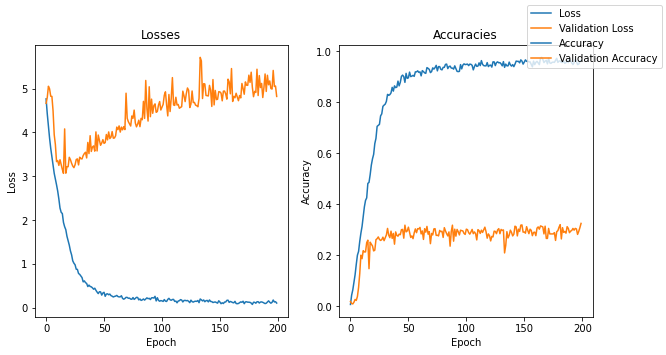

In [9]:
history = {'loss': [4.765802, 4.425703, 4.136488, 3.869751, 3.636682, 3.450625, 3.24889, 3.068028, 2.942689, 2.806835, 2.664817, 2.485176, 2.276671, 2.180214, 2.151277, 1.948001, 1.851021, 1.783639, 1.633613, 1.530584, 1.431531, 1.300159, 1.209825, 1.073298, 1.019184, 0.983737, 0.882912, 0.878259, 0.78546, 0.764336, 0.728639, 0.691595, 0.594122, 0.615887, 0.57711, 0.556973, 0.486386, 0.520386, 0.48891, 0.480769, 0.457463, 0.426442, 0.449361, 0.401239, 0.361126, 0.326616, 0.368456, 0.365593, 0.292365, 0.339688, 0.356215, 0.264637, 0.315745, 0.321781, 0.300284, 0.315303, 0.280299, 0.267556, 0.249258, 0.261966, 0.269154, 0.284833, 0.259246, 0.250976, 0.252988, 0.277313, 0.217005, 0.199029, 0.214687, 0.240948, 0.238871, 0.219542, 0.223493, 0.20119, 0.197697, 0.236162, 0.194564, 0.216122, 0.241711, 0.237827, 0.183108, 0.203843, 0.171632, 0.182967, 0.203835, 0.178708, 0.204619, 0.229021, 0.210884, 0.218332, 0.190559, 0.230033, 0.231718, 0.225167, 0.263713, 0.159381, 0.232042, 0.171743, 0.152496, 0.16701, 0.160849, 0.147555, 0.190097, 0.154614, 0.147723, 0.193908, 0.218524, 0.185011, 0.174022, 0.192041, 0.193577, 0.148992, 0.155588, 0.116513, 0.157096, 0.164184, 0.18883, 0.179649, 0.136311, 0.169123, 0.172259, 0.163274, 0.169735, 0.150301, 0.119925, 0.176939, 0.143816, 0.1321, 0.147719, 0.152881, 0.149211, 0.16966, 0.119905, 0.203835, 0.183754, 0.159781, 0.180658, 0.14149, 0.164321, 0.171031, 0.137759, 0.181314, 0.146709, 0.143602, 0.122733, 0.131349, 0.135551, 0.121046, 0.108965, 0.162342, 0.135062, 0.096468, 0.11642, 0.100729, 0.133115, 0.135303, 0.172515, 0.176191, 0.126684, 0.147547, 0.136697, 0.122292, 0.116739, 0.149753, 0.099556, 0.096067, 0.100973, 0.119076, 0.138347, 0.1281, 0.152304, 0.095773, 0.136672, 0.139712, 0.131009, 0.130907, 0.126247, 0.110722, 0.079135, 0.129106, 0.127414, 0.107225, 0.13951, 0.141106, 0.111584, 0.13363, 0.136819, 0.127692, 0.112355, 0.09886, 0.107485, 0.133406, 0.161163, 0.129845, 0.107649, 0.126415, 0.180177, 0.136445, 0.142075, 0.110853], 'accuracy': [0.007843, 0.044118, 0.064706, 0.096078, 0.12451, 0.164706, 0.20098, 0.215686, 0.254902, 0.287255, 0.313726, 0.351961, 0.390196, 0.415686, 0.42549, 0.482353, 0.486275, 0.516667, 0.553922, 0.578431, 0.596078, 0.638235, 0.658824, 0.705882, 0.709804, 0.713726, 0.747059, 0.754902, 0.784314, 0.789216, 0.793137, 0.803922, 0.831373, 0.827451, 0.830392, 0.837255, 0.858824, 0.844118, 0.864706, 0.857843, 0.859804, 0.883333, 0.864706, 0.878431, 0.901961, 0.906863, 0.90098, 0.878431, 0.913725, 0.894118, 0.896078, 0.918627, 0.90098, 0.902941, 0.905882, 0.901961, 0.919608, 0.919608, 0.923529, 0.917647, 0.919608, 0.903922, 0.92451, 0.920588, 0.915686, 0.913725, 0.936275, 0.933333, 0.929412, 0.916667, 0.920588, 0.935294, 0.930392, 0.936275, 0.945098, 0.923529, 0.940196, 0.940196, 0.929412, 0.927451, 0.937255, 0.937255, 0.94902, 0.95, 0.932353, 0.940196, 0.942157, 0.934314, 0.934314, 0.930392, 0.943137, 0.932353, 0.921569, 0.920588, 0.921569, 0.948039, 0.931373, 0.946078, 0.95098, 0.948039, 0.94902, 0.95, 0.944118, 0.95, 0.94902, 0.945098, 0.927451, 0.940196, 0.95, 0.941176, 0.942157, 0.954902, 0.944118, 0.963726, 0.94902, 0.944118, 0.943137, 0.943137, 0.955882, 0.940196, 0.945098, 0.946078, 0.938235, 0.958824, 0.958824, 0.944118, 0.955882, 0.958824, 0.954902, 0.955882, 0.95098, 0.943137, 0.959804, 0.937255, 0.95, 0.943137, 0.943137, 0.957843, 0.947059, 0.942157, 0.948039, 0.940196, 0.95, 0.961765, 0.960784, 0.960784, 0.954902, 0.966667, 0.961765, 0.95, 0.957843, 0.966667, 0.960784, 0.961765, 0.958824, 0.958824, 0.94902, 0.939216, 0.961765, 0.948039, 0.956863, 0.960784, 0.954902, 0.948039, 0.972549, 0.976471, 0.968627, 0.955882, 0.961765, 0.964706, 0.95098, 0.972549, 0.954902, 0.952941, 0.956863, 0.957843, 0.956863, 0.964706, 0.972549, 0.956863, 0.961765, 0.962745, 0.956863, 0.956863, 0.961765, 0.952941, 0.955882, 0.963726, 0.955882, 0.968627, 0.962745, 0.954902, 0.948039, 0.955882, 0.968627, 0.961765, 0.948039, 0.95, 0.959804, 0.964706], 'val_loss': [4.665627, 4.798496, 5.053766, 4.994207, 4.825804, 4.822445, 4.494781, 3.95056, 3.725579, 3.335633, 3.360046, 3.249899, 3.378824, 3.26611, 3.158168, 3.067511, 4.081254, 3.071954, 3.218579, 3.219889, 3.434288, 3.379752, 3.298071, 3.234799, 3.197475, 3.26453, 3.382403, 3.397817, 3.260718, 3.436249, 3.40278, 3.397059, 3.474327, 3.519817, 3.548851, 3.419486, 3.772789, 3.519089, 3.926754, 3.567187, 3.668505, 3.693625, 3.574338, 4.013466, 3.578656, 3.94171, 3.818941, 3.707945, 3.759488, 3.836362, 3.751241, 3.769942, 3.954074, 3.831346, 4.012273, 3.860865, 3.89338, 4.020297, 3.86963, 3.87449, 3.926366, 4.122601, 4.064499, 4.149813, 4.009151, 4.122061, 4.059978, 4.133406, 4.065438, 4.895527, 4.321489, 4.244752, 4.197627, 4.147363, 4.376058, 4.324495, 4.510107, 4.218232, 4.128907, 4.190202, 4.279868, 4.132854, 4.32134, 4.290672, 4.708981, 4.320719, 5.185891, 4.546227, 4.260256, 5.042241, 4.360182, 4.76002, 4.437458, 4.613796, 4.652633, 4.459613, 4.478216, 4.624685, 4.705202, 4.512159, 4.578448, 4.640225, 4.847307, 4.927193, 4.62622, 4.377595, 4.866454, 4.477175, 4.775986, 5.251085, 4.627407, 4.616735, 4.802859, 4.626177, 4.639294, 4.552019, 4.572721, 4.587058, 4.942373, 4.835895, 4.703976, 4.884261, 5.014503, 4.96358, 4.568636, 4.64912, 4.946054, 4.681896, 4.686574, 4.623598, 4.611346, 4.586891, 4.780919, 5.712831, 5.630751, 4.774338, 5.113525, 5.10364, 4.843925, 4.839741, 4.832702, 5.074032, 4.961746, 4.594114, 5.206496, 4.628717, 4.958242, 4.749491, 4.758027, 4.929844, 4.92554, 4.896495, 4.72165, 4.942184, 4.944532, 4.879723, 4.759696, 5.215583, 5.151818, 4.881415, 5.457418, 4.706909, 4.822213, 4.791773, 4.894245, 4.812821, 4.724705, 4.842482, 4.788858, 5.117124, 5.002311, 4.871784, 5.153256, 5.078046, 5.075184, 5.307124, 5.141577, 5.374331, 5.031478, 4.816, 4.937664, 4.911917, 5.442145, 4.843052, 5.296882, 5.024219, 5.118175, 4.797073, 5.026055, 5.333972, 4.935747, 5.304482, 5.087999, 5.174645, 5.002006, 4.989593, 5.414513, 5.048543, 5.058966, 4.822118], 'val_accuracy': [0.019608, 0.011765, 0.009804, 0.016667, 0.027451, 0.023529, 0.039216, 0.07451, 0.128431, 0.20098, 0.187255, 0.218627, 0.213725, 0.213725, 0.25, 0.259804, 0.148039, 0.251961, 0.244118, 0.237255, 0.217647, 0.220588, 0.261765, 0.265686, 0.272549, 0.262745, 0.258824, 0.261765, 0.271569, 0.257843, 0.269608, 0.280392, 0.305882, 0.279412, 0.269608, 0.295098, 0.266667, 0.286275, 0.244118, 0.292157, 0.278431, 0.27549, 0.283333, 0.281373, 0.30098, 0.301961, 0.267647, 0.318627, 0.292157, 0.296078, 0.310784, 0.291176, 0.270588, 0.276471, 0.265686, 0.288235, 0.303922, 0.289216, 0.304902, 0.303922, 0.309804, 0.284314, 0.296078, 0.262745, 0.304902, 0.291176, 0.313726, 0.283333, 0.293137, 0.246078, 0.286275, 0.280392, 0.303922, 0.304902, 0.278431, 0.279412, 0.276471, 0.298039, 0.293137, 0.295098, 0.270588, 0.308824, 0.296078, 0.285294, 0.276471, 0.292157, 0.236275, 0.294118, 0.318627, 0.255882, 0.302941, 0.27549, 0.301961, 0.293137, 0.280392, 0.29902, 0.297059, 0.296078, 0.286275, 0.282353, 0.302941, 0.30098, 0.289216, 0.283333, 0.292157, 0.301961, 0.285294, 0.292157, 0.285294, 0.260784, 0.30098, 0.297059, 0.286275, 0.29902, 0.290196, 0.30098, 0.310784, 0.293137, 0.267647, 0.284314, 0.277451, 0.256863, 0.27451, 0.272549, 0.295098, 0.294118, 0.285294, 0.3, 0.304902, 0.285294, 0.301961, 0.298039, 0.3, 0.209804, 0.239216, 0.293137, 0.268627, 0.279412, 0.29902, 0.290196, 0.276471, 0.283333, 0.314706, 0.311765, 0.276471, 0.302941, 0.294118, 0.318627, 0.319608, 0.291176, 0.292157, 0.287255, 0.312745, 0.298039, 0.285294, 0.302941, 0.298039, 0.277451, 0.290196, 0.291176, 0.277451, 0.306863, 0.311765, 0.302941, 0.315686, 0.313726, 0.311765, 0.284314, 0.314706, 0.266667, 0.266667, 0.305882, 0.284314, 0.284314, 0.284314, 0.284314, 0.289216, 0.258824, 0.293137, 0.297059, 0.310784, 0.320588, 0.264706, 0.308824, 0.290196, 0.294118, 0.287255, 0.312745, 0.305882, 0.289216, 0.295098, 0.298039, 0.305882, 0.29902, 0.305882, 0.303922, 0.282353, 0.294118, 0.308824, 0.32549]}

run_summary(history)

## Model 22
* depth=4, skips=[3], skip_start_depth=2
* heat=1, chill=0, reheat=0, min_channels=32, max_channels=256

0.896078 | 0.19902


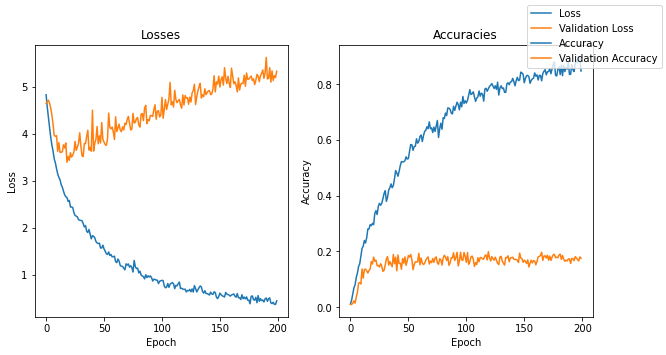

In [10]:
history = {'loss': [4.827141, 4.56281, 4.356138, 4.131297, 3.919278, 3.756835, 3.628788, 3.4635, 3.379064, 3.254295, 3.145828, 3.070816, 3.02098, 2.917529, 2.861798, 2.776776, 2.70101, 2.657694, 2.641558, 2.558731, 2.579864, 2.438574, 2.442115, 2.427737, 2.320088, 2.259438, 2.246041, 2.228629, 2.171344, 2.157561, 2.154099, 2.148007, 2.08924, 2.015587, 2.044984, 1.9243, 1.896896, 1.962463, 1.862312, 1.762352, 1.829557, 1.816532, 1.786978, 1.706634, 1.675121, 1.66083, 1.671115, 1.568088, 1.567914, 1.628695, 1.547852, 1.499316, 1.444154, 1.431993, 1.483676, 1.408237, 1.42954, 1.380216, 1.383109, 1.393606, 1.279393, 1.256235, 1.333803, 1.288978, 1.193553, 1.181277, 1.176265, 1.141236, 1.102548, 1.230497, 1.204682, 1.228797, 1.160551, 1.190373, 1.152947, 1.056317, 1.302686, 1.171458, 1.129608, 1.138365, 1.037643, 1.075257, 0.99248, 0.9726, 0.958023, 0.910719, 0.999005, 0.938343, 0.976487, 0.950545, 0.974544, 0.939103, 0.864933, 0.904337, 0.898482, 0.884624, 0.883768, 0.81046, 0.862001, 0.871731, 0.879384, 0.874914, 0.759648, 0.721353, 0.736747, 0.811988, 0.730963, 0.799119, 0.816848, 0.83271, 0.80329, 0.702886, 0.774274, 0.762328, 0.805651, 0.843741, 0.705287, 0.713131, 0.693823, 0.686181, 0.692443, 0.631839, 0.664679, 0.656722, 0.687357, 0.636233, 0.697002, 0.630737, 0.766542, 0.705967, 0.633666, 0.680271, 0.722946, 0.760091, 0.740664, 0.642004, 0.608006, 0.659875, 0.599922, 0.597275, 0.585351, 0.566937, 0.628487, 0.591476, 0.579687, 0.636583, 0.619017, 0.524177, 0.489411, 0.536238, 0.607054, 0.573296, 0.551804, 0.537709, 0.525997, 0.622514, 0.58616, 0.575323, 0.566005, 0.543914, 0.568274, 0.577935, 0.590605, 0.544068, 0.520669, 0.599059, 0.509452, 0.508078, 0.472856, 0.573561, 0.489631, 0.523756, 0.485408, 0.527649, 0.456918, 0.45914, 0.381314, 0.541132, 0.547536, 0.467997, 0.458648, 0.519298, 0.403245, 0.555972, 0.433582, 0.490901, 0.44845, 0.460738, 0.420083, 0.488785, 0.503905, 0.433348, 0.489239, 0.50719, 0.398041, 0.385036, 0.414123, 0.369619, 0.367088, 0.44424], 'accuracy': [0.011765, 0.02549, 0.048039, 0.069608, 0.080392, 0.106863, 0.122549, 0.146078, 0.155882, 0.182353, 0.210784, 0.218627, 0.239216, 0.230392, 0.24902, 0.280392, 0.280392, 0.296078, 0.292157, 0.30098, 0.296078, 0.336275, 0.346078, 0.332353, 0.360784, 0.372549, 0.365686, 0.372549, 0.389216, 0.407843, 0.417647, 0.379412, 0.394118, 0.420588, 0.428431, 0.442157, 0.428431, 0.436274, 0.460784, 0.490196, 0.481373, 0.469608, 0.487255, 0.507843, 0.522549, 0.520588, 0.521569, 0.52549, 0.539216, 0.531373, 0.533333, 0.559804, 0.583333, 0.582353, 0.562745, 0.576471, 0.577451, 0.603922, 0.588235, 0.595098, 0.612745, 0.617647, 0.594118, 0.614706, 0.630392, 0.634314, 0.647059, 0.640196, 0.664706, 0.640196, 0.643137, 0.626471, 0.646078, 0.630392, 0.65, 0.669608, 0.608824, 0.640196, 0.659804, 0.638235, 0.679412, 0.676471, 0.696078, 0.687255, 0.714706, 0.713726, 0.709804, 0.696078, 0.693137, 0.720588, 0.705882, 0.721569, 0.735294, 0.726471, 0.707843, 0.735294, 0.718627, 0.755882, 0.730392, 0.740196, 0.732353, 0.742157, 0.759804, 0.780392, 0.762745, 0.765686, 0.772549, 0.753922, 0.738235, 0.75, 0.754902, 0.77549, 0.756863, 0.767647, 0.763726, 0.739216, 0.782353, 0.785294, 0.77451, 0.783333, 0.792157, 0.796078, 0.801961, 0.793137, 0.784314, 0.794118, 0.781373, 0.806863, 0.760784, 0.786274, 0.794118, 0.784314, 0.786274, 0.770588, 0.770588, 0.80098, 0.804902, 0.798039, 0.807843, 0.808824, 0.820588, 0.809804, 0.794118, 0.811765, 0.82451, 0.812745, 0.814706, 0.843137, 0.840196, 0.835294, 0.804902, 0.820588, 0.830392, 0.831373, 0.826471, 0.802941, 0.813725, 0.818627, 0.821569, 0.840196, 0.828431, 0.833333, 0.814706, 0.831373, 0.831373, 0.811765, 0.838235, 0.846078, 0.851961, 0.833333, 0.844118, 0.845098, 0.855882, 0.837255, 0.854902, 0.869608, 0.879412, 0.831373, 0.829412, 0.853922, 0.861765, 0.834314, 0.868627, 0.830392, 0.867647, 0.845098, 0.859804, 0.853922, 0.878431, 0.835294, 0.835294, 0.869608, 0.851961, 0.845098, 0.876471, 0.883333, 0.876471, 0.896078, 0.892157, 0.847059], 'val_loss': [4.64173, 4.682305, 4.71227, 4.646257, 4.544908, 4.391193, 4.20047, 3.959508, 3.945776, 3.957477, 3.624654, 3.807947, 3.600814, 3.608642, 3.612184, 3.762551, 3.695376, 3.802253, 3.392348, 3.515712, 3.434105, 3.594613, 3.501024, 3.541099, 3.613803, 3.835828, 3.644294, 3.714646, 3.794587, 4.018315, 3.743017, 3.531252, 3.51261, 3.792866, 3.787065, 3.939685, 4.073068, 3.649978, 3.709349, 3.627394, 4.498772, 3.628612, 3.794061, 3.879219, 4.152781, 3.784541, 3.954013, 3.802514, 4.235007, 3.876244, 3.822597, 3.766673, 3.750564, 3.886775, 4.436375, 4.131654, 4.103871, 4.14077, 4.038251, 3.87549, 4.358374, 4.043965, 4.127295, 4.202302, 4.075429, 4.041008, 4.146458, 4.079492, 4.221845, 4.193811, 4.303424, 4.368077, 4.219231, 4.079128, 4.099042, 4.43167, 4.226112, 4.241165, 4.321485, 4.343378, 4.185924, 4.139509, 4.415087, 4.428259, 4.277427, 4.546555, 4.60283, 4.215548, 4.300313, 4.273489, 4.389257, 4.381527, 4.36482, 4.511266, 4.61506, 4.307689, 4.477815, 4.488895, 4.355718, 4.394697, 4.771336, 4.32734, 4.535381, 4.72458, 4.513364, 4.619261, 4.734628, 5.090412, 4.614018, 4.678804, 4.565462, 4.922328, 4.72733, 4.658251, 4.701639, 4.728079, 4.609523, 4.543146, 4.824745, 4.609752, 4.811177, 4.757236, 4.76297, 4.625244, 4.777911, 4.673152, 4.862387, 4.918112, 5.050512, 4.619946, 4.778518, 4.90854, 4.995984, 5.070333, 4.757738, 4.828002, 4.787056, 4.954843, 4.828258, 4.874029, 4.91113, 4.912934, 4.83124, 4.843857, 4.957571, 5.233062, 4.888095, 5.099985, 5.05715, 5.221432, 4.992119, 5.151477, 5.210765, 5.033463, 5.403187, 5.182581, 5.066461, 5.220603, 5.077764, 4.982269, 5.391845, 5.227829, 5.061342, 5.103676, 5.025475, 4.888852, 5.187236, 4.927723, 5.052068, 5.072529, 5.064571, 5.242447, 5.007095, 5.290495, 5.154612, 5.16145, 5.193032, 5.224468, 5.130614, 5.166015, 5.044544, 5.134326, 5.260113, 5.225777, 5.106769, 5.234573, 5.282064, 5.354243, 5.176922, 5.291261, 5.623223, 5.164971, 5.177016, 5.401754, 5.095049, 5.335778, 5.131989, 5.231545, 5.194269, 5.327464], 'val_accuracy': [0.009804, 0.009804, 0.014706, 0.022549, 0.014706, 0.036275, 0.052941, 0.086275, 0.088235, 0.083333, 0.137255, 0.103922, 0.135294, 0.136275, 0.130392, 0.122549, 0.131373, 0.137255, 0.163725, 0.154902, 0.179412, 0.164706, 0.168627, 0.14902, 0.15, 0.144118, 0.155882, 0.147059, 0.128431, 0.132353, 0.15098, 0.173529, 0.181373, 0.15098, 0.163725, 0.153922, 0.145098, 0.189216, 0.155882, 0.179412, 0.130392, 0.187255, 0.156863, 0.157843, 0.136275, 0.17451, 0.157843, 0.180392, 0.15, 0.166667, 0.185294, 0.179412, 0.189216, 0.170588, 0.134314, 0.152941, 0.162745, 0.161765, 0.162745, 0.193137, 0.151961, 0.176471, 0.157843, 0.152941, 0.156863, 0.168627, 0.17549, 0.180392, 0.154902, 0.165686, 0.159804, 0.17451, 0.160784, 0.176471, 0.180392, 0.158824, 0.153922, 0.173529, 0.170588, 0.15098, 0.176471, 0.186275, 0.179412, 0.167647, 0.181373, 0.15, 0.158824, 0.177451, 0.176471, 0.195098, 0.167647, 0.178431, 0.197059, 0.148039, 0.164706, 0.197059, 0.169608, 0.167647, 0.196078, 0.182353, 0.160784, 0.196078, 0.153922, 0.162745, 0.180392, 0.183333, 0.172549, 0.146078, 0.159804, 0.152941, 0.177451, 0.162745, 0.178431, 0.177451, 0.172549, 0.172549, 0.184314, 0.187255, 0.169608, 0.19902, 0.177451, 0.165686, 0.181373, 0.173529, 0.168627, 0.179412, 0.167647, 0.156863, 0.152941, 0.180392, 0.182353, 0.165686, 0.157843, 0.15098, 0.178431, 0.177451, 0.184314, 0.162745, 0.176471, 0.177451, 0.179412, 0.171569, 0.171569, 0.171569, 0.168627, 0.160784, 0.194118, 0.176471, 0.17451, 0.160784, 0.168627, 0.163725, 0.156863, 0.169608, 0.144118, 0.157843, 0.168627, 0.158824, 0.166667, 0.165686, 0.151961, 0.164706, 0.180392, 0.182353, 0.185294, 0.197059, 0.167647, 0.183333, 0.184314, 0.176471, 0.186275, 0.168627, 0.183333, 0.167647, 0.179412, 0.188235, 0.189216, 0.177451, 0.179412, 0.177451, 0.187255, 0.190196, 0.171569, 0.185294, 0.172549, 0.164706, 0.168627, 0.165686, 0.172549, 0.173529, 0.156863, 0.17451, 0.17451, 0.166667, 0.181373, 0.176471, 0.170588, 0.165686, 0.180392, 0.17549]}

run_summary(history)

## Model 23
* Conv Regularization
* depth=4, skips=[3], skip_start_depth=2
* heat=1, chill=0, reheat=0, min_channels=32, max_channels=256

0.42451 | 0.130392


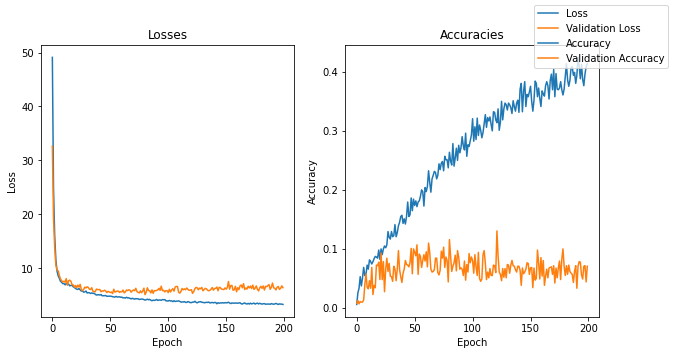

In [11]:
history = {'loss': [49.104721, 24.87986, 16.134159, 11.68598, 9.52824, 8.634175, 8.190426, 7.614496, 7.42422, 7.173654, 7.187287, 6.949512, 7.205857, 7.012407, 7.082625, 6.765669, 6.841861, 6.864913, 6.598016, 6.443743, 6.288712, 6.142435, 6.091511, 6.276022, 6.016098, 5.794619, 5.804699, 5.592471, 5.629683, 5.803282, 5.440473, 5.507003, 5.47493, 5.346219, 5.44811, 5.358766, 5.401378, 5.208525, 5.060342, 5.099902, 5.117173, 5.052561, 5.150834, 4.927332, 4.92526, 4.937878, 4.971519, 4.830443, 4.835747, 4.829517, 4.854571, 4.821264, 4.750608, 4.70595, 4.679461, 4.809733, 4.683468, 4.716214, 4.724179, 4.649232, 4.667129, 4.53315, 4.555341, 4.509916, 4.644814, 4.521854, 4.537756, 4.436037, 4.344967, 4.461193, 4.364965, 4.298751, 4.391771, 4.361638, 4.36834, 4.23615, 4.266584, 4.31463, 4.303538, 4.206004, 4.124215, 4.192389, 4.296259, 4.176543, 4.257983, 4.103611, 4.00464, 4.110946, 4.056879, 4.126235, 4.239719, 4.057762, 4.141536, 4.133103, 4.085115, 4.214715, 4.190412, 4.213572, 4.005154, 3.954551, 3.960246, 4.052332, 3.949003, 3.980746, 3.843508, 3.999296, 3.859065, 3.928994, 3.921986, 3.973121, 3.888718, 3.740782, 3.792915, 3.768756, 3.846401, 3.696232, 3.70242, 3.843573, 3.76943, 3.655286, 3.656454, 3.745739, 3.731827, 3.906515, 3.709942, 3.608725, 3.756242, 3.78921, 3.828837, 3.710782, 3.699781, 3.63533, 3.657576, 3.715962, 3.689611, 3.752455, 3.588326, 3.650049, 3.685345, 3.609477, 3.675416, 3.677194, 3.443113, 3.636504, 3.54423, 3.60205, 3.59527, 3.628364, 3.587258, 3.632529, 3.623526, 3.627384, 3.731908, 3.586498, 3.476549, 3.587832, 3.57045, 3.546904, 3.58894, 3.574628, 3.546902, 3.592957, 3.617288, 3.437764, 3.403316, 3.51432, 3.603571, 3.455593, 3.394305, 3.515828, 3.392769, 3.550659, 3.411847, 3.484361, 3.565182, 3.387393, 3.494948, 3.555285, 3.409401, 3.531137, 3.438098, 3.379324, 3.451039, 3.46839, 3.352267, 3.390315, 3.395953, 3.386534, 3.355715, 3.462447, 3.399327, 3.361608, 3.414135, 3.504418, 3.402439, 3.315898, 3.41845, 3.381543, 3.374772, 3.319225], 'accuracy': [0.005882, 0.02549, 0.033333, 0.052941, 0.037255, 0.05098, 0.068627, 0.054902, 0.056863, 0.072549, 0.065686, 0.081373, 0.078431, 0.07451, 0.078431, 0.083333, 0.087255, 0.086275, 0.084314, 0.098039, 0.082353, 0.1, 0.090196, 0.1, 0.104902, 0.101961, 0.106863, 0.129412, 0.119608, 0.116667, 0.129412, 0.120588, 0.122549, 0.141176, 0.120588, 0.127451, 0.139216, 0.145098, 0.154902, 0.156863, 0.143137, 0.15098, 0.142157, 0.154902, 0.179412, 0.154902, 0.157843, 0.186275, 0.164706, 0.184314, 0.173529, 0.181373, 0.171569, 0.179412, 0.181373, 0.189216, 0.2, 0.197059, 0.172549, 0.203922, 0.197059, 0.205882, 0.232353, 0.212745, 0.196078, 0.218627, 0.22451, 0.231373, 0.229412, 0.218627, 0.22451, 0.244118, 0.234314, 0.245098, 0.248039, 0.232353, 0.256863, 0.25098, 0.25098, 0.237255, 0.263725, 0.24902, 0.242157, 0.278431, 0.240196, 0.253922, 0.270588, 0.25, 0.27549, 0.262745, 0.271569, 0.290196, 0.27451, 0.267647, 0.296078, 0.256863, 0.276471, 0.273529, 0.283333, 0.293137, 0.320588, 0.282353, 0.306863, 0.285294, 0.321569, 0.292157, 0.309804, 0.30098, 0.288235, 0.297059, 0.311765, 0.327451, 0.305882, 0.322549, 0.316667, 0.323529, 0.310784, 0.3, 0.332353, 0.331373, 0.318627, 0.313726, 0.337255, 0.30098, 0.314706, 0.35, 0.318627, 0.337255, 0.347059, 0.344118, 0.335294, 0.347059, 0.344118, 0.339216, 0.329412, 0.35098, 0.341176, 0.333333, 0.347059, 0.351961, 0.331373, 0.370588, 0.380392, 0.332353, 0.366667, 0.383333, 0.341176, 0.361765, 0.357843, 0.365686, 0.37549, 0.35, 0.333333, 0.351961, 0.384314, 0.380392, 0.357843, 0.372549, 0.354902, 0.341176, 0.367647, 0.362745, 0.358824, 0.376471, 0.383333, 0.376471, 0.353922, 0.385294, 0.396078, 0.369608, 0.403922, 0.357843, 0.397059, 0.370588, 0.369608, 0.372549, 0.383333, 0.369608, 0.360784, 0.370588, 0.391176, 0.413725, 0.386275, 0.37549, 0.385294, 0.406863, 0.408824, 0.394118, 0.39902, 0.380392, 0.394118, 0.42451, 0.409804, 0.388235, 0.412745, 0.387255, 0.376471, 0.396078, 0.408824, 0.413725], 'val_loss': [32.665932, 19.35136, 13.964818, 10.655586, 9.727202, 9.55403, 8.696532, 8.027911, 7.734971, 7.459528, 7.630546, 7.430208, 8.1049, 6.864527, 7.715331, 7.808461, 7.622952, 6.977237, 6.951519, 6.497219, 6.841789, 6.409949, 6.900113, 6.534784, 7.034739, 6.093421, 5.859841, 6.081083, 6.525479, 6.367721, 6.5788, 6.476131, 6.138323, 6.094794, 6.413908, 5.755488, 5.698978, 5.673295, 6.157905, 6.082428, 6.064831, 6.073716, 5.67751, 5.835475, 5.772267, 5.949834, 5.829132, 5.520059, 5.749971, 5.656363, 5.518761, 5.616603, 5.337178, 6.131441, 5.606831, 5.678492, 5.80751, 5.797906, 5.536609, 5.714232, 5.650224, 5.977611, 5.452583, 5.639476, 5.991513, 5.87743, 6.037773, 5.959062, 5.58538, 5.835503, 6.00492, 5.85192, 6.306894, 5.71341, 5.544231, 5.457847, 5.83424, 5.487257, 5.786074, 6.330785, 5.130835, 5.576611, 6.401571, 5.884802, 5.833139, 5.457685, 6.013533, 5.378351, 5.880517, 5.852937, 5.906529, 6.022035, 6.309832, 5.934261, 6.708418, 5.869199, 5.940638, 5.640252, 5.872121, 5.87535, 5.506091, 6.120143, 5.63185, 6.009758, 6.243645, 5.777822, 6.544693, 6.655814, 6.630145, 5.583594, 5.408467, 5.73478, 6.273993, 6.03323, 6.203751, 6.047118, 6.360609, 6.112252, 5.923438, 5.954671, 6.048318, 5.368801, 5.684028, 6.241929, 6.467459, 6.401034, 6.028512, 6.348213, 6.209113, 6.47474, 5.836051, 6.088354, 6.299391, 6.20841, 5.94875, 5.840165, 5.941114, 6.148871, 6.457257, 5.955976, 6.261604, 6.298516, 6.543578, 5.851031, 6.498634, 6.417941, 6.152728, 6.13075, 6.069119, 6.381814, 6.146712, 6.446472, 7.573134, 6.146803, 6.808526, 6.835911, 5.939869, 6.046523, 6.675604, 5.668772, 6.417437, 6.061715, 6.753336, 6.925703, 6.393769, 7.164604, 6.079455, 6.366051, 6.162239, 6.687585, 6.370407, 6.727137, 6.260744, 6.891437, 6.104677, 6.330717, 6.748652, 6.100469, 5.815093, 6.413166, 6.684122, 6.29631, 6.733003, 5.993341, 6.672043, 6.593854, 6.825, 6.996601, 6.124276, 6.513781, 7.28522, 6.386689, 6.319718, 6.000551, 6.522107, 6.640911, 6.103399, 6.299666, 6.755222, 6.415939], 'val_accuracy': [0.007843, 0.012745, 0.006863, 0.010784, 0.009804, 0.009804, 0.013725, 0.039216, 0.057843, 0.035294, 0.032353, 0.046078, 0.033333, 0.068627, 0.022549, 0.038235, 0.034314, 0.072549, 0.071569, 0.077451, 0.048039, 0.093137, 0.048039, 0.078431, 0.027451, 0.064706, 0.084314, 0.061765, 0.07549, 0.053922, 0.052941, 0.045098, 0.070588, 0.065686, 0.046078, 0.065686, 0.097059, 0.064706, 0.052941, 0.043137, 0.058824, 0.065686, 0.080392, 0.073529, 0.072549, 0.069608, 0.076471, 0.10098, 0.057843, 0.1, 0.094118, 0.088235, 0.106863, 0.056863, 0.091176, 0.087255, 0.068627, 0.080392, 0.090196, 0.079412, 0.095098, 0.069608, 0.109804, 0.094118, 0.065686, 0.060784, 0.061765, 0.064706, 0.084314, 0.084314, 0.059804, 0.055882, 0.063725, 0.096078, 0.084314, 0.102941, 0.068627, 0.086275, 0.080392, 0.044118, 0.115686, 0.089216, 0.061765, 0.070588, 0.076471, 0.089216, 0.062745, 0.097059, 0.086275, 0.065686, 0.067647, 0.065686, 0.054902, 0.079412, 0.047059, 0.073529, 0.060784, 0.092157, 0.076471, 0.086275, 0.080392, 0.058824, 0.090196, 0.069608, 0.054902, 0.094118, 0.05, 0.045098, 0.04902, 0.090196, 0.097059, 0.07549, 0.048039, 0.060784, 0.05098, 0.066667, 0.054902, 0.054902, 0.072549, 0.071569, 0.059804, 0.130392, 0.088235, 0.060784, 0.056863, 0.046078, 0.066667, 0.051961, 0.066667, 0.05098, 0.073529, 0.072549, 0.058824, 0.072549, 0.080392, 0.071569, 0.070588, 0.064706, 0.060784, 0.070588, 0.070588, 0.063725, 0.038235, 0.067647, 0.057843, 0.060784, 0.065686, 0.076471, 0.07549, 0.056863, 0.067647, 0.068627, 0.034314, 0.067647, 0.047059, 0.05, 0.098039, 0.076471, 0.04902, 0.085294, 0.053922, 0.080392, 0.038235, 0.053922, 0.065686, 0.05098, 0.067647, 0.068627, 0.069608, 0.056863, 0.071569, 0.042157, 0.067647, 0.05098, 0.067647, 0.079412, 0.048039, 0.082353, 0.1, 0.070588, 0.054902, 0.071569, 0.056863, 0.072549, 0.061765, 0.058824, 0.056863, 0.043137, 0.061765, 0.071569, 0.033333, 0.070588, 0.078431, 0.077451, 0.055882, 0.04902, 0.070588, 0.071569, 0.044118, 0.070588]}

run_summary(history)

## Model 24
* Augmentations:
  * RandomFlip('horizontal')
  * RandomRotation(0.1)
* depth=4, skips=[], skip_start_depth=2
* heat=1, chill=0, reheat=0, min_channels=32, max_channels=256

0.890196 | 0.469608


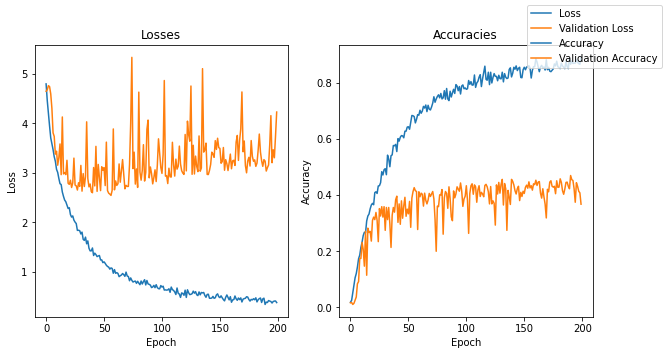

In [12]:
history = {'loss': [4.798003, 4.460454, 4.196811, 3.945573, 3.706277, 3.58622, 3.471221, 3.326154, 3.232068, 3.070699, 3.009557, 2.887471, 2.780599, 2.764032, 2.612877, 2.52535, 2.450009, 2.41576, 2.34875, 2.280113, 2.295266, 2.157853, 2.105288, 2.129671, 2.044297, 2.004486, 1.974922, 1.836739, 1.840532, 1.830055, 1.764795, 1.801557, 1.656554, 1.634751, 1.700681, 1.566015, 1.624551, 1.476205, 1.423194, 1.423612, 1.481281, 1.329355, 1.37716, 1.348026, 1.307208, 1.319778, 1.329611, 1.239934, 1.240911, 1.18507, 1.201204, 1.170504, 1.132498, 1.108055, 1.094522, 1.053856, 1.078316, 1.067984, 0.970689, 1.044104, 0.969857, 0.983152, 0.966943, 0.902001, 0.920214, 0.935203, 0.965102, 0.942632, 0.908075, 0.993558, 0.91496, 0.904376, 0.819077, 0.875894, 0.827096, 0.793184, 0.805503, 0.811898, 0.766228, 0.808706, 0.771282, 0.739374, 0.813851, 0.753126, 0.801844, 0.840088, 0.734145, 0.824123, 0.754789, 0.746007, 0.730707, 0.681228, 0.692047, 0.725935, 0.678995, 0.739108, 0.681037, 0.659175, 0.656513, 0.721888, 0.691468, 0.70918, 0.630924, 0.63457, 0.629438, 0.634287, 0.656647, 0.585271, 0.69116, 0.640371, 0.623361, 0.593614, 0.541043, 0.672313, 0.566885, 0.549105, 0.482322, 0.573475, 0.56085, 0.525098, 0.629236, 0.482005, 0.636397, 0.577014, 0.538439, 0.545491, 0.557573, 0.608649, 0.567576, 0.599221, 0.535618, 0.51917, 0.593255, 0.534828, 0.581596, 0.573663, 0.581919, 0.522006, 0.485251, 0.542794, 0.546457, 0.465163, 0.464949, 0.469284, 0.503092, 0.463676, 0.475125, 0.532899, 0.553783, 0.49619, 0.477996, 0.514292, 0.473727, 0.438183, 0.412101, 0.48442, 0.531552, 0.480628, 0.432538, 0.497453, 0.384791, 0.432286, 0.437646, 0.510871, 0.454055, 0.423615, 0.470688, 0.437483, 0.471968, 0.39014, 0.447125, 0.458685, 0.464535, 0.495893, 0.489563, 0.440073, 0.40805, 0.441821, 0.43192, 0.455363, 0.434955, 0.473933, 0.391666, 0.435597, 0.457795, 0.469886, 0.379803, 0.451457, 0.466888, 0.340052, 0.387451, 0.379347, 0.418377, 0.408725, 0.399026, 0.368707, 0.399756, 0.408421, 0.410428, 0.377803], 'accuracy': [0.018627, 0.02549, 0.052941, 0.080392, 0.105882, 0.120588, 0.144118, 0.173529, 0.186275, 0.213725, 0.232353, 0.255882, 0.267647, 0.265686, 0.307843, 0.32549, 0.332353, 0.35098, 0.364706, 0.370588, 0.365686, 0.408824, 0.411765, 0.405882, 0.432353, 0.433333, 0.444118, 0.483333, 0.471569, 0.490196, 0.494118, 0.472549, 0.542157, 0.528431, 0.50098, 0.540196, 0.543137, 0.576471, 0.57549, 0.580392, 0.554902, 0.60098, 0.592157, 0.605882, 0.611765, 0.610784, 0.603922, 0.627451, 0.627451, 0.642157, 0.643137, 0.634314, 0.659804, 0.683333, 0.682353, 0.679412, 0.656863, 0.669608, 0.686275, 0.684314, 0.701961, 0.691176, 0.69902, 0.715686, 0.709804, 0.720588, 0.697059, 0.719608, 0.705882, 0.702941, 0.713726, 0.727451, 0.75, 0.730392, 0.742157, 0.75098, 0.756863, 0.746078, 0.761765, 0.742157, 0.746078, 0.771569, 0.741176, 0.779412, 0.742157, 0.736274, 0.769608, 0.74902, 0.763726, 0.776471, 0.761765, 0.793137, 0.788235, 0.771569, 0.786274, 0.759804, 0.788235, 0.792157, 0.778431, 0.781373, 0.776471, 0.778431, 0.807843, 0.794118, 0.803922, 0.791176, 0.792157, 0.827451, 0.783333, 0.79902, 0.804902, 0.819608, 0.828431, 0.786274, 0.813725, 0.835294, 0.858824, 0.811765, 0.808824, 0.837255, 0.793137, 0.837255, 0.79902, 0.818627, 0.832353, 0.822549, 0.822549, 0.806863, 0.826471, 0.814706, 0.813725, 0.837255, 0.802941, 0.832353, 0.819608, 0.814706, 0.816667, 0.847059, 0.852941, 0.820588, 0.833333, 0.854902, 0.848039, 0.859804, 0.843137, 0.85098, 0.854902, 0.818627, 0.817647, 0.846078, 0.854902, 0.846078, 0.855882, 0.856863, 0.860784, 0.851961, 0.816667, 0.844118, 0.856863, 0.856863, 0.885294, 0.873529, 0.855882, 0.839216, 0.855882, 0.861765, 0.851961, 0.855882, 0.845098, 0.881373, 0.846078, 0.854902, 0.841176, 0.839216, 0.844118, 0.84902, 0.866667, 0.859804, 0.876471, 0.856863, 0.853922, 0.85, 0.869608, 0.859804, 0.854902, 0.85, 0.876471, 0.856863, 0.85, 0.888235, 0.865686, 0.877451, 0.868627, 0.869608, 0.869608, 0.882353, 0.872549, 0.867647, 0.865686, 0.890196], 'val_loss': [4.649771, 4.678938, 4.763077, 4.742518, 4.595638, 4.305463, 3.80994, 3.736205, 3.378464, 3.437658, 3.154369, 3.307925, 3.584253, 2.963182, 4.129535, 2.97924, 3.006475, 2.964588, 3.254217, 2.78963, 2.76731, 2.851557, 2.704131, 2.79633, 3.297772, 2.752903, 2.737159, 2.652859, 2.799893, 2.726282, 3.150414, 2.630061, 2.984739, 2.724096, 2.925935, 4.031263, 2.886441, 2.716718, 2.774466, 2.620624, 2.598662, 3.107241, 2.735675, 3.535487, 2.625667, 3.170058, 2.901403, 2.640965, 3.123266, 3.053741, 3.105561, 2.742682, 3.620998, 2.641536, 2.589227, 2.570251, 2.544298, 2.645968, 3.88746, 2.656819, 2.836305, 2.746152, 2.780672, 3.180283, 2.811076, 3.031935, 3.268155, 2.959562, 2.677274, 2.747315, 2.725648, 2.72588, 3.169628, 3.999005, 5.334603, 3.085073, 3.418075, 2.772766, 3.078676, 2.705419, 4.631684, 3.014209, 2.851891, 3.050056, 3.569112, 2.834211, 3.008425, 3.877594, 4.067196, 2.899244, 3.118257, 2.983776, 2.777373, 2.905011, 3.060903, 2.824081, 3.1583, 3.687791, 3.39822, 3.107788, 2.989115, 3.379354, 4.866427, 2.93311, 2.944577, 2.783746, 3.093472, 2.919469, 2.91557, 3.617735, 3.167565, 2.934627, 3.277569, 3.075194, 3.133987, 3.540726, 3.180494, 3.044256, 2.995954, 2.968816, 3.775508, 3.039641, 4.045116, 3.77302, 3.640196, 4.75534, 2.970408, 3.557664, 2.977491, 3.338502, 3.129936, 3.02476, 3.746226, 3.033842, 3.098113, 5.106266, 3.419275, 3.464476, 3.601229, 2.968786, 2.966269, 3.049292, 3.168603, 3.418052, 3.380034, 3.313774, 3.651168, 3.474137, 3.699568, 3.509345, 3.495385, 3.194178, 3.227595, 3.51228, 3.052435, 3.26667, 3.187135, 3.047042, 3.202637, 3.379262, 3.082795, 3.243556, 3.254067, 3.149562, 3.621602, 3.756087, 3.251922, 3.655721, 3.888108, 4.63522, 3.426396, 3.643823, 3.148881, 3.000796, 3.237719, 3.313886, 3.137611, 3.652841, 3.333904, 3.234229, 3.262357, 3.130916, 3.197127, 3.455552, 3.784107, 3.420388, 3.244947, 3.131594, 3.267102, 3.237652, 3.036752, 3.105413, 3.158258, 3.56462, 4.156411, 3.204682, 3.46711, 3.304832, 3.744192, 4.229105], 'val_accuracy': [0.016667, 0.017647, 0.010784, 0.014706, 0.02549, 0.037255, 0.084314, 0.092157, 0.17451, 0.17451, 0.231373, 0.206863, 0.147059, 0.271569, 0.114706, 0.282353, 0.266667, 0.270588, 0.236275, 0.309804, 0.321569, 0.312745, 0.338235, 0.309804, 0.234314, 0.351961, 0.32549, 0.358824, 0.321569, 0.358824, 0.27451, 0.355882, 0.312745, 0.355882, 0.297059, 0.213725, 0.328431, 0.355882, 0.339216, 0.383333, 0.396078, 0.302941, 0.368627, 0.296078, 0.379412, 0.317647, 0.361765, 0.392157, 0.32451, 0.35, 0.333333, 0.377451, 0.285294, 0.389216, 0.412745, 0.426471, 0.415686, 0.412745, 0.277451, 0.411765, 0.394118, 0.406863, 0.402941, 0.360784, 0.406863, 0.381373, 0.368627, 0.382353, 0.405882, 0.395098, 0.403922, 0.412745, 0.386275, 0.313726, 0.2, 0.360784, 0.358824, 0.40098, 0.4, 0.419608, 0.260784, 0.390196, 0.412745, 0.405882, 0.352941, 0.429412, 0.387255, 0.322549, 0.308824, 0.414706, 0.390196, 0.403922, 0.429412, 0.421569, 0.413725, 0.443137, 0.414706, 0.359804, 0.386275, 0.396078, 0.433333, 0.381373, 0.263725, 0.405882, 0.433333, 0.440196, 0.402941, 0.436274, 0.429412, 0.37451, 0.418627, 0.433333, 0.395098, 0.409804, 0.403922, 0.394118, 0.434314, 0.438235, 0.429412, 0.411765, 0.368627, 0.430392, 0.368627, 0.379412, 0.370588, 0.293137, 0.436274, 0.403922, 0.445098, 0.406863, 0.438235, 0.455882, 0.364706, 0.441176, 0.422549, 0.27451, 0.416667, 0.393137, 0.366667, 0.455882, 0.44902, 0.436274, 0.415686, 0.403922, 0.422549, 0.431373, 0.380392, 0.409804, 0.395098, 0.413725, 0.405882, 0.427451, 0.435294, 0.42451, 0.447059, 0.42549, 0.433333, 0.417647, 0.440196, 0.437255, 0.452941, 0.434314, 0.446078, 0.448039, 0.406863, 0.389216, 0.422549, 0.393137, 0.367647, 0.318627, 0.420588, 0.411765, 0.446078, 0.45098, 0.431373, 0.428431, 0.431373, 0.404902, 0.45098, 0.427451, 0.428431, 0.457843, 0.445098, 0.415686, 0.402941, 0.421569, 0.445098, 0.446078, 0.431373, 0.422549, 0.469608, 0.454902, 0.451961, 0.422549, 0.37451, 0.444118, 0.431373, 0.413725, 0.407843, 0.367647]}

run_summary(history)

## Model 25
* Augmentations:
  * RandAugment
* depth=4, skips=[], skip_start_depth=2
* heat=1, chill=0, reheat=0, min_channels=32, max_channels=256

0.513726 | 0.45098


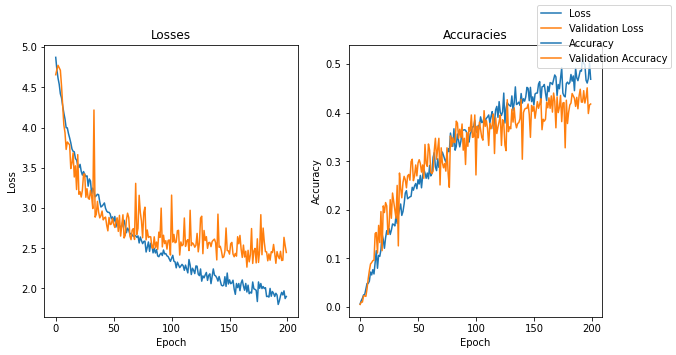

In [13]:
history = {'loss': [4.871854, 4.717192, 4.611635, 4.536917, 4.419323, 4.368968, 4.268634, 4.180462, 4.104209, 3.996975, 3.995722, 3.924906, 3.870274, 3.809235, 3.7342, 3.704163, 3.698351, 3.614549, 3.595499, 3.533703, 3.502879, 3.542068, 3.456107, 3.408722, 3.452245, 3.418721, 3.390887, 3.399747, 3.270888, 3.360918, 3.334003, 3.17121, 3.247042, 3.205341, 3.138179, 3.151859, 3.170099, 3.165156, 3.075227, 3.011831, 3.0233, 3.041137, 3.062452, 2.995331, 2.960482, 2.946052, 2.945893, 2.925421, 2.864432, 2.888693, 2.835025, 2.894519, 2.763088, 2.863506, 2.82074, 2.767569, 2.77321, 2.764432, 2.844568, 2.847183, 2.774156, 2.692463, 2.749048, 2.725006, 2.673964, 2.682999, 2.663814, 2.645666, 2.659598, 2.654646, 2.635318, 2.653153, 2.564898, 2.639239, 2.594024, 2.556858, 2.583337, 2.588067, 2.452711, 2.511611, 2.577353, 2.460638, 2.561416, 2.536218, 2.441646, 2.498564, 2.440807, 2.481837, 2.403582, 2.394207, 2.422869, 2.439841, 2.408827, 2.477253, 2.429025, 2.432827, 2.404979, 2.3961, 2.366919, 2.336366, 2.374534, 2.411478, 2.337762, 2.329924, 2.255865, 2.326179, 2.293361, 2.258401, 2.279319, 2.298686, 2.280851, 2.225112, 2.289529, 2.243299, 2.192973, 2.359185, 2.289599, 2.172856, 2.25098, 2.225281, 2.184228, 2.279531, 2.275826, 2.176559, 2.159086, 2.241833, 2.09009, 2.155402, 2.131653, 2.167168, 2.198623, 2.099777, 2.161702, 2.181394, 2.0593, 2.146807, 2.242322, 2.165624, 2.155611, 2.132095, 2.09106, 2.148246, 2.09248, 2.040226, 2.032024, 2.041266, 2.145479, 2.025474, 2.191341, 2.054814, 2.105919, 2.058963, 2.068655, 2.101968, 1.992261, 1.926564, 2.061551, 2.009879, 2.060862, 1.972198, 2.066686, 2.105442, 2.030345, 1.977595, 2.062001, 1.955358, 2.040621, 1.934577, 1.953334, 1.941812, 2.079905, 1.995479, 1.988009, 1.97676, 1.837146, 2.080415, 2.001952, 2.06098, 1.998134, 2.023345, 1.998496, 2.009108, 1.898929, 1.903073, 1.892193, 1.999886, 1.90264, 1.961771, 1.939588, 1.900097, 1.939553, 1.917368, 1.80089, 1.845736, 1.908097, 1.950997, 1.91899, 1.969804, 1.874096, 1.89999], 'accuracy': [0.005882, 0.012745, 0.017647, 0.02451, 0.02549, 0.037255, 0.048039, 0.048039, 0.052941, 0.071569, 0.065686, 0.076471, 0.067647, 0.091176, 0.115686, 0.079412, 0.105882, 0.103922, 0.117647, 0.15, 0.138235, 0.120588, 0.142157, 0.156863, 0.151961, 0.161765, 0.14902, 0.157843, 0.170588, 0.169608, 0.166667, 0.187255, 0.171569, 0.189216, 0.2, 0.211765, 0.188235, 0.196078, 0.211765, 0.234314, 0.239216, 0.222549, 0.22451, 0.226471, 0.227451, 0.246078, 0.240196, 0.24902, 0.253922, 0.243137, 0.261765, 0.252941, 0.270588, 0.245098, 0.269608, 0.283333, 0.27549, 0.264706, 0.27549, 0.263725, 0.291176, 0.269608, 0.27451, 0.307843, 0.317647, 0.288235, 0.280392, 0.304902, 0.287255, 0.303922, 0.305882, 0.318627, 0.311765, 0.303922, 0.298039, 0.310784, 0.32549, 0.319608, 0.357843, 0.342157, 0.330392, 0.366667, 0.322549, 0.330392, 0.355882, 0.342157, 0.329412, 0.341176, 0.364706, 0.363725, 0.364706, 0.363725, 0.358824, 0.342157, 0.339216, 0.355882, 0.360784, 0.370588, 0.370588, 0.384314, 0.361765, 0.358824, 0.373529, 0.372549, 0.391176, 0.379412, 0.380392, 0.390196, 0.383333, 0.388235, 0.391176, 0.395098, 0.378431, 0.392157, 0.401961, 0.366667, 0.381373, 0.405882, 0.412745, 0.390196, 0.422549, 0.4, 0.394118, 0.401961, 0.440196, 0.378431, 0.408824, 0.420588, 0.416667, 0.414706, 0.412745, 0.434314, 0.403922, 0.420588, 0.452941, 0.416667, 0.418627, 0.421569, 0.414706, 0.439216, 0.419608, 0.428431, 0.423529, 0.432353, 0.451961, 0.45, 0.42451, 0.451961, 0.422549, 0.432353, 0.415686, 0.438235, 0.440196, 0.440196, 0.458824, 0.463725, 0.419608, 0.452941, 0.453922, 0.457843, 0.440196, 0.42451, 0.453922, 0.443137, 0.461765, 0.460784, 0.457843, 0.467647, 0.477451, 0.473529, 0.435294, 0.457843, 0.44902, 0.469608, 0.492157, 0.440196, 0.434314, 0.432353, 0.459804, 0.462745, 0.458824, 0.461765, 0.478431, 0.464706, 0.47549, 0.445098, 0.491176, 0.471569, 0.465686, 0.47549, 0.486275, 0.485294, 0.513726, 0.50098, 0.49902, 0.466667, 0.460784, 0.470588, 0.501961, 0.468627], 'val_loss': [4.655904, 4.720335, 4.772687, 4.742966, 4.711473, 4.518945, 4.285016, 4.031999, 3.935627, 3.727611, 3.820104, 3.801936, 3.784364, 3.489312, 3.559619, 3.684276, 3.384833, 3.523426, 3.228807, 3.662851, 3.169797, 3.201676, 3.135683, 3.219762, 3.419229, 3.423051, 3.13276, 3.239555, 3.123619, 3.10837, 3.218493, 3.141804, 2.992449, 4.21747, 2.886013, 2.920985, 3.08209, 2.949254, 2.876646, 2.90361, 2.961571, 2.852068, 2.874686, 2.88713, 2.785939, 2.715662, 2.882405, 2.793927, 2.801157, 2.869286, 2.798842, 2.757906, 2.829093, 2.877604, 2.708831, 2.908256, 2.650583, 2.788948, 2.915208, 2.627075, 2.659673, 2.852903, 2.935138, 2.882096, 2.651804, 2.606143, 2.725163, 2.743204, 2.608557, 3.305841, 2.671043, 2.74693, 3.157583, 2.944913, 2.837708, 2.629911, 2.944312, 3.010012, 2.603802, 2.726474, 2.632725, 2.64428, 2.640468, 2.507779, 2.498915, 2.641294, 2.503052, 2.57644, 2.486619, 2.699428, 2.634793, 2.998098, 2.515976, 2.661191, 2.557316, 2.59289, 2.488441, 2.595927, 2.602539, 2.415337, 3.159625, 2.57576, 2.671297, 2.56704, 2.576564, 2.717094, 2.722571, 2.414791, 2.577792, 2.530438, 2.544048, 2.875245, 2.521986, 2.588741, 2.606201, 2.470585, 2.971173, 2.531187, 2.566443, 2.548993, 2.51232, 2.537033, 2.683868, 2.454731, 2.567977, 2.874286, 2.897543, 2.431647, 2.720173, 2.59605, 2.643243, 2.498339, 2.569262, 2.571714, 2.519487, 2.583154, 2.600001, 2.61311, 2.568366, 2.354217, 2.923507, 2.511151, 2.523997, 2.467086, 2.38244, 2.39297, 2.458775, 2.751181, 2.471619, 2.467052, 2.426514, 2.555364, 2.571858, 2.426796, 2.393499, 2.435119, 2.401126, 2.642723, 2.555192, 2.658878, 2.488413, 2.385332, 2.538586, 2.39057, 2.462825, 2.264749, 2.473914, 2.330177, 2.419398, 2.74424, 2.310556, 2.466291, 2.497622, 2.316776, 2.616789, 2.323179, 2.472366, 2.916433, 2.418905, 2.750209, 2.575629, 2.456744, 2.454064, 2.343164, 2.428941, 2.350978, 2.455902, 2.444558, 2.546465, 2.437086, 2.312265, 2.457435, 2.40083, 2.369187, 2.460708, 2.347302, 2.350689, 2.634623, 2.534187, 2.446953], 'val_accuracy': [0.004902, 0.009804, 0.009804, 0.022549, 0.022549, 0.021569, 0.037255, 0.057843, 0.07451, 0.088235, 0.091176, 0.095098, 0.096078, 0.15098, 0.152941, 0.110784, 0.167647, 0.132353, 0.196078, 0.115686, 0.207843, 0.194118, 0.214706, 0.207843, 0.14902, 0.165686, 0.220588, 0.182353, 0.234314, 0.216667, 0.19902, 0.182353, 0.25, 0.12549, 0.27549, 0.244118, 0.22451, 0.255882, 0.268627, 0.261765, 0.245098, 0.269608, 0.272549, 0.260784, 0.29902, 0.303922, 0.259804, 0.269608, 0.292157, 0.269608, 0.296078, 0.302941, 0.295098, 0.277451, 0.292157, 0.264706, 0.334314, 0.295098, 0.289216, 0.335294, 0.322549, 0.277451, 0.27451, 0.279412, 0.321569, 0.347059, 0.303922, 0.32549, 0.347059, 0.25098, 0.327451, 0.297059, 0.286275, 0.295098, 0.279412, 0.327451, 0.27451, 0.246078, 0.351961, 0.330392, 0.348039, 0.338235, 0.339216, 0.382353, 0.378431, 0.347059, 0.365686, 0.34902, 0.376471, 0.322549, 0.347059, 0.293137, 0.358824, 0.330392, 0.369608, 0.361765, 0.395098, 0.34902, 0.35, 0.395098, 0.271569, 0.371569, 0.348039, 0.380392, 0.364706, 0.34902, 0.343137, 0.403922, 0.371569, 0.383333, 0.366667, 0.332353, 0.377451, 0.366667, 0.37451, 0.397059, 0.315686, 0.389216, 0.356863, 0.370588, 0.381373, 0.395098, 0.332353, 0.385294, 0.378431, 0.333333, 0.321569, 0.426471, 0.360784, 0.370588, 0.366667, 0.406863, 0.380392, 0.409804, 0.379412, 0.368627, 0.377451, 0.379412, 0.387255, 0.427451, 0.303922, 0.4, 0.406863, 0.408824, 0.408824, 0.417647, 0.396078, 0.34902, 0.414706, 0.402941, 0.412745, 0.388235, 0.404902, 0.422549, 0.408824, 0.417647, 0.428431, 0.364706, 0.386275, 0.382353, 0.386275, 0.421569, 0.409804, 0.430392, 0.408824, 0.434314, 0.40098, 0.440196, 0.423529, 0.368627, 0.432353, 0.4, 0.410784, 0.435294, 0.381373, 0.419608, 0.420588, 0.327451, 0.42549, 0.377451, 0.40098, 0.415686, 0.419608, 0.439216, 0.434314, 0.429412, 0.412745, 0.431373, 0.407843, 0.434314, 0.448039, 0.421569, 0.421569, 0.445098, 0.419608, 0.431373, 0.45098, 0.398039, 0.415686, 0.417647]}

run_summary(history)

## Model 26
* Augmentations:
  * AutoAugment
    * [('Rotate', 0.7, 2), ('TranslateX', 0.3, 2)]
    * [('TranslateX', 0.3, 2), ('TranslateY', 0.4, 3)]
    * [('AutoContrast', 0.5, 3), ('Brightness', 0.9, 6)]
    * [('Rotate', 0.7, 2), ('Color', 0.2, 1)]
* depth=4, skips=[], skip_start_depth=2
* heat=1, chill=0, reheat=0, min_channels=32, max_channels=256

0.872549 | 0.451961


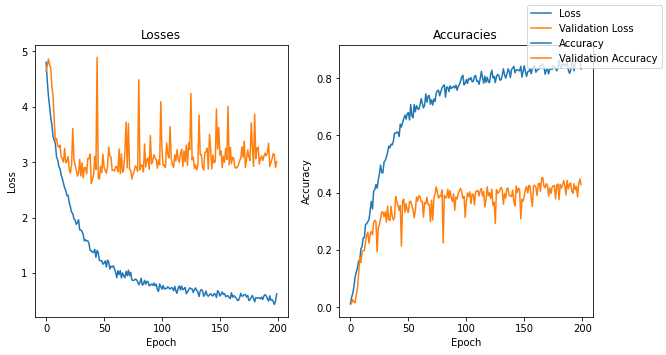

In [4]:
history = {'loss': [4.79832, 4.468979, 4.196074, 3.994283, 3.807667, 3.669727, 3.464081, 3.390308, 3.330486, 3.088849, 3.042252, 2.922885, 2.879227, 2.767626, 2.699414, 2.617242, 2.534226, 2.487592, 2.394303, 2.400937, 2.268636, 2.191212, 2.094076, 2.076573, 1.979485, 1.960336, 1.878764, 1.90788, 1.960355, 1.778278, 1.777285, 1.751796, 1.697109, 1.578251, 1.599847, 1.57962, 1.579224, 1.533348, 1.407922, 1.404372, 1.375221, 1.371099, 1.427173, 1.283464, 1.406722, 1.368039, 1.230467, 1.220636, 1.223652, 1.158546, 1.177967, 1.217533, 1.111008, 1.232694, 1.203101, 1.072892, 1.122542, 1.108326, 1.130532, 1.077204, 1.012103, 0.916523, 1.04193, 0.972323, 1.04196, 0.912789, 1.001949, 0.948819, 0.915469, 1.029051, 0.952065, 1.052, 0.950639, 1.013042, 0.876359, 0.866748, 0.86928, 0.891111, 0.879617, 0.841734, 0.790282, 0.825908, 0.907912, 0.783909, 0.799075, 0.868883, 0.797267, 0.85188, 0.841746, 0.769107, 0.786621, 0.801099, 0.775208, 0.8199, 0.768711, 0.800692, 0.702243, 0.668148, 0.803557, 0.75301, 0.708888, 0.775945, 0.712642, 0.724003, 0.719453, 0.75305, 0.730059, 0.711193, 0.7373, 0.730016, 0.680456, 0.760153, 0.678988, 0.635267, 0.728697, 0.768103, 0.695251, 0.76502, 0.697996, 0.713478, 0.741349, 0.627296, 0.656339, 0.698016, 0.732202, 0.719044, 0.713584, 0.649296, 0.696355, 0.731788, 0.689395, 0.658365, 0.576877, 0.673017, 0.701998, 0.680338, 0.580033, 0.616704, 0.675237, 0.598882, 0.582915, 0.606783, 0.626741, 0.599514, 0.587085, 0.630436, 0.613987, 0.558681, 0.680282, 0.656457, 0.585502, 0.618136, 0.659931, 0.61433, 0.627607, 0.574439, 0.586839, 0.591269, 0.557082, 0.539193, 0.643988, 0.566635, 0.593024, 0.568386, 0.554078, 0.511958, 0.506459, 0.552285, 0.633825, 0.583841, 0.588425, 0.612656, 0.611946, 0.569123, 0.594907, 0.504402, 0.518424, 0.561781, 0.595393, 0.544114, 0.480677, 0.556437, 0.546629, 0.552756, 0.553149, 0.53424, 0.565773, 0.523754, 0.587343, 0.609849, 0.585566, 0.536343, 0.494841, 0.588604, 0.509478, 0.519809, 0.490346, 0.433739, 0.492133, 0.624877], 'accuracy': [0.013725, 0.034314, 0.04902, 0.071569, 0.105882, 0.121569, 0.138235, 0.161765, 0.163725, 0.203922, 0.212745, 0.242157, 0.243137, 0.289216, 0.291176, 0.29902, 0.305882, 0.339216, 0.369608, 0.343137, 0.404902, 0.410784, 0.428431, 0.415686, 0.444118, 0.466667, 0.496078, 0.469608, 0.469608, 0.507843, 0.511765, 0.52549, 0.539216, 0.562745, 0.556863, 0.569608, 0.566667, 0.579412, 0.607843, 0.606863, 0.611765, 0.610784, 0.596078, 0.639216, 0.629412, 0.645098, 0.658824, 0.670588, 0.656863, 0.676471, 0.679412, 0.653922, 0.707843, 0.668627, 0.661765, 0.707843, 0.682353, 0.703922, 0.694118, 0.690196, 0.705882, 0.728431, 0.711765, 0.696078, 0.704902, 0.745098, 0.715686, 0.737255, 0.739216, 0.708824, 0.72451, 0.705882, 0.727451, 0.718627, 0.748039, 0.755882, 0.757843, 0.738235, 0.751961, 0.766667, 0.772549, 0.776471, 0.733333, 0.768627, 0.768627, 0.752941, 0.773529, 0.763726, 0.767647, 0.771569, 0.765686, 0.77549, 0.757843, 0.770588, 0.778431, 0.789216, 0.803922, 0.809804, 0.776471, 0.781373, 0.795098, 0.781373, 0.79902, 0.794118, 0.801961, 0.787255, 0.788235, 0.805882, 0.809804, 0.789216, 0.790196, 0.778431, 0.79902, 0.823529, 0.80098, 0.782353, 0.806863, 0.785294, 0.802941, 0.788235, 0.784314, 0.812745, 0.827451, 0.80098, 0.805882, 0.784314, 0.805882, 0.812745, 0.809804, 0.793137, 0.794118, 0.809804, 0.832353, 0.811765, 0.8, 0.813725, 0.832353, 0.82451, 0.801961, 0.830392, 0.834314, 0.841176, 0.818627, 0.828431, 0.829412, 0.827451, 0.82549, 0.841176, 0.803922, 0.82451, 0.843137, 0.822549, 0.805882, 0.822549, 0.823529, 0.834314, 0.815686, 0.833333, 0.842157, 0.844118, 0.820588, 0.827451, 0.831373, 0.832353, 0.844118, 0.848039, 0.84902, 0.840196, 0.813725, 0.827451, 0.834314, 0.814706, 0.830392, 0.833333, 0.830392, 0.845098, 0.839216, 0.834314, 0.82549, 0.837255, 0.863725, 0.839216, 0.835294, 0.853922, 0.844118, 0.84902, 0.843137, 0.857843, 0.829412, 0.816667, 0.826471, 0.854902, 0.84902, 0.82549, 0.851961, 0.856863, 0.864706, 0.872549, 0.859804, 0.832353], 'val_loss': [4.636703, 4.747344, 4.859921, 4.748228, 4.697576, 4.356219, 4.184245, 3.751498, 3.389589, 3.425241, 3.297878, 3.267529, 3.308718, 3.099949, 3.057916, 3.000552, 3.247317, 2.987383, 3.019014, 3.101657, 2.856899, 2.80366, 2.957979, 3.606971, 3.052681, 2.950074, 2.866992, 2.746689, 2.7977, 3.050163, 2.749961, 2.988861, 2.718554, 2.900561, 2.899139, 2.790227, 3.066599, 3.060548, 3.145964, 2.614907, 2.689012, 2.777888, 3.102584, 2.866409, 4.888813, 2.723986, 2.693221, 2.922725, 2.807904, 3.143604, 2.910158, 2.845711, 2.800098, 2.920042, 3.272063, 3.112871, 3.088567, 2.85003, 2.856351, 2.840452, 2.915055, 2.916771, 2.825414, 3.237203, 2.789589, 3.150436, 2.815984, 2.883362, 3.190107, 3.724804, 2.897279, 3.697062, 2.874927, 2.853113, 2.695972, 2.779047, 2.838828, 2.929759, 2.908754, 2.833372, 4.484797, 2.858254, 2.951248, 2.940067, 2.823164, 3.325101, 2.910858, 3.044387, 3.076039, 2.869085, 3.479619, 2.968801, 3.019591, 3.134619, 3.077098, 3.048457, 2.890152, 3.040485, 2.950434, 4.091505, 3.223227, 2.939696, 2.950749, 2.902361, 3.347541, 3.148939, 3.076045, 3.640449, 3.056345, 2.959653, 2.905985, 3.131654, 3.021258, 3.224624, 3.053199, 2.994888, 3.151792, 3.2307, 2.919876, 3.200733, 3.003387, 3.305958, 2.944204, 3.34855, 3.229218, 4.237051, 3.039345, 3.089041, 2.886607, 2.949598, 2.858356, 2.927783, 3.845616, 3.13411, 3.133989, 2.905983, 2.856142, 3.167158, 3.190361, 3.252369, 2.873725, 3.501923, 3.2433, 2.878961, 3.12748, 2.98625, 3.014934, 3.9574, 3.235924, 3.625436, 3.1251, 3.20427, 2.902091, 3.107355, 2.997652, 3.247187, 3.047909, 4.006818, 2.950609, 3.266534, 2.971456, 3.086315, 3.070796, 2.897743, 2.89212, 2.913175, 2.946304, 3.024719, 3.066939, 3.276925, 3.085895, 3.374, 2.899697, 3.059007, 3.218077, 3.096987, 3.029018, 3.706822, 3.278508, 2.923389, 3.86489, 3.059724, 3.254286, 3.271434, 2.964374, 3.060236, 3.112866, 3.027885, 3.105158, 3.160903, 3.111312, 3.176422, 3.337787, 2.918706, 2.988834, 3.058764, 3.153483, 3.133764, 2.900963, 3.009001], 'val_accuracy': [0.009804, 0.014706, 0.026471, 0.019608, 0.015686, 0.043137, 0.065686, 0.113725, 0.17451, 0.155882, 0.192157, 0.198039, 0.198039, 0.227451, 0.25098, 0.261765, 0.223529, 0.255882, 0.264706, 0.252941, 0.295098, 0.303922, 0.298039, 0.193137, 0.277451, 0.288235, 0.309804, 0.332353, 0.332353, 0.316667, 0.333333, 0.297059, 0.352941, 0.306863, 0.302941, 0.351961, 0.319608, 0.304902, 0.311765, 0.386275, 0.368627, 0.356863, 0.338235, 0.354902, 0.213725, 0.372549, 0.377451, 0.331373, 0.361765, 0.339216, 0.331373, 0.369608, 0.369608, 0.354902, 0.341176, 0.312745, 0.337255, 0.385294, 0.370588, 0.389216, 0.386275, 0.368627, 0.369608, 0.314706, 0.365686, 0.360784, 0.384314, 0.357843, 0.358824, 0.29902, 0.373529, 0.304902, 0.381373, 0.394118, 0.420588, 0.402941, 0.380392, 0.389216, 0.387255, 0.409804, 0.22451, 0.391176, 0.382353, 0.383333, 0.411765, 0.380392, 0.406863, 0.383333, 0.369608, 0.396078, 0.339216, 0.384314, 0.378431, 0.397059, 0.406863, 0.414706, 0.401961, 0.380392, 0.387255, 0.313726, 0.371569, 0.39902, 0.386275, 0.402941, 0.361765, 0.395098, 0.394118, 0.356863, 0.402941, 0.405882, 0.407843, 0.388235, 0.406863, 0.414706, 0.388235, 0.403922, 0.35, 0.37549, 0.420588, 0.389216, 0.4, 0.379412, 0.411765, 0.356863, 0.366667, 0.292157, 0.410784, 0.398039, 0.40098, 0.410784, 0.418627, 0.408824, 0.359804, 0.397059, 0.381373, 0.414706, 0.415686, 0.389216, 0.390196, 0.386275, 0.408824, 0.367647, 0.354902, 0.423529, 0.4, 0.415686, 0.409804, 0.308824, 0.376471, 0.370588, 0.389216, 0.412745, 0.421569, 0.39902, 0.42549, 0.421569, 0.380392, 0.351961, 0.42451, 0.42549, 0.418627, 0.390196, 0.428431, 0.433333, 0.404902, 0.451961, 0.451961, 0.422549, 0.416667, 0.431373, 0.42549, 0.388235, 0.416667, 0.397059, 0.418627, 0.42451, 0.42451, 0.378431, 0.426471, 0.430392, 0.37549, 0.428431, 0.416667, 0.42549, 0.442157, 0.42451, 0.392157, 0.443137, 0.413725, 0.427451, 0.434314, 0.404902, 0.398039, 0.431373, 0.410784, 0.421569, 0.385294, 0.430392, 0.448039, 0.428431]}

run_summary(history)

## Model 27
* Augmentations:
  * RandomFlip('horizontal')
  * RandomRotation(0.1)
  * RandomContrast(.2)
* SpatialDropout2D(0.2) follows the Conv layers.
* depth=4, skips=[], skip_start_depth=2
* heat=1, chill=0, reheat=0, min_channels=32, max_channels=256

0.641176 | 0.37549


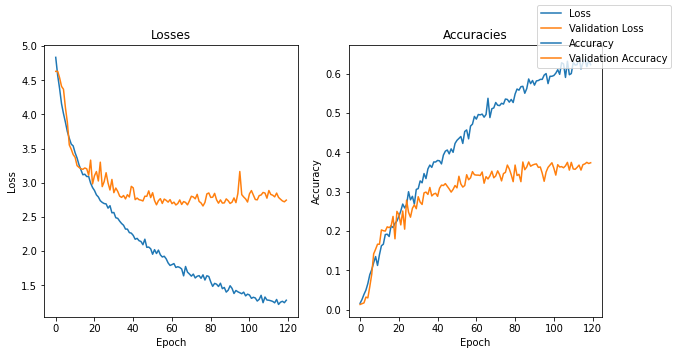

In [5]:
history = {'loss': [4.834352, 4.570983, 4.377312, 4.154272, 4.010616, 3.884866, 3.74691, 3.650228, 3.564269, 3.538214, 3.437528, 3.361378, 3.262615, 3.188371, 3.115834, 3.123752, 3.089754, 3.09104, 2.993284, 2.92918, 2.885552, 2.821867, 2.790235, 2.735907, 2.711204, 2.694348, 2.689362, 2.627118, 2.662934, 2.558694, 2.563453, 2.486374, 2.478038, 2.43666, 2.401932, 2.376633, 2.320762, 2.32024, 2.268961, 2.261215, 2.228167, 2.171952, 2.18482, 2.150959, 2.138795, 2.091843, 2.172571, 2.05359, 2.057568, 2.032345, 1.952235, 2.019477, 1.96262, 2.012631, 1.943904, 1.912409, 1.923028, 1.885343, 1.825406, 1.788339, 1.800628, 1.815701, 1.758774, 1.76976, 1.758655, 1.736768, 1.636327, 1.773006, 1.690504, 1.663121, 1.631939, 1.661847, 1.605282, 1.630236, 1.639205, 1.600094, 1.650898, 1.575044, 1.637379, 1.626832, 1.547417, 1.482056, 1.525942, 1.514177, 1.480209, 1.527968, 1.448859, 1.465987, 1.398336, 1.42618, 1.491327, 1.452148, 1.378119, 1.421714, 1.402658, 1.388663, 1.374441, 1.397634, 1.342972, 1.368086, 1.355552, 1.307216, 1.322702, 1.312003, 1.267466, 1.291806, 1.351153, 1.243238, 1.326223, 1.282404, 1.279231, 1.271769, 1.261609, 1.241412, 1.290077, 1.217527, 1.250985, 1.263906, 1.242865, 1.279329], 'accuracy': [0.016667, 0.026471, 0.039216, 0.05, 0.066667, 0.089216, 0.101961, 0.119608, 0.135294, 0.112745, 0.140196, 0.162745, 0.166667, 0.191176, 0.192157, 0.186275, 0.213725, 0.208824, 0.219608, 0.22549, 0.237255, 0.25098, 0.268627, 0.258824, 0.267647, 0.3, 0.279412, 0.288235, 0.268627, 0.305882, 0.307843, 0.327451, 0.322549, 0.346078, 0.333333, 0.357843, 0.367647, 0.361765, 0.37549, 0.37549, 0.379412, 0.378431, 0.370588, 0.393137, 0.402941, 0.405882, 0.396078, 0.408824, 0.4, 0.422549, 0.430392, 0.435294, 0.440196, 0.422549, 0.452941, 0.456863, 0.434314, 0.466667, 0.471569, 0.491176, 0.484314, 0.496078, 0.495098, 0.497059, 0.489216, 0.496078, 0.537255, 0.488235, 0.510784, 0.512745, 0.526471, 0.519608, 0.518627, 0.52451, 0.522549, 0.535294, 0.534314, 0.527451, 0.534314, 0.526471, 0.548039, 0.560784, 0.557843, 0.566667, 0.567647, 0.55, 0.561765, 0.586275, 0.57451, 0.582353, 0.570588, 0.581373, 0.582353, 0.585294, 0.585294, 0.596078, 0.6, 0.57451, 0.593137, 0.593137, 0.595098, 0.60098, 0.609804, 0.598039, 0.627451, 0.62451, 0.590196, 0.631373, 0.597059, 0.6, 0.628431, 0.621569, 0.622549, 0.641176, 0.611765, 0.627451, 0.636275, 0.617647, 0.634314, 0.622549], 'val_loss': [4.629271, 4.630643, 4.534873, 4.409503, 4.367223, 4.097916, 3.884443, 3.55269, 3.489771, 3.411272, 3.371228, 3.249859, 3.224104, 3.203885, 3.194969, 3.215265, 3.202986, 3.109426, 3.329989, 2.98116, 3.101912, 3.162798, 3.025058, 3.300033, 2.942249, 3.015694, 3.145607, 2.995445, 2.892812, 3.047244, 2.853709, 2.921319, 2.872097, 2.802785, 2.784429, 2.812026, 2.762692, 2.824093, 2.79059, 2.946322, 2.923388, 2.751715, 2.774815, 2.750492, 2.744051, 2.732339, 2.801921, 2.800182, 2.879673, 2.781275, 2.852894, 2.737597, 2.676207, 2.7363, 2.766227, 2.696069, 2.759772, 2.741628, 2.715289, 2.75185, 2.69281, 2.715064, 2.673725, 2.695283, 2.747125, 2.680846, 2.723252, 2.710744, 2.675171, 2.734153, 2.801209, 2.790701, 2.763672, 2.829206, 2.725472, 2.703156, 2.658808, 2.710005, 2.835398, 2.849442, 2.784044, 2.787373, 2.843489, 2.74983, 2.69969, 2.748085, 2.701369, 2.703974, 2.762642, 2.735605, 2.695855, 2.714689, 2.776459, 2.707659, 2.841754, 3.163434, 2.824938, 2.790539, 2.762122, 2.716719, 2.837717, 2.884118, 2.818343, 2.753664, 2.748673, 2.810486, 2.820035, 2.856476, 2.848001, 2.773325, 2.884809, 2.82757, 2.816379, 2.792408, 2.847536, 2.784364, 2.757787, 2.732771, 2.719894, 2.744817], 'val_accuracy': [0.013725, 0.015686, 0.017647, 0.032353, 0.030392, 0.058824, 0.090196, 0.142157, 0.153922, 0.166667, 0.166667, 0.202941, 0.20098, 0.2, 0.210784, 0.208824, 0.212745, 0.237255, 0.180392, 0.25, 0.242157, 0.215686, 0.25098, 0.204902, 0.278431, 0.248039, 0.235294, 0.257843, 0.266667, 0.256863, 0.287255, 0.273529, 0.267647, 0.297059, 0.29902, 0.293137, 0.310784, 0.289216, 0.294118, 0.296078, 0.288235, 0.308824, 0.316667, 0.315686, 0.320588, 0.313726, 0.306863, 0.29902, 0.305882, 0.315686, 0.309804, 0.339216, 0.319608, 0.311765, 0.315686, 0.343137, 0.330392, 0.335294, 0.35098, 0.343137, 0.342157, 0.342157, 0.341176, 0.35, 0.321569, 0.338235, 0.332353, 0.340196, 0.351961, 0.335294, 0.340196, 0.352941, 0.343137, 0.327451, 0.346078, 0.34902, 0.367647, 0.357843, 0.343137, 0.32549, 0.367647, 0.341176, 0.344118, 0.32549, 0.37549, 0.355882, 0.362745, 0.37549, 0.364706, 0.367647, 0.369608, 0.370588, 0.361765, 0.362745, 0.347059, 0.326471, 0.35, 0.361765, 0.367647, 0.373529, 0.359804, 0.342157, 0.368627, 0.362745, 0.363725, 0.360784, 0.365686, 0.37451, 0.354902, 0.37451, 0.357843, 0.356863, 0.361765, 0.367647, 0.354902, 0.368627, 0.370588, 0.37451, 0.371569, 0.373529]}

run_summary(history)

## Model 28
* Augmentations:
  * RandomFlip('horizontal')
  * RandomRotation(0.1)
  * RandomContrast(.2)
* SpatialDropout2D(0.2) follows the Conv layers.
* PReLU
* depth=4, skips=[], skip_start_depth=2
* heat=1, chill=0, reheat=0, min_channels=32, max_channels=256

0.729412 | 0.401961


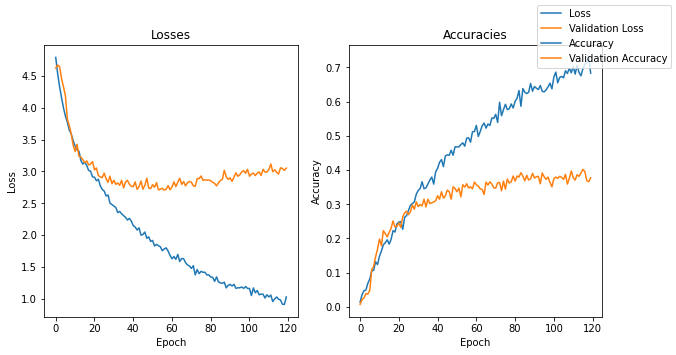

In [6]:
history = {'loss': [4.794337, 4.536748, 4.331713, 4.159415, 4.000727, 3.870031, 3.774708, 3.650042, 3.59037, 3.486292, 3.399114, 3.341406, 3.316038, 3.169957, 3.116319, 3.143878, 3.094565, 3.015754, 3.004559, 2.91507, 2.90986, 2.853642, 2.877751, 2.77466, 2.717616, 2.6928, 2.614355, 2.630619, 2.502677, 2.48016, 2.456259, 2.43416, 2.354253, 2.371596, 2.335019, 2.305968, 2.279646, 2.236619, 2.262437, 2.220758, 2.149634, 2.1258, 2.079591, 2.113896, 1.999141, 2.00825, 2.048042, 1.94956, 1.971782, 1.899906, 1.915113, 1.827951, 1.853919, 1.833039, 1.816144, 1.754015, 1.782872, 1.798674, 1.74802, 1.680022, 1.627051, 1.663062, 1.619204, 1.695671, 1.584053, 1.631436, 1.628797, 1.566657, 1.531053, 1.515043, 1.476319, 1.517817, 1.374029, 1.458318, 1.393925, 1.430029, 1.415245, 1.415924, 1.374145, 1.374551, 1.340126, 1.336367, 1.272171, 1.34317, 1.263277, 1.248638, 1.241554, 1.259519, 1.170017, 1.211644, 1.224638, 1.199355, 1.224936, 1.163059, 1.171004, 1.171255, 1.184152, 1.16107, 1.191519, 1.16044, 1.160981, 1.0497, 1.16885, 1.092967, 1.128431, 1.060946, 1.072838, 1.070469, 1.010454, 1.061916, 1.027708, 1.056963, 0.954653, 0.996181, 1.027127, 0.992082, 0.979734, 0.912656, 0.909452, 1.02723], 'accuracy': [0.013725, 0.035294, 0.047059, 0.04902, 0.068627, 0.081373, 0.104902, 0.106863, 0.131373, 0.123529, 0.148039, 0.162745, 0.181373, 0.187255, 0.196078, 0.183333, 0.197059, 0.222549, 0.218627, 0.242157, 0.248039, 0.24902, 0.226471, 0.261765, 0.266667, 0.282353, 0.297059, 0.301961, 0.306863, 0.329412, 0.340196, 0.346078, 0.365686, 0.345098, 0.348039, 0.358824, 0.370588, 0.379412, 0.358824, 0.395098, 0.404902, 0.422549, 0.430392, 0.409804, 0.441176, 0.444118, 0.443137, 0.457843, 0.443137, 0.467647, 0.467647, 0.467647, 0.47451, 0.479412, 0.469608, 0.493137, 0.494118, 0.481373, 0.511765, 0.512745, 0.530392, 0.498039, 0.512745, 0.529412, 0.537255, 0.522549, 0.534314, 0.530392, 0.551961, 0.55098, 0.562745, 0.539216, 0.598039, 0.558824, 0.576471, 0.592157, 0.576471, 0.579412, 0.593137, 0.581373, 0.60098, 0.609804, 0.632353, 0.586275, 0.638235, 0.627451, 0.623529, 0.627451, 0.652941, 0.630392, 0.644118, 0.639216, 0.635294, 0.647059, 0.630392, 0.628431, 0.634314, 0.643137, 0.653922, 0.637255, 0.671569, 0.686275, 0.654902, 0.670588, 0.673529, 0.669608, 0.690196, 0.682353, 0.698039, 0.684314, 0.702941, 0.680392, 0.705882, 0.685294, 0.67549, 0.696078, 0.708824, 0.715686, 0.729412, 0.683333], 'val_loss': [4.628364, 4.67417, 4.64839, 4.459512, 4.331096, 4.188482, 3.824438, 3.718779, 3.593379, 3.412169, 3.314291, 3.42755, 3.239417, 3.226621, 3.184394, 3.137758, 3.166773, 3.102191, 3.118081, 3.154738, 3.025618, 3.054993, 2.935317, 2.91596, 2.903143, 2.973849, 2.885581, 2.8292, 2.926242, 2.807472, 2.861835, 2.797486, 2.820042, 2.781973, 2.860561, 2.741999, 2.832608, 2.860379, 2.800631, 2.766907, 2.762467, 2.836548, 2.719524, 2.763241, 2.850924, 2.7222, 2.781494, 2.894393, 2.740394, 2.731473, 2.793024, 2.752461, 2.824583, 2.710259, 2.722857, 2.735685, 2.706295, 2.719779, 2.779511, 2.711913, 2.7573, 2.836359, 2.762329, 2.831479, 2.893135, 2.797316, 2.842183, 2.774244, 2.824548, 2.842885, 2.833407, 2.774266, 2.767398, 2.889334, 2.88722, 2.928897, 2.859323, 2.870674, 2.862722, 2.865651, 2.853999, 2.829826, 2.813239, 2.773931, 2.819849, 2.859085, 2.875338, 3.018556, 2.916074, 2.876536, 2.899806, 2.845286, 2.912025, 2.978341, 2.924598, 2.94933, 2.992566, 3.012526, 2.972223, 3.033652, 2.925241, 2.957725, 2.975129, 2.936405, 2.974062, 2.993879, 2.936927, 3.03366, 2.990992, 2.99195, 3.028279, 3.118107, 2.996193, 3.027596, 2.987551, 2.958957, 3.057259, 3.047625, 3.016831, 3.05332], 'val_accuracy': [0.006863, 0.021569, 0.02549, 0.038235, 0.037255, 0.048039, 0.107843, 0.118627, 0.146078, 0.168627, 0.198039, 0.178431, 0.222549, 0.213725, 0.204902, 0.217647, 0.229412, 0.25098, 0.233333, 0.235294, 0.245098, 0.232353, 0.262745, 0.27451, 0.279412, 0.269608, 0.278431, 0.298039, 0.285294, 0.306863, 0.293137, 0.29902, 0.295098, 0.314706, 0.292157, 0.314706, 0.301961, 0.303922, 0.306863, 0.309804, 0.32451, 0.314706, 0.336275, 0.317647, 0.32451, 0.341176, 0.336275, 0.314706, 0.35098, 0.346078, 0.336275, 0.347059, 0.321569, 0.356863, 0.35, 0.359804, 0.347059, 0.35098, 0.345098, 0.364706, 0.356863, 0.352941, 0.345098, 0.343137, 0.328431, 0.364706, 0.355882, 0.365686, 0.358824, 0.348039, 0.347059, 0.362745, 0.363725, 0.339216, 0.367647, 0.344118, 0.373529, 0.361765, 0.365686, 0.382353, 0.367647, 0.382353, 0.379412, 0.392157, 0.382353, 0.368627, 0.384314, 0.370588, 0.37451, 0.390196, 0.376471, 0.380392, 0.381373, 0.359804, 0.391176, 0.380392, 0.372549, 0.379412, 0.363725, 0.35098, 0.37451, 0.379412, 0.37549, 0.381373, 0.378431, 0.372549, 0.387255, 0.358824, 0.37549, 0.397059, 0.377451, 0.370588, 0.386275, 0.381373, 0.391176, 0.401961, 0.395098, 0.368627, 0.365686, 0.377451]}

run_summary(history)

## Model 32
* Augmentations:
  * MixUp
* depth=4, skips=[], skip_start_depth=2
* heat=1, chill=0, reheat=0, min_channels=32, max_channels=256

0.995098 | 0.214706


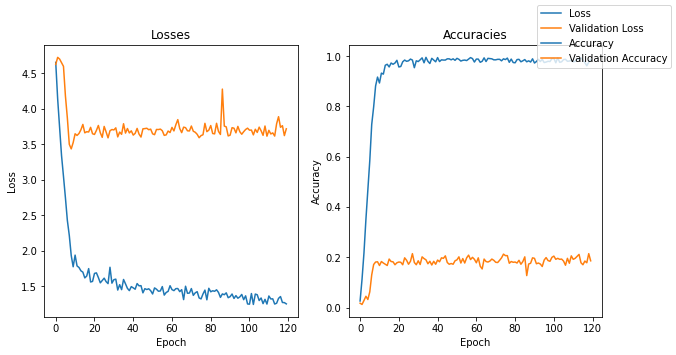

In [7]:
history = {'loss': [4.651319, 4.137072, 3.734804, 3.338224, 3.045534, 2.745285, 2.425221, 2.213632, 1.931226, 1.772651, 1.936609, 1.784262, 1.762594, 1.715791, 1.69693, 1.615638, 1.64228, 1.74673, 1.558206, 1.566064, 1.678867, 1.68663, 1.621438, 1.546034, 1.578797, 1.612051, 1.563177, 1.535472, 1.76568, 1.541434, 1.590678, 1.598213, 1.444545, 1.520256, 1.450328, 1.593546, 1.532778, 1.468643, 1.436496, 1.492906, 1.4754, 1.456404, 1.535799, 1.503902, 1.506566, 1.405204, 1.46383, 1.4521, 1.462295, 1.435509, 1.389411, 1.474592, 1.456093, 1.427982, 1.431682, 1.493405, 1.373631, 1.410172, 1.426376, 1.505574, 1.450713, 1.436605, 1.46447, 1.46617, 1.422199, 1.449575, 1.31002, 1.498309, 1.398831, 1.40236, 1.46553, 1.369943, 1.405185, 1.421628, 1.333657, 1.319803, 1.389103, 1.44395, 1.30712, 1.469347, 1.420181, 1.434383, 1.427333, 1.448088, 1.411126, 1.341303, 1.390012, 1.378981, 1.405184, 1.33686, 1.351734, 1.389005, 1.326164, 1.366112, 1.329501, 1.348114, 1.382744, 1.309187, 1.362983, 1.248655, 1.245626, 1.395346, 1.241783, 1.387939, 1.378256, 1.296971, 1.332973, 1.253206, 1.313658, 1.246996, 1.361001, 1.318987, 1.321069, 1.247554, 1.258951, 1.327562, 1.353052, 1.269346, 1.267643, 1.249747], 'accuracy': [0.026471, 0.112745, 0.217647, 0.35, 0.467647, 0.584314, 0.728431, 0.798039, 0.881373, 0.916667, 0.893137, 0.932353, 0.928431, 0.963726, 0.967647, 0.956863, 0.972549, 0.967647, 0.972549, 0.983333, 0.956863, 0.958824, 0.977451, 0.984314, 0.979412, 0.981373, 0.988235, 0.984314, 0.953922, 0.981373, 0.978431, 0.985294, 0.993137, 0.973529, 0.995098, 0.979412, 0.970588, 0.991176, 0.984314, 0.977451, 0.994118, 0.978431, 0.985294, 0.984314, 0.984314, 0.989216, 0.989216, 0.985294, 0.989216, 0.983333, 0.991176, 0.987255, 0.980392, 0.983333, 0.984314, 0.982353, 0.988235, 0.994118, 0.990196, 0.976471, 0.988235, 0.988235, 0.97549, 0.979412, 0.993137, 0.978431, 0.991176, 0.990196, 0.989216, 0.985294, 0.985294, 0.987255, 0.987255, 0.981373, 0.989216, 0.986274, 0.992157, 0.97549, 0.988235, 0.97451, 0.973529, 0.986274, 0.987255, 0.977451, 0.981373, 0.986274, 0.977451, 0.981373, 0.976471, 0.989216, 0.972549, 0.978431, 0.987255, 0.978431, 0.987255, 0.97451, 0.976471, 0.979412, 0.978431, 0.990196, 0.991176, 0.973529, 0.993137, 0.97549, 0.977451, 0.986274, 0.987255, 0.979412, 0.980392, 0.984314, 0.977451, 0.979412, 0.989216, 0.987255, 0.993137, 0.984314, 0.97451, 0.961765, 0.97549, 0.987255], 'val_loss': [4.622668, 4.722529, 4.69842, 4.647587, 4.595753, 4.180177, 3.868457, 3.4975, 3.433232, 3.521588, 3.645879, 3.622589, 3.64999, 3.702314, 3.77781, 3.659436, 3.674855, 3.671279, 3.736635, 3.646315, 3.636675, 3.693381, 3.763015, 3.660767, 3.595971, 3.749463, 3.671645, 3.588504, 3.688802, 3.705911, 3.699827, 3.729428, 3.60195, 3.670295, 3.638388, 3.787576, 3.655803, 3.71999, 3.657619, 3.687401, 3.627192, 3.652037, 3.721532, 3.641311, 3.59982, 3.71552, 3.719024, 3.723853, 3.703018, 3.71149, 3.645324, 3.63319, 3.706972, 3.705568, 3.711787, 3.688773, 3.623537, 3.630424, 3.684479, 3.663484, 3.735796, 3.686238, 3.773657, 3.845364, 3.720069, 3.662132, 3.73935, 3.731935, 3.68764, 3.685869, 3.755025, 3.681663, 3.667399, 3.63847, 3.59037, 3.620434, 3.632228, 3.793327, 3.675733, 3.697014, 3.762079, 3.649814, 3.644739, 3.793616, 3.678856, 3.636363, 4.275416, 3.754502, 3.743474, 3.615838, 3.626328, 3.731814, 3.724556, 3.658942, 3.749936, 3.675564, 3.639398, 3.675366, 3.706489, 3.724966, 3.696595, 3.698253, 3.630497, 3.709663, 3.664997, 3.739351, 3.688011, 3.62379, 3.75531, 3.61217, 3.694522, 3.643346, 3.658469, 3.613537, 3.787833, 3.886807, 3.736886, 3.760166, 3.620303, 3.716081], 'val_accuracy': [0.017647, 0.012745, 0.028431, 0.045098, 0.032353, 0.062745, 0.130392, 0.171569, 0.181373, 0.182353, 0.167647, 0.183333, 0.177451, 0.172549, 0.167647, 0.193137, 0.183333, 0.182353, 0.170588, 0.178431, 0.181373, 0.180392, 0.170588, 0.198039, 0.188235, 0.172549, 0.184314, 0.214706, 0.179412, 0.170588, 0.186275, 0.171569, 0.201961, 0.195098, 0.190196, 0.17451, 0.184314, 0.169608, 0.184314, 0.172549, 0.189216, 0.182353, 0.198039, 0.196078, 0.205882, 0.179412, 0.172549, 0.17549, 0.172549, 0.186275, 0.190196, 0.201961, 0.177451, 0.195098, 0.177451, 0.198039, 0.208824, 0.191176, 0.2, 0.192157, 0.178431, 0.198039, 0.164706, 0.153922, 0.193137, 0.183333, 0.181373, 0.185294, 0.193137, 0.188235, 0.180392, 0.179412, 0.188235, 0.198039, 0.212745, 0.206863, 0.206863, 0.176471, 0.183333, 0.180392, 0.181373, 0.177451, 0.188235, 0.172549, 0.183333, 0.201961, 0.127451, 0.173529, 0.176471, 0.198039, 0.196078, 0.17451, 0.177451, 0.173529, 0.163725, 0.189216, 0.19902, 0.187255, 0.184314, 0.2, 0.204902, 0.192157, 0.196078, 0.192157, 0.193137, 0.185294, 0.168627, 0.196078, 0.176471, 0.205882, 0.192157, 0.196078, 0.203922, 0.211765, 0.178431, 0.170588, 0.185294, 0.178431, 0.214706, 0.186275]}

run_summary(history)

## Model 33
* Augmentations:
  * MixUp
  * RandomFlip('horizontal')
  * RandomRotation(0.1)
* depth=4, skips=[], skip_start_depth=2
* heat=1, chill=0, reheat=0, min_channels=32, max_channels=256

0.95 | 0.431373


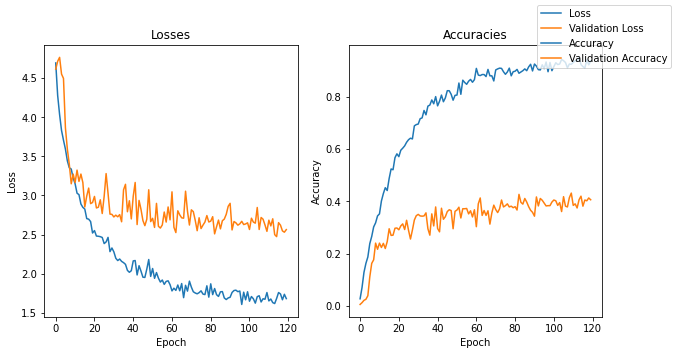

In [8]:
history = {'loss': [4.691838, 4.276268, 4.031423, 3.828753, 3.705361, 3.591934, 3.441362, 3.353112, 3.336454, 3.222274, 3.148939, 3.028161, 3.009241, 2.889917, 2.847333, 2.82526, 2.703725, 2.696419, 2.665666, 2.519472, 2.550749, 2.480729, 2.478044, 2.47283, 2.462629, 2.384542, 2.405859, 2.463725, 2.2817, 2.32811, 2.278553, 2.197068, 2.167698, 2.187094, 2.157024, 2.141102, 2.119175, 2.042169, 2.01783, 2.037791, 2.163179, 2.167907, 1.983791, 2.101916, 2.032504, 1.95501, 1.951952, 2.058391, 2.180869, 1.965242, 2.065961, 1.940768, 2.014242, 1.943073, 1.892967, 1.919108, 1.863096, 1.901464, 1.908841, 1.859799, 1.780102, 1.81455, 1.786439, 1.855315, 1.781422, 1.874139, 1.693769, 1.85139, 1.777091, 1.904609, 1.828321, 1.76916, 1.753137, 1.742947, 1.757667, 1.780874, 1.739186, 1.733214, 1.845117, 1.700249, 1.870365, 1.732678, 1.810273, 1.732112, 1.709411, 1.768053, 1.771212, 1.689701, 1.669788, 1.690108, 1.698817, 1.760116, 1.784937, 1.789326, 1.770156, 1.778539, 1.60699, 1.763501, 1.6663, 1.768936, 1.64807, 1.708027, 1.679555, 1.623605, 1.706348, 1.718079, 1.638586, 1.679751, 1.673167, 1.759134, 1.652068, 1.676365, 1.63036, 1.61847, 1.683233, 1.759, 1.74078, 1.666623, 1.736658, 1.681406], 'accuracy': [0.027451, 0.070588, 0.128431, 0.162745, 0.187255, 0.238235, 0.265686, 0.301961, 0.317647, 0.344118, 0.351961, 0.40098, 0.429412, 0.451961, 0.441176, 0.487255, 0.523529, 0.520588, 0.566667, 0.581373, 0.570588, 0.595098, 0.602941, 0.611765, 0.62549, 0.635294, 0.641176, 0.638235, 0.688235, 0.693137, 0.695098, 0.715686, 0.718627, 0.747059, 0.730392, 0.763726, 0.767647, 0.787255, 0.772549, 0.8, 0.764706, 0.782353, 0.805882, 0.780392, 0.795098, 0.822549, 0.822549, 0.808824, 0.786274, 0.804902, 0.805882, 0.851961, 0.808824, 0.862745, 0.853922, 0.847059, 0.858824, 0.865686, 0.854902, 0.864706, 0.907843, 0.882353, 0.880392, 0.884314, 0.884314, 0.876471, 0.903922, 0.879412, 0.879412, 0.859804, 0.901961, 0.905882, 0.908824, 0.907843, 0.895098, 0.885294, 0.894118, 0.908824, 0.879412, 0.895098, 0.897059, 0.903922, 0.889216, 0.894118, 0.89902, 0.905882, 0.89902, 0.913725, 0.923529, 0.898039, 0.92451, 0.916667, 0.902941, 0.901961, 0.921569, 0.906863, 0.932353, 0.895098, 0.930392, 0.89902, 0.914706, 0.929412, 0.922549, 0.92451, 0.942157, 0.937255, 0.930392, 0.909804, 0.92451, 0.923529, 0.930392, 0.937255, 0.935294, 0.95, 0.922549, 0.914706, 0.908824, 0.941176, 0.921569, 0.936275], 'val_loss': [4.612282, 4.713223, 4.763331, 4.54944, 4.494418, 3.86451, 3.590761, 3.397655, 3.148236, 3.272213, 3.164058, 3.322778, 3.178997, 3.27238, 3.163801, 2.851977, 2.99158, 3.093247, 2.894794, 2.90945, 2.98665, 2.839513, 2.848752, 2.943835, 2.768633, 2.988796, 3.278445, 3.026563, 2.761057, 2.75768, 2.724821, 2.747635, 2.726547, 2.754783, 2.663017, 3.071414, 3.141639, 2.791197, 2.931666, 2.699387, 2.989565, 3.165028, 2.627337, 2.935866, 2.822, 2.678836, 2.613434, 2.695683, 3.071852, 2.665149, 2.707181, 2.590907, 2.897993, 2.605442, 2.582867, 2.622541, 2.787562, 2.659042, 2.852132, 2.687581, 3.045283, 2.592995, 2.52512, 2.803446, 2.751106, 2.713462, 2.7086, 3.053571, 2.797519, 2.621358, 2.815395, 2.792798, 2.680992, 2.548923, 2.714195, 2.576198, 2.620527, 2.659664, 2.742199, 2.660454, 2.67095, 2.728013, 2.508712, 2.598979, 2.684446, 2.572541, 2.676112, 2.697624, 2.758261, 2.860089, 2.89869, 2.558834, 2.666279, 2.649462, 2.619545, 2.636656, 2.668952, 2.627365, 2.635388, 2.649613, 2.564623, 2.708615, 2.65907, 2.645401, 2.845499, 2.564656, 2.717955, 2.695693, 2.622222, 2.540764, 2.683306, 2.610235, 2.701024, 2.49896, 2.47352, 2.651727, 2.619192, 2.546623, 2.529811, 2.56292], 'val_accuracy': [0.005882, 0.012745, 0.021569, 0.02549, 0.039216, 0.110784, 0.162745, 0.176471, 0.240196, 0.216667, 0.240196, 0.223529, 0.239216, 0.219608, 0.246078, 0.295098, 0.269608, 0.270588, 0.297059, 0.298039, 0.291176, 0.305882, 0.313726, 0.292157, 0.327451, 0.289216, 0.255882, 0.290196, 0.328431, 0.345098, 0.35, 0.344118, 0.343137, 0.344118, 0.355882, 0.295098, 0.270588, 0.351961, 0.305882, 0.378431, 0.296078, 0.283333, 0.373529, 0.331373, 0.341176, 0.360784, 0.367647, 0.364706, 0.295098, 0.361765, 0.366667, 0.377451, 0.336275, 0.371569, 0.371569, 0.372549, 0.351961, 0.363725, 0.340196, 0.367647, 0.302941, 0.390196, 0.412745, 0.346078, 0.364706, 0.346078, 0.363725, 0.312745, 0.355882, 0.385294, 0.368627, 0.356863, 0.371569, 0.404902, 0.378431, 0.383333, 0.390196, 0.378431, 0.381373, 0.37549, 0.379412, 0.366667, 0.426471, 0.396078, 0.389216, 0.410784, 0.397059, 0.379412, 0.365686, 0.357843, 0.343137, 0.416667, 0.382353, 0.410784, 0.403922, 0.393137, 0.382353, 0.383333, 0.383333, 0.397059, 0.404902, 0.401961, 0.384314, 0.395098, 0.360784, 0.417647, 0.381373, 0.378431, 0.413725, 0.431373, 0.384314, 0.390196, 0.37451, 0.405882, 0.419608, 0.381373, 0.404902, 0.401961, 0.412745, 0.405882]}

run_summary(history)

## Model 36
* Augmentations:
  * RandomFlip('horizontal')
  * RandomRotation(0.1)
* SpatialDropout2D(r) for Conv layers. r = .05*channels*(1/log(channels, max_channels)/channels)
* depth=4, skips=[], skip_start_depth=2
* heat=1, chill=0, reheat=0, min_channels=32, max_channels=256

0.909804 | 0.437255


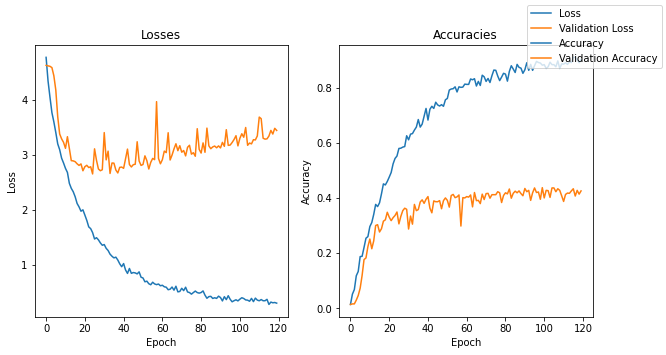

In [9]:
history = {'loss': [4.769127, 4.340512, 4.045332, 3.765495, 3.598325, 3.405281, 3.198281, 3.093817, 2.939366, 2.851946, 2.754151, 2.680564, 2.482397, 2.391627, 2.330066, 2.238612, 2.117148, 2.054914, 1.976498, 2.001777, 1.907041, 1.810277, 1.692406, 1.660223, 1.588083, 1.472071, 1.495928, 1.457152, 1.40161, 1.358597, 1.371298, 1.302754, 1.263349, 1.197406, 1.15926, 1.129356, 1.142711, 1.090734, 1.021981, 0.969369, 1.026242, 0.910151, 0.847461, 0.937355, 0.849117, 0.863324, 0.856746, 0.838921, 0.876126, 0.7787, 0.764752, 0.695487, 0.706976, 0.660317, 0.641813, 0.687675, 0.656783, 0.644112, 0.654946, 0.62292, 0.632886, 0.604936, 0.597377, 0.55168, 0.56091, 0.60045, 0.54341, 0.614691, 0.512808, 0.519887, 0.577658, 0.534955, 0.596806, 0.511003, 0.500054, 0.471446, 0.50007, 0.527249, 0.500014, 0.489838, 0.500746, 0.529892, 0.452658, 0.396434, 0.426538, 0.431366, 0.393184, 0.405787, 0.394298, 0.434615, 0.409538, 0.348398, 0.425644, 0.371484, 0.442628, 0.377291, 0.332609, 0.352501, 0.368746, 0.348721, 0.379726, 0.406314, 0.392064, 0.366351, 0.362016, 0.342626, 0.394268, 0.335315, 0.399225, 0.363133, 0.35124, 0.373009, 0.351452, 0.352004, 0.377183, 0.284376, 0.327281, 0.314314, 0.319853, 0.307974], 'accuracy': [0.013725, 0.05098, 0.067647, 0.117647, 0.133333, 0.187255, 0.188235, 0.220588, 0.253922, 0.259804, 0.296078, 0.310784, 0.340196, 0.376471, 0.368627, 0.382353, 0.414706, 0.45098, 0.447059, 0.459804, 0.47549, 0.492157, 0.523529, 0.543137, 0.551961, 0.579412, 0.580392, 0.584314, 0.586275, 0.62549, 0.610784, 0.631373, 0.633333, 0.646078, 0.656863, 0.684314, 0.656863, 0.667647, 0.696078, 0.72451, 0.682353, 0.721569, 0.732353, 0.72451, 0.747059, 0.737255, 0.733333, 0.738235, 0.732353, 0.755882, 0.760784, 0.791176, 0.795098, 0.796078, 0.802941, 0.784314, 0.802941, 0.80098, 0.801961, 0.812745, 0.811765, 0.811765, 0.831373, 0.828431, 0.832353, 0.805882, 0.822549, 0.807843, 0.845098, 0.839216, 0.822549, 0.833333, 0.818627, 0.843137, 0.863725, 0.862745, 0.842157, 0.82549, 0.838235, 0.851961, 0.84902, 0.823529, 0.858824, 0.879412, 0.867647, 0.854902, 0.884314, 0.873529, 0.870588, 0.851961, 0.864706, 0.890196, 0.862745, 0.884314, 0.862745, 0.879412, 0.895098, 0.891176, 0.889216, 0.881373, 0.883333, 0.869608, 0.87549, 0.892157, 0.883333, 0.883333, 0.87549, 0.897059, 0.869608, 0.886275, 0.885294, 0.890196, 0.884314, 0.893137, 0.891176, 0.909804, 0.909804, 0.90098, 0.890196, 0.901961], 'val_loss': [4.623397, 4.614712, 4.60652, 4.583033, 4.435053, 4.177113, 3.690358, 3.377859, 3.290016, 3.226585, 3.117846, 3.329201, 3.114694, 2.89425, 2.890007, 2.875646, 2.837155, 2.807839, 2.835237, 2.710624, 2.784155, 2.809942, 2.768905, 2.783148, 2.653095, 3.108722, 2.901195, 2.743339, 2.711509, 2.728803, 3.403541, 2.908678, 3.066973, 2.66182, 2.8516, 2.848613, 2.724331, 2.670982, 2.772447, 2.777846, 2.755049, 2.928162, 3.103733, 2.823508, 2.779905, 2.821416, 2.829312, 3.23733, 2.888015, 2.808008, 2.824518, 2.981525, 2.894191, 2.742948, 2.863208, 2.934629, 2.912354, 3.965083, 2.935844, 2.837262, 2.912198, 3.067594, 3.039939, 3.400882, 2.906074, 2.99565, 3.10757, 3.200658, 3.075188, 3.165322, 3.047692, 3.078157, 2.980678, 3.136407, 3.173273, 3.012112, 3.03821, 2.9741, 3.474321, 3.099627, 3.032121, 3.21665, 3.045842, 3.484745, 3.16271, 3.111111, 3.143601, 3.159058, 3.127922, 3.162088, 3.125213, 3.226036, 3.15398, 3.45624, 3.171142, 3.177712, 3.223327, 3.27819, 3.347091, 3.162277, 3.299459, 3.382174, 3.319504, 3.495913, 3.17293, 3.213785, 3.198613, 3.274661, 3.270495, 3.342731, 3.685069, 3.655952, 3.300958, 3.284891, 3.289778, 3.341244, 3.443078, 3.377262, 3.481355, 3.442701], 'val_accuracy': [0.013725, 0.015686, 0.015686, 0.029412, 0.046078, 0.072549, 0.118627, 0.176471, 0.182353, 0.223529, 0.25098, 0.215686, 0.244118, 0.3, 0.302941, 0.276471, 0.288235, 0.315686, 0.320588, 0.348039, 0.330392, 0.317647, 0.328431, 0.336275, 0.34902, 0.305882, 0.333333, 0.353922, 0.362745, 0.358824, 0.287255, 0.334314, 0.304902, 0.376471, 0.353922, 0.357843, 0.385294, 0.393137, 0.380392, 0.395098, 0.404902, 0.362745, 0.346078, 0.389216, 0.386275, 0.386275, 0.390196, 0.360784, 0.390196, 0.4, 0.391176, 0.366667, 0.408824, 0.412745, 0.40098, 0.403922, 0.410784, 0.298039, 0.40098, 0.4, 0.404902, 0.402941, 0.410784, 0.367647, 0.419608, 0.390196, 0.391176, 0.379412, 0.413725, 0.394118, 0.415686, 0.416667, 0.39902, 0.411765, 0.411765, 0.411765, 0.422549, 0.418627, 0.383333, 0.408824, 0.418627, 0.414706, 0.432353, 0.39902, 0.416667, 0.42451, 0.418627, 0.42549, 0.415686, 0.407843, 0.434314, 0.422549, 0.427451, 0.391176, 0.418627, 0.436274, 0.419608, 0.421569, 0.395098, 0.437255, 0.4, 0.427451, 0.426471, 0.401961, 0.436274, 0.436274, 0.422549, 0.433333, 0.427451, 0.407843, 0.387255, 0.412745, 0.417647, 0.416667, 0.42549, 0.433333, 0.406863, 0.427451, 0.413725, 0.42549]}

run_summary(history)

## Model 37
* Augmentations:
  * RandomFlip('horizontal')
  * RandomRotation(0.1)
* SpatialDropout2D(r) for Conv layers. r = .05*channels*(1/log(channels, max_channels)/channels)
* PReLU
* depth=4, skips=[], skip_start_depth=2
* heat=1, chill=0, reheat=0, min_channels=32, max_channels=256

0.934314 | 0.42451


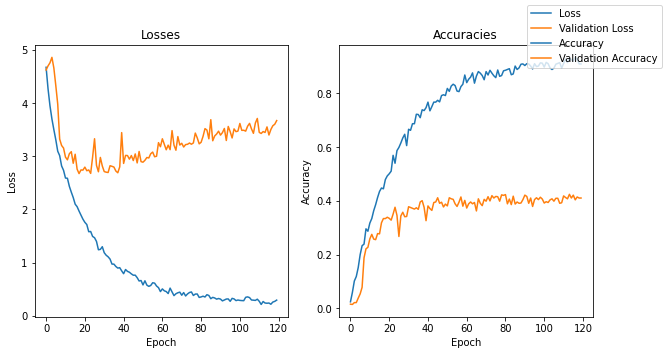

In [10]:
h = {'loss': [4.675407, 4.270043, 3.950401, 3.703284, 3.501958, 3.311793, 3.096228, 3.013055, 2.818737, 2.736836, 2.591176, 2.586968, 2.434934, 2.325761, 2.224203, 2.09981, 2.052365, 1.969674, 1.892984, 1.817453, 1.758078, 1.716457, 1.581172, 1.585063, 1.492557, 1.468178, 1.39846, 1.24163, 1.248838, 1.298868, 1.186123, 1.138678, 1.109006, 1.065988, 0.972151, 0.971235, 0.926789, 0.89686, 0.904257, 0.845278, 0.791112, 0.869796, 0.835085, 0.818438, 0.787779, 0.762695, 0.763538, 0.716181, 0.654016, 0.662812, 0.580376, 0.657309, 0.576861, 0.552702, 0.569753, 0.620702, 0.613432, 0.559406, 0.528706, 0.454604, 0.504892, 0.469244, 0.455041, 0.417582, 0.519967, 0.448172, 0.378534, 0.413927, 0.432446, 0.444096, 0.386164, 0.435836, 0.371937, 0.410882, 0.437304, 0.44766, 0.381353, 0.407887, 0.409202, 0.344668, 0.354202, 0.367826, 0.352836, 0.396048, 0.380888, 0.320634, 0.345906, 0.334195, 0.312225, 0.324214, 0.313342, 0.279637, 0.296333, 0.314217, 0.316572, 0.271316, 0.327144, 0.316655, 0.284751, 0.295825, 0.2887, 0.285349, 0.283475, 0.347144, 0.354681, 0.341355, 0.29622, 0.292964, 0.288808, 0.311481, 0.271929, 0.212581, 0.267645, 0.23946, 0.235467, 0.239351, 0.216494, 0.257255, 0.270491, 0.294159], 'accuracy': [0.02451, 0.059804, 0.101961, 0.118627, 0.151961, 0.2, 0.233333, 0.239216, 0.296078, 0.287255, 0.317647, 0.334314, 0.363725, 0.386275, 0.412745, 0.435294, 0.448039, 0.445098, 0.479412, 0.493137, 0.50098, 0.510784, 0.569608, 0.540196, 0.587255, 0.59902, 0.615686, 0.634314, 0.648039, 0.605882, 0.666667, 0.662745, 0.687255, 0.687255, 0.722549, 0.721569, 0.709804, 0.739216, 0.736274, 0.747059, 0.767647, 0.735294, 0.75098, 0.767647, 0.767647, 0.77451, 0.768627, 0.792157, 0.795098, 0.792157, 0.818627, 0.807843, 0.827451, 0.834314, 0.829412, 0.808824, 0.806863, 0.82549, 0.834314, 0.868627, 0.840196, 0.852941, 0.860784, 0.876471, 0.838235, 0.864706, 0.881373, 0.87549, 0.866667, 0.85098, 0.881373, 0.868627, 0.886275, 0.87549, 0.865686, 0.858824, 0.887255, 0.863725, 0.866667, 0.884314, 0.886275, 0.889216, 0.892157, 0.869608, 0.872549, 0.901961, 0.889216, 0.895098, 0.908824, 0.909804, 0.903922, 0.910784, 0.909804, 0.901961, 0.891176, 0.910784, 0.9, 0.901961, 0.913725, 0.912745, 0.898039, 0.915686, 0.910784, 0.895098, 0.889216, 0.894118, 0.908824, 0.911765, 0.914706, 0.894118, 0.911765, 0.927451, 0.914706, 0.931373, 0.92549, 0.920588, 0.934314, 0.927451, 0.909804, 0.909804], 'val_loss': [4.624426, 4.702014, 4.759938, 4.862288, 4.661999, 4.332377, 3.982042, 3.323814, 3.203458, 3.155535, 2.984593, 2.933983, 3.048357, 3.087276, 2.869247, 3.038944, 2.758621, 2.675461, 2.744023, 2.740239, 2.79686, 2.728779, 2.743316, 2.678981, 2.98472, 3.330867, 2.831404, 2.709395, 2.979024, 2.818055, 2.712826, 2.701627, 2.695429, 2.823023, 2.81153, 2.79766, 2.723334, 2.690278, 2.802112, 3.446098, 2.866221, 3.01685, 3.01458, 2.946319, 3.014296, 2.920552, 3.044922, 2.875899, 3.091395, 2.900386, 2.889195, 2.925255, 2.977631, 2.968875, 3.048946, 3.079633, 2.991918, 3.001361, 3.257381, 3.180632, 3.329836, 3.226573, 3.123247, 3.210221, 3.125218, 3.483504, 3.210105, 3.114747, 3.371812, 3.212046, 3.245206, 3.175116, 3.220772, 3.226426, 3.250311, 3.227743, 3.251558, 3.437334, 3.347238, 3.234524, 3.264593, 3.376552, 3.521145, 3.49385, 3.329704, 3.689687, 3.292888, 3.383148, 3.419517, 3.473288, 3.399084, 3.445923, 3.52373, 3.297775, 3.56144, 3.463921, 3.345423, 3.516137, 3.464684, 3.47419, 3.618125, 3.48852, 3.490553, 3.473821, 3.567019, 3.619748, 3.516287, 3.432784, 3.62663, 3.712404, 3.4503, 3.42997, 3.465806, 3.449121, 3.553391, 3.401183, 3.50438, 3.57473, 3.603442, 3.67237], 'val_accuracy': [0.015686, 0.014706, 0.021569, 0.021569, 0.038235, 0.053922, 0.078431, 0.188235, 0.221569, 0.227451, 0.258824, 0.27549, 0.257843, 0.255882, 0.278431, 0.277451, 0.318627, 0.334314, 0.334314, 0.339216, 0.335294, 0.328431, 0.35098, 0.376471, 0.346078, 0.267647, 0.344118, 0.357843, 0.341176, 0.342157, 0.378431, 0.37549, 0.372549, 0.369608, 0.37451, 0.368627, 0.396078, 0.40098, 0.376471, 0.326471, 0.381373, 0.371569, 0.364706, 0.394118, 0.396078, 0.411765, 0.391176, 0.395098, 0.377451, 0.388235, 0.381373, 0.411765, 0.407843, 0.405882, 0.389216, 0.379412, 0.395098, 0.414706, 0.380392, 0.401961, 0.373529, 0.389216, 0.396078, 0.389216, 0.394118, 0.362745, 0.407843, 0.391176, 0.382353, 0.405882, 0.39902, 0.415686, 0.4, 0.419608, 0.410784, 0.416667, 0.415686, 0.39902, 0.422549, 0.420588, 0.423529, 0.389216, 0.406863, 0.386275, 0.417647, 0.388235, 0.396078, 0.391176, 0.392157, 0.404902, 0.421569, 0.416667, 0.391176, 0.410784, 0.379412, 0.404902, 0.411765, 0.404902, 0.413725, 0.406863, 0.392157, 0.397059, 0.394118, 0.403922, 0.407843, 0.39902, 0.409804, 0.409804, 0.391176, 0.393137, 0.418627, 0.412745, 0.407843, 0.42451, 0.410784, 0.421569, 0.403922, 0.414706, 0.410784, 0.410784]}

run_summary(h)

## Model 39
* Augmentations:
  * RandomFlip('horizontal')
  * RandomRotation(0.1)
* SpatialDropout2D(r) for Conv layers. r = .05*channels*(1/log(channels, max_channels)/channels)
* Squeeze and Excitation Blocks.
* depth=4, skips=[], skip_start_depth=2
* heat=1, chill=0, reheat=0, min_channels=32, max_channels=256

0.911765 | 0.429412


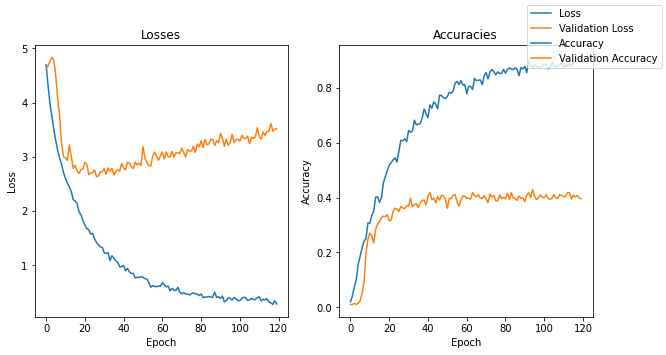

In [11]:
h = {'loss': [4.7024, 4.319859, 3.978491, 3.74622, 3.499175, 3.295634, 3.11418, 2.976319, 2.857847, 2.708395, 2.602305, 2.515374, 2.449884, 2.357404, 2.208704, 2.1863, 2.135463, 1.987348, 1.929515, 1.828374, 1.739585, 1.678492, 1.65485, 1.574043, 1.590874, 1.489801, 1.420579, 1.378157, 1.338289, 1.331859, 1.228973, 1.217557, 1.231251, 1.087246, 1.175363, 1.128831, 1.082881, 1.051245, 0.96974, 0.974248, 0.99848, 0.897999, 0.939567, 0.877533, 0.848986, 0.849523, 0.764361, 0.778604, 0.773908, 0.786481, 0.780756, 0.750479, 0.74545, 0.684444, 0.594452, 0.625408, 0.607745, 0.604787, 0.617721, 0.613153, 0.678437, 0.635473, 0.600014, 0.615238, 0.527678, 0.573484, 0.535216, 0.535652, 0.594278, 0.50267, 0.473961, 0.49569, 0.470362, 0.469643, 0.452054, 0.47481, 0.492527, 0.471178, 0.47096, 0.439671, 0.469027, 0.403155, 0.414277, 0.411726, 0.424538, 0.411151, 0.41336, 0.504312, 0.407742, 0.419795, 0.387606, 0.431291, 0.323539, 0.348353, 0.39777, 0.390632, 0.357466, 0.406568, 0.379344, 0.350209, 0.349507, 0.390383, 0.409314, 0.402831, 0.34948, 0.359496, 0.387371, 0.367176, 0.371036, 0.401808, 0.418534, 0.343647, 0.374947, 0.362094, 0.38435, 0.318269, 0.307486, 0.276886, 0.343071, 0.287587], 'accuracy': [0.019608, 0.041176, 0.07451, 0.10098, 0.156863, 0.186275, 0.215686, 0.241176, 0.25098, 0.306863, 0.305882, 0.334314, 0.35098, 0.40098, 0.402941, 0.382353, 0.40098, 0.453922, 0.476471, 0.49902, 0.518627, 0.527451, 0.537255, 0.545098, 0.529412, 0.569608, 0.608824, 0.606863, 0.614706, 0.603922, 0.645098, 0.638235, 0.642157, 0.682353, 0.665686, 0.667647, 0.669608, 0.690196, 0.723529, 0.705882, 0.691176, 0.738235, 0.726471, 0.74902, 0.741176, 0.723529, 0.773529, 0.772549, 0.763726, 0.761765, 0.768627, 0.784314, 0.780392, 0.789216, 0.817647, 0.823529, 0.812745, 0.826471, 0.810784, 0.812745, 0.779412, 0.805882, 0.805882, 0.794118, 0.835294, 0.826471, 0.828431, 0.829412, 0.811765, 0.845098, 0.855882, 0.833333, 0.857843, 0.867647, 0.859804, 0.848039, 0.858824, 0.852941, 0.852941, 0.867647, 0.853922, 0.867647, 0.873529, 0.869608, 0.866667, 0.873529, 0.867647, 0.845098, 0.87451, 0.869608, 0.878431, 0.855882, 0.9, 0.883333, 0.87549, 0.884314, 0.880392, 0.873529, 0.87549, 0.881373, 0.884314, 0.887255, 0.869608, 0.873529, 0.893137, 0.883333, 0.877451, 0.880392, 0.885294, 0.891176, 0.873529, 0.885294, 0.878431, 0.889216, 0.879412, 0.892157, 0.902941, 0.911765, 0.9, 0.911765], 'val_loss': [4.630605, 4.677082, 4.767962, 4.835763, 4.779144, 4.494205, 4.069789, 3.754801, 3.234488, 2.999638, 2.98101, 2.933844, 3.221687, 3.002556, 2.787577, 2.84478, 2.740908, 2.694851, 2.766198, 2.7786, 2.899383, 2.862982, 2.667905, 2.70679, 2.706705, 2.761666, 2.632932, 2.645469, 2.724681, 2.72794, 2.783564, 2.677341, 2.793704, 2.737454, 2.790257, 2.664508, 2.733289, 2.763508, 2.736628, 2.879907, 2.792464, 2.761017, 2.900419, 2.886637, 2.819448, 2.783575, 2.902731, 2.850649, 2.88202, 2.839972, 3.18525, 2.975927, 2.89663, 2.83751, 2.830404, 3.00669, 3.088779, 3.011867, 2.939987, 3.018728, 3.087278, 2.962, 3.09063, 3.001058, 2.997334, 3.098073, 2.992635, 3.076277, 3.073716, 3.061617, 3.161045, 3.083839, 2.996748, 3.135113, 3.103338, 3.110009, 3.194536, 3.083066, 3.238331, 3.185591, 3.293797, 3.168958, 3.319913, 3.222537, 3.237233, 3.319791, 3.322634, 3.211786, 3.295173, 3.263024, 3.432287, 3.340708, 3.1951, 3.329255, 3.213153, 3.264366, 3.414176, 3.265348, 3.316699, 3.328488, 3.285589, 3.39645, 3.343359, 3.341242, 3.383136, 3.242516, 3.363782, 3.339998, 3.363308, 3.537354, 3.378104, 3.326389, 3.459207, 3.393594, 3.466934, 3.470942, 3.615475, 3.47367, 3.512888, 3.518055], 'val_accuracy': [0.009804, 0.009804, 0.013725, 0.009804, 0.014706, 0.023529, 0.04902, 0.090196, 0.198039, 0.248039, 0.269608, 0.259804, 0.234314, 0.284314, 0.302941, 0.312745, 0.326471, 0.332353, 0.330392, 0.337255, 0.314706, 0.318627, 0.348039, 0.360784, 0.357843, 0.34902, 0.367647, 0.361765, 0.359804, 0.370588, 0.369608, 0.397059, 0.365686, 0.37451, 0.377451, 0.363725, 0.380392, 0.390196, 0.390196, 0.373529, 0.404902, 0.418627, 0.392157, 0.398039, 0.380392, 0.402941, 0.391176, 0.408824, 0.405882, 0.393137, 0.360784, 0.397059, 0.396078, 0.407843, 0.410784, 0.384314, 0.367647, 0.390196, 0.405882, 0.404902, 0.397059, 0.398039, 0.394118, 0.418627, 0.407843, 0.401961, 0.410784, 0.397059, 0.397059, 0.406863, 0.395098, 0.381373, 0.412745, 0.401961, 0.407843, 0.388235, 0.387255, 0.409804, 0.396078, 0.40098, 0.395098, 0.415686, 0.393137, 0.417647, 0.39902, 0.397059, 0.389216, 0.405882, 0.397059, 0.39902, 0.385294, 0.408824, 0.417647, 0.4, 0.429412, 0.405882, 0.393137, 0.39902, 0.409804, 0.40098, 0.39902, 0.410784, 0.396078, 0.394118, 0.397059, 0.410784, 0.39902, 0.398039, 0.410784, 0.407843, 0.403922, 0.403922, 0.417647, 0.418627, 0.394118, 0.408824, 0.401961, 0.407843, 0.39902, 0.395098]}

run_summary(h)

## Model 40
* Augmentations:
  * RandomFlip('horizontal')
  * RandomRotation(0.1)
* SpatialDropout2D(r) for Conv layers. r = .05*channels*(1/log(channels, max_channels)/channels)
* depth=4, skips=[], skip_start_depth=2
* heat=1, chill=1, reheat=0, min_channels=32, max_channels=256

0.987255 | 0.372549


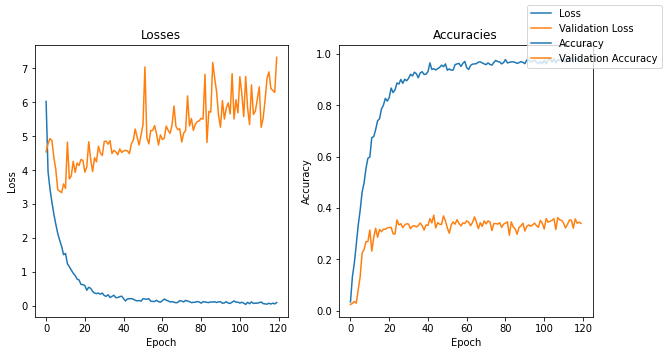

In [12]:
h = {'loss': [6.027091, 3.959888, 3.445726, 3.056492, 2.704421, 2.40512, 2.13676, 1.933864, 1.758438, 1.508735, 1.546535, 1.242301, 1.150895, 1.053274, 0.960303, 0.893592, 0.788494, 0.762739, 0.631229, 0.62489, 0.596146, 0.459558, 0.54766, 0.514798, 0.42571, 0.37459, 0.36137, 0.375989, 0.343769, 0.375938, 0.303699, 0.28128, 0.325764, 0.245863, 0.277539, 0.312961, 0.23745, 0.245741, 0.27159, 0.284244, 0.210144, 0.142955, 0.205792, 0.209181, 0.212556, 0.19628, 0.162753, 0.14634, 0.158425, 0.13636, 0.211471, 0.199952, 0.196248, 0.208336, 0.137525, 0.129511, 0.126954, 0.162939, 0.122921, 0.107026, 0.153989, 0.199074, 0.165773, 0.145026, 0.116706, 0.12099, 0.108778, 0.090568, 0.10121, 0.153916, 0.140926, 0.115287, 0.160466, 0.140613, 0.12343, 0.093769, 0.103653, 0.106763, 0.125666, 0.115594, 0.079521, 0.120884, 0.115176, 0.102272, 0.097132, 0.114632, 0.11141, 0.120295, 0.09727, 0.118962, 0.120613, 0.077336, 0.085636, 0.121935, 0.081057, 0.070178, 0.109014, 0.144687, 0.107543, 0.108243, 0.080952, 0.104754, 0.080825, 0.040923, 0.103764, 0.060522, 0.115581, 0.071044, 0.078675, 0.077163, 0.095479, 0.11272, 0.065947, 0.056659, 0.049885, 0.075837, 0.05255, 0.079413, 0.056331, 0.097419], 'accuracy': [0.034314, 0.132353, 0.185294, 0.258824, 0.333333, 0.391176, 0.461765, 0.497059, 0.553922, 0.594118, 0.59902, 0.67451, 0.678431, 0.705882, 0.740196, 0.748039, 0.786274, 0.80098, 0.827451, 0.816667, 0.830392, 0.867647, 0.85, 0.860784, 0.887255, 0.883333, 0.90098, 0.886275, 0.901961, 0.896078, 0.905882, 0.921569, 0.914706, 0.929412, 0.923529, 0.907843, 0.926471, 0.931373, 0.920588, 0.921569, 0.931373, 0.965686, 0.940196, 0.943137, 0.938235, 0.943137, 0.948039, 0.956863, 0.95098, 0.961765, 0.937255, 0.942157, 0.937255, 0.938235, 0.958824, 0.961765, 0.963726, 0.951961, 0.963726, 0.971569, 0.947059, 0.940196, 0.955882, 0.960784, 0.961765, 0.962745, 0.968627, 0.969608, 0.965686, 0.961765, 0.958824, 0.965686, 0.959804, 0.956863, 0.967647, 0.97549, 0.970588, 0.969608, 0.961765, 0.966667, 0.978431, 0.965686, 0.967647, 0.969608, 0.969608, 0.967647, 0.963726, 0.966667, 0.970588, 0.967647, 0.962745, 0.976471, 0.977451, 0.970588, 0.970588, 0.976471, 0.968627, 0.962745, 0.970588, 0.961765, 0.977451, 0.961765, 0.977451, 0.982353, 0.968627, 0.981373, 0.965686, 0.978431, 0.97549, 0.978431, 0.97451, 0.967647, 0.977451, 0.981373, 0.986274, 0.968627, 0.987255, 0.979412, 0.980392, 0.977451], 'val_loss': [4.539631, 4.781714, 4.931859, 4.869245, 4.374658, 4.02186, 3.422522, 3.378761, 3.336968, 3.592732, 3.461431, 4.826663, 3.738086, 3.832938, 4.258058, 3.932679, 4.208887, 4.136939, 4.313088, 4.287398, 3.940444, 4.092386, 4.836467, 4.322036, 3.956581, 4.367504, 4.244221, 4.702746, 4.507693, 4.432634, 4.842737, 4.854234, 4.765297, 4.869041, 4.489295, 4.583778, 4.537772, 4.454552, 4.62425, 4.522656, 4.564079, 4.586534, 4.563574, 4.487406, 4.775974, 4.884006, 5.212052, 4.963913, 4.740111, 5.037303, 5.347339, 7.041428, 4.963017, 4.773032, 5.169073, 5.167922, 5.313385, 5.060613, 4.741044, 5.039736, 4.901383, 4.944931, 5.298079, 5.172406, 5.084925, 5.331374, 5.890161, 5.290501, 5.193722, 5.220307, 4.827943, 5.091805, 5.169533, 6.187649, 5.303585, 5.520792, 5.169867, 5.348918, 5.431663, 5.450487, 5.527015, 5.506242, 6.825463, 4.816808, 5.728804, 5.710034, 7.173653, 6.713927, 6.303881, 5.610773, 5.265591, 6.048535, 5.505582, 5.829972, 5.983694, 5.656394, 6.84345, 5.506135, 6.074416, 5.68888, 6.751909, 6.261259, 5.578928, 6.760081, 5.829122, 5.34092, 6.512184, 5.642515, 5.738689, 6.085386, 6.454582, 5.261139, 5.52494, 6.053045, 6.699733, 6.896951, 6.409244, 6.348388, 6.292963, 7.324522], 'val_accuracy': [0.02451, 0.028431, 0.036275, 0.029412, 0.082353, 0.132353, 0.22549, 0.238235, 0.268627, 0.269608, 0.314706, 0.232353, 0.285294, 0.321569, 0.286275, 0.316667, 0.307843, 0.317647, 0.317647, 0.322549, 0.32451, 0.32451, 0.3, 0.29902, 0.353922, 0.334314, 0.339216, 0.323529, 0.334314, 0.339216, 0.337255, 0.319608, 0.329412, 0.331373, 0.326471, 0.331373, 0.342157, 0.331373, 0.314706, 0.334314, 0.332353, 0.358824, 0.342157, 0.372549, 0.322549, 0.343137, 0.337255, 0.336275, 0.369608, 0.35, 0.322549, 0.301961, 0.334314, 0.346078, 0.337255, 0.354902, 0.340196, 0.330392, 0.342157, 0.340196, 0.35, 0.345098, 0.331373, 0.344118, 0.365686, 0.345098, 0.319608, 0.343137, 0.328431, 0.35, 0.338235, 0.35, 0.346078, 0.312745, 0.339216, 0.340196, 0.337255, 0.343137, 0.32451, 0.337255, 0.341176, 0.346078, 0.294118, 0.346078, 0.326471, 0.318627, 0.298039, 0.32451, 0.330392, 0.341176, 0.310784, 0.328431, 0.334314, 0.329412, 0.334314, 0.341176, 0.331373, 0.32549, 0.351961, 0.341176, 0.318627, 0.358824, 0.345098, 0.34902, 0.351961, 0.358824, 0.316667, 0.362745, 0.353922, 0.351961, 0.341176, 0.322549, 0.336275, 0.353922, 0.352941, 0.321569, 0.357843, 0.341176, 0.345098, 0.340196]}

run_summary(h)

## Model 41
* Augmentations:
  * RandomFlip('horizontal')
  * RandomRotation(0.1)
* SpatialDropout2D(r) for Conv layers. r = .05*channels*(1/log(channels, max_channels)/channels)
* depth=4, skips=[], skip_start_depth=2
* heat=1, chill=1, reheat=0, min_channels=32, max_channels=256
* MaxPool(2) follows both heat and chill convs.

0.952941 | 0.42549


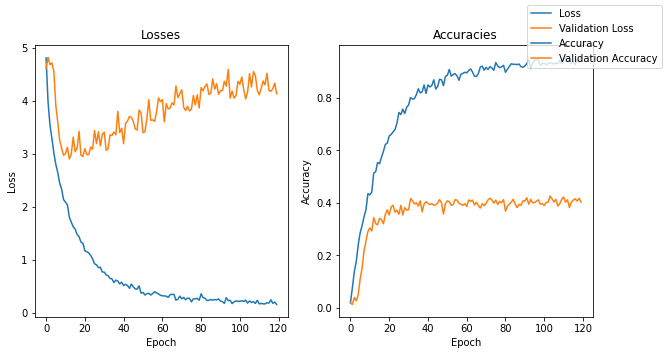

In [13]:
h = {'loss': [4.806087, 3.975595, 3.543749, 3.283319, 3.015757, 2.800506, 2.648532, 2.448866, 2.334273, 2.137106, 2.088995, 2.037766, 1.800558, 1.712544, 1.62317, 1.579338, 1.479129, 1.437021, 1.33487, 1.312453, 1.17086, 1.154361, 1.130477, 1.08343, 1.017883, 0.925676, 0.907919, 0.852842, 0.860931, 0.77214, 0.769868, 0.716325, 0.702718, 0.648448, 0.641899, 0.571408, 0.618611, 0.601344, 0.54746, 0.579837, 0.515082, 0.539872, 0.517421, 0.463838, 0.544293, 0.489414, 0.453303, 0.447826, 0.509308, 0.37291, 0.387634, 0.338041, 0.363109, 0.3705, 0.338012, 0.365661, 0.400885, 0.378535, 0.359125, 0.333555, 0.322918, 0.320075, 0.31699, 0.291675, 0.34417, 0.349748, 0.35009, 0.241235, 0.257908, 0.316454, 0.267364, 0.292296, 0.249687, 0.279275, 0.275262, 0.209281, 0.265781, 0.265494, 0.273851, 0.238303, 0.359331, 0.288517, 0.277143, 0.234182, 0.238685, 0.253375, 0.24202, 0.252394, 0.246275, 0.264916, 0.222985, 0.213329, 0.180588, 0.287879, 0.232084, 0.237502, 0.17568, 0.210557, 0.225706, 0.221073, 0.21924, 0.228591, 0.217083, 0.241884, 0.186575, 0.226096, 0.197175, 0.213402, 0.179323, 0.238322, 0.170638, 0.179801, 0.172221, 0.170599, 0.192163, 0.186018, 0.246974, 0.182844, 0.20442, 0.160163], 'accuracy': [0.019608, 0.077451, 0.138235, 0.176471, 0.239216, 0.285294, 0.312745, 0.346078, 0.373529, 0.434314, 0.429412, 0.440196, 0.512745, 0.517647, 0.552941, 0.548039, 0.572549, 0.595098, 0.621569, 0.626471, 0.653922, 0.659804, 0.669608, 0.678431, 0.702941, 0.743137, 0.735294, 0.755882, 0.739216, 0.762745, 0.771569, 0.8, 0.794118, 0.796078, 0.810784, 0.833333, 0.817647, 0.821569, 0.848039, 0.815686, 0.848039, 0.840196, 0.846078, 0.867647, 0.832353, 0.842157, 0.869608, 0.867647, 0.845098, 0.880392, 0.884314, 0.906863, 0.881373, 0.887255, 0.891176, 0.882353, 0.865686, 0.888235, 0.892157, 0.896078, 0.894118, 0.902941, 0.908824, 0.897059, 0.881373, 0.880392, 0.891176, 0.915686, 0.919608, 0.903922, 0.914706, 0.906863, 0.917647, 0.911765, 0.903922, 0.933333, 0.920588, 0.913725, 0.916667, 0.922549, 0.896078, 0.907843, 0.918627, 0.928431, 0.926471, 0.926471, 0.92549, 0.927451, 0.917647, 0.914706, 0.920588, 0.929412, 0.944118, 0.909804, 0.931373, 0.940196, 0.946078, 0.940196, 0.922549, 0.930392, 0.929412, 0.92549, 0.928431, 0.932353, 0.931373, 0.927451, 0.931373, 0.928431, 0.942157, 0.929412, 0.952941, 0.94902, 0.935294, 0.947059, 0.929412, 0.938235, 0.926471, 0.943137, 0.934314, 0.95098], 'val_loss': [4.610834, 4.816574, 4.680699, 4.713748, 4.55175, 3.913412, 3.602311, 3.25382, 3.105855, 2.970636, 3.00136, 3.120951, 2.900613, 2.995918, 3.312733, 3.038717, 3.101292, 3.423093, 2.969772, 2.94877, 3.096351, 2.986286, 2.982264, 3.128335, 3.084434, 3.438994, 3.189054, 3.414443, 3.148692, 3.365425, 3.407794, 3.063826, 3.093489, 3.355759, 3.346099, 3.410481, 3.356361, 3.800399, 3.396491, 3.48124, 3.188816, 3.573285, 3.615305, 3.702084, 3.685419, 3.606193, 3.468904, 3.446943, 3.823979, 3.773342, 3.398804, 3.412032, 3.660423, 4.018162, 3.630409, 3.638339, 3.611304, 3.784819, 4.052328, 3.981586, 4.020218, 3.601968, 3.944679, 3.844203, 3.863467, 3.958675, 3.919821, 4.278323, 4.056675, 4.128414, 4.207123, 3.87858, 3.81314, 3.894835, 3.807333, 3.83705, 4.098893, 3.9201, 4.11042, 3.861383, 4.245074, 4.186081, 4.270714, 4.31507, 4.118489, 4.137959, 4.411105, 4.21713, 4.320766, 4.121429, 4.185314, 4.194553, 4.366442, 4.272413, 4.588829, 4.047333, 4.179847, 4.048872, 4.09814, 4.364607, 4.308999, 4.446993, 4.209517, 4.032029, 4.167424, 4.511334, 4.257306, 4.54816, 4.472382, 4.198225, 4.109954, 4.234269, 4.370694, 4.299157, 4.516973, 4.19433, 4.17634, 4.228085, 4.329623, 4.130206], 'val_accuracy': [0.017647, 0.012745, 0.039216, 0.026471, 0.04902, 0.109804, 0.15098, 0.216667, 0.253922, 0.290196, 0.303922, 0.292157, 0.343137, 0.320588, 0.315686, 0.340196, 0.335294, 0.319608, 0.355882, 0.372549, 0.352941, 0.384314, 0.390196, 0.363725, 0.371569, 0.355882, 0.390196, 0.352941, 0.381373, 0.371569, 0.373529, 0.415686, 0.406863, 0.395098, 0.39902, 0.387255, 0.406863, 0.364706, 0.395098, 0.403922, 0.397059, 0.393137, 0.396078, 0.390196, 0.392157, 0.39902, 0.411765, 0.39902, 0.356863, 0.397059, 0.406863, 0.403922, 0.390196, 0.392157, 0.411765, 0.409804, 0.398039, 0.394118, 0.390196, 0.396078, 0.385294, 0.410784, 0.404902, 0.409804, 0.391176, 0.40098, 0.389216, 0.379412, 0.396078, 0.388235, 0.397059, 0.410784, 0.416667, 0.410784, 0.398039, 0.409804, 0.393137, 0.404902, 0.4, 0.411765, 0.367647, 0.387255, 0.394118, 0.401961, 0.412745, 0.395098, 0.381373, 0.393137, 0.390196, 0.406863, 0.405882, 0.418627, 0.394118, 0.412745, 0.4, 0.4, 0.405882, 0.410784, 0.394118, 0.396078, 0.389216, 0.40098, 0.401961, 0.42549, 0.414706, 0.402941, 0.412745, 0.387255, 0.396078, 0.412745, 0.421569, 0.401961, 0.410784, 0.381373, 0.401961, 0.409804, 0.414706, 0.405882, 0.416667, 0.401961]}

run_summary(h)

## Model 43
* Augmentations:
  * RandomFlip('horizontal')
  * RandomRotation(0.1)
* depth=4, skips=[], skip_start_depth=2
* heat=1, chill=1, reheat=0, min_channels=32, max_channels=256
* MaxPool(2) follows both heat and chill convs.
* Two concatenated backbones are fed to the final dense layer.

0.978431 | 0.471569


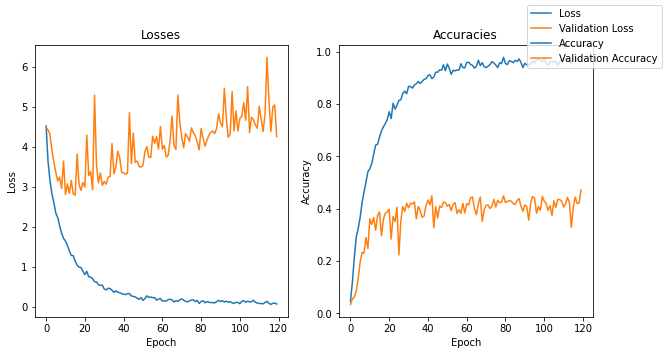

In [14]:
h = {'loss': [4.521698, 3.63662, 3.155434, 2.827789, 2.610751, 2.347147, 2.235471, 2.027113, 1.845575, 1.717729, 1.649021, 1.538446, 1.39982, 1.288324, 1.283077, 1.149356, 1.04979, 0.994986, 0.98605, 0.89332, 0.808886, 0.893617, 0.753006, 0.74932, 0.709585, 0.633821, 0.628292, 0.560215, 0.541178, 0.546194, 0.451222, 0.430119, 0.469327, 0.463132, 0.423663, 0.364764, 0.406422, 0.370683, 0.359935, 0.332183, 0.321145, 0.311821, 0.336757, 0.338302, 0.278441, 0.265274, 0.251397, 0.222991, 0.193462, 0.23846, 0.165994, 0.215202, 0.281426, 0.239899, 0.254281, 0.232889, 0.238633, 0.172908, 0.196934, 0.214214, 0.148024, 0.15455, 0.151853, 0.184831, 0.195924, 0.178747, 0.1253, 0.160973, 0.142661, 0.181742, 0.204315, 0.172722, 0.14546, 0.129293, 0.15604, 0.174828, 0.183215, 0.136189, 0.164283, 0.09013, 0.138199, 0.1581, 0.108132, 0.133933, 0.125095, 0.109313, 0.113905, 0.103441, 0.135239, 0.169902, 0.138172, 0.159411, 0.124988, 0.146385, 0.121592, 0.135075, 0.104647, 0.090433, 0.119261, 0.114631, 0.084036, 0.146425, 0.158181, 0.122285, 0.146632, 0.129548, 0.131946, 0.168765, 0.120726, 0.098804, 0.089573, 0.087006, 0.081927, 0.11352, 0.142275, 0.094371, 0.065457, 0.093454, 0.099643, 0.076441], 'accuracy': [0.046078, 0.118627, 0.213725, 0.292157, 0.323529, 0.366667, 0.423529, 0.463725, 0.50098, 0.541176, 0.552941, 0.572549, 0.608824, 0.643137, 0.646078, 0.673529, 0.697059, 0.712745, 0.72549, 0.741176, 0.770588, 0.744118, 0.802941, 0.780392, 0.795098, 0.813725, 0.816667, 0.840196, 0.84902, 0.839216, 0.867647, 0.866667, 0.860784, 0.872549, 0.877451, 0.886275, 0.878431, 0.886275, 0.894118, 0.897059, 0.908824, 0.911765, 0.897059, 0.902941, 0.921569, 0.921569, 0.930392, 0.929412, 0.95, 0.927451, 0.952941, 0.936275, 0.913725, 0.929412, 0.926471, 0.930392, 0.929412, 0.953922, 0.939216, 0.938235, 0.958824, 0.959804, 0.95098, 0.948039, 0.937255, 0.944118, 0.967647, 0.947059, 0.957843, 0.943137, 0.939216, 0.944118, 0.95098, 0.961765, 0.956863, 0.94902, 0.939216, 0.957843, 0.954902, 0.978431, 0.954902, 0.95098, 0.965686, 0.962745, 0.957843, 0.966667, 0.962745, 0.972549, 0.958824, 0.939216, 0.955882, 0.95, 0.95, 0.954902, 0.964706, 0.956863, 0.968627, 0.971569, 0.965686, 0.961765, 0.973529, 0.955882, 0.94902, 0.961765, 0.963726, 0.958824, 0.964706, 0.948039, 0.962745, 0.967647, 0.973529, 0.971569, 0.969608, 0.962745, 0.956863, 0.972549, 0.978431, 0.966667, 0.971569, 0.97549], 'val_loss': [4.485058, 4.421361, 4.311796, 3.918554, 3.632202, 3.365289, 3.143423, 3.247014, 2.964241, 3.646802, 2.809257, 3.072959, 2.836615, 3.161572, 2.817885, 2.796301, 3.818154, 3.060167, 2.912772, 3.111278, 2.996755, 4.293868, 3.282087, 3.386249, 2.926286, 5.291378, 3.551075, 3.102205, 3.350258, 3.039655, 3.136294, 3.068366, 3.240975, 3.252088, 4.084249, 3.328387, 3.49175, 3.890427, 3.724595, 3.359937, 3.353698, 3.319645, 3.342536, 4.851842, 3.581921, 4.3435, 3.611848, 3.646655, 3.509205, 3.493899, 3.538433, 3.878757, 4.007874, 3.750268, 3.734909, 4.267345, 4.088327, 4.252367, 3.942126, 4.510698, 3.942175, 4.034519, 3.743128, 3.790118, 4.159791, 4.771021, 4.034336, 3.937416, 5.295959, 4.613044, 4.241203, 3.975955, 4.33174, 4.24584, 4.142212, 4.475521, 4.349011, 4.277002, 4.116601, 3.925365, 4.459087, 4.214263, 4.018342, 4.162313, 4.288465, 4.362953, 4.396201, 4.329243, 4.463969, 4.821362, 4.60914, 4.502043, 5.463678, 4.714268, 4.239643, 4.316982, 5.379203, 4.400927, 4.895657, 4.394238, 4.708668, 4.762872, 5.105372, 4.664854, 5.503276, 4.353786, 4.738316, 4.677919, 4.549502, 4.467083, 5.013855, 4.68036, 4.381483, 4.814456, 6.234994, 5.16014, 4.381874, 4.996616, 5.046361, 4.25512], 'val_accuracy': [0.033333, 0.053922, 0.061765, 0.086275, 0.132353, 0.196078, 0.232353, 0.229412, 0.289216, 0.247059, 0.360784, 0.339216, 0.365686, 0.317647, 0.373529, 0.387255, 0.296078, 0.358824, 0.382353, 0.387255, 0.398039, 0.283333, 0.369608, 0.35098, 0.404902, 0.222549, 0.352941, 0.407843, 0.389216, 0.420588, 0.402941, 0.420588, 0.417647, 0.42549, 0.360784, 0.407843, 0.392157, 0.366667, 0.371569, 0.411765, 0.432353, 0.414706, 0.44902, 0.326471, 0.407843, 0.363725, 0.409804, 0.403922, 0.42451, 0.423529, 0.408824, 0.415686, 0.392157, 0.416667, 0.422549, 0.381373, 0.396078, 0.382353, 0.419608, 0.383333, 0.418627, 0.413725, 0.441176, 0.444118, 0.4, 0.376471, 0.417647, 0.444118, 0.35098, 0.395098, 0.412745, 0.413725, 0.4, 0.408824, 0.435294, 0.405882, 0.431373, 0.422549, 0.42451, 0.44902, 0.422549, 0.427451, 0.430392, 0.428431, 0.418627, 0.415686, 0.430392, 0.438235, 0.408824, 0.390196, 0.413725, 0.406863, 0.355882, 0.421569, 0.446078, 0.440196, 0.382353, 0.407843, 0.393137, 0.447059, 0.428431, 0.419608, 0.393137, 0.411765, 0.373529, 0.429412, 0.403922, 0.435294, 0.434314, 0.428431, 0.405882, 0.417647, 0.443137, 0.422549, 0.328431, 0.405882, 0.444118, 0.419608, 0.421569, 0.471569]}

run_summary(h)

## Model 44
* Augmentations:
  * RandomFlip('horizontal')
  * RandomRotation(0.1)
* depth=4, skips=[], skip_start_depth=2
* heat=1, chill=1, reheat=0, min_channels=32, max_channels=256
* MaxPool(2) follows both heat and chill convs.
* Two concatenated backbones are fed to the final dense layer.
* learning_rate = 0.0008844729 based on random search. 

0.977451 | 0.472549


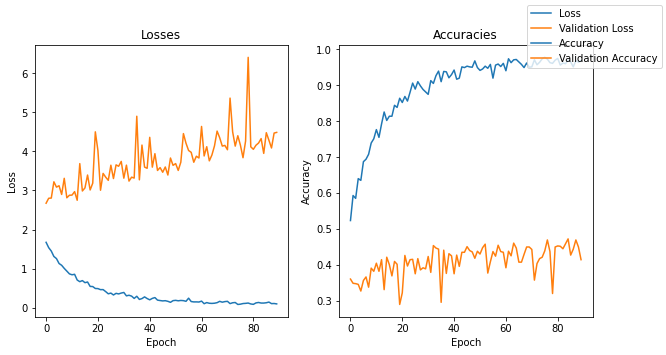

In [4]:
h = {'loss': [1.67254, 1.536018, 1.449004, 1.311106, 1.256534, 1.130805, 1.085062, 1.006073, 0.936159, 0.865544, 0.842623, 0.854457, 0.708334, 0.665865, 0.69387, 0.640505, 0.657618, 0.544409, 0.541253, 0.491566, 0.488808, 0.462, 0.46348, 0.411918, 0.355467, 0.37422, 0.325767, 0.367512, 0.352847, 0.374566, 0.39005, 0.303514, 0.318792, 0.296597, 0.237769, 0.292828, 0.212118, 0.233557, 0.276855, 0.234777, 0.201821, 0.238495, 0.259379, 0.194311, 0.183346, 0.174067, 0.17949, 0.163581, 0.137731, 0.180888, 0.188545, 0.176982, 0.185652, 0.180884, 0.164057, 0.24385, 0.157894, 0.148076, 0.148853, 0.145451, 0.168754, 0.102854, 0.131233, 0.113707, 0.110236, 0.115138, 0.129029, 0.162792, 0.141434, 0.156237, 0.163493, 0.104931, 0.12666, 0.133191, 0.083581, 0.090684, 0.106536, 0.111435, 0.119354, 0.096145, 0.086234, 0.12272, 0.13407, 0.119272, 0.119276, 0.126905, 0.144075, 0.104632, 0.107659, 0.09779], 'accuracy': [0.523529, 0.593137, 0.585294, 0.640196, 0.635294, 0.687255, 0.694118, 0.707843, 0.739216, 0.75098, 0.776471, 0.754902, 0.792157, 0.82549, 0.801961, 0.813725, 0.813725, 0.844118, 0.838235, 0.863725, 0.851961, 0.868627, 0.855882, 0.880392, 0.905882, 0.889216, 0.909804, 0.898039, 0.888235, 0.881373, 0.87451, 0.912745, 0.904902, 0.926471, 0.939216, 0.909804, 0.938235, 0.937255, 0.920588, 0.929412, 0.942157, 0.916667, 0.919608, 0.95098, 0.94902, 0.952941, 0.95098, 0.95, 0.967647, 0.94902, 0.941176, 0.945098, 0.952941, 0.947059, 0.957843, 0.919608, 0.955882, 0.958824, 0.951961, 0.960784, 0.940196, 0.973529, 0.962745, 0.970588, 0.971569, 0.964706, 0.957843, 0.94902, 0.961765, 0.95, 0.95098, 0.970588, 0.956863, 0.963726, 0.973529, 0.977451, 0.972549, 0.962745, 0.960784, 0.969608, 0.97451, 0.955882, 0.961765, 0.959804, 0.969608, 0.964706, 0.95098, 0.968627, 0.963726, 0.968627], 'val_loss': [2.673045, 2.799534, 2.804461, 3.220624, 3.084678, 3.119861, 2.897151, 3.309521, 2.812034, 2.877056, 2.880153, 2.969707, 2.748088, 3.685709, 2.985742, 3.064952, 3.393449, 3.011624, 3.185768, 4.498503, 4.021383, 3.004867, 3.435597, 3.33893, 3.258373, 3.645299, 3.303856, 3.653669, 3.618104, 3.741951, 3.313261, 3.646464, 3.238795, 3.339277, 3.315764, 4.89736, 3.271372, 4.159832, 3.596826, 3.566104, 4.357779, 3.595553, 3.940002, 3.510873, 3.583706, 3.465299, 3.599335, 3.393842, 3.829074, 3.64176, 3.686345, 3.511637, 3.723093, 4.453462, 4.206367, 4.02152, 3.974193, 3.720849, 3.87492, 3.829152, 4.636121, 3.881603, 4.118242, 3.756564, 3.906335, 4.141385, 4.517525, 4.347589, 4.134023, 4.151392, 4.040612, 5.361506, 4.497697, 4.133408, 4.398748, 4.157619, 3.836696, 4.264988, 6.40362, 4.115508, 4.051456, 4.155097, 4.211722, 4.325206, 3.947439, 4.476333, 4.284581, 4.085442, 4.466598, 4.484261], 'val_accuracy': [0.360784, 0.34902, 0.348039, 0.346078, 0.327451, 0.356863, 0.366667, 0.338235, 0.391176, 0.382353, 0.404902, 0.382353, 0.414706, 0.331373, 0.421569, 0.40098, 0.369608, 0.409804, 0.401961, 0.290196, 0.322549, 0.426471, 0.397059, 0.414706, 0.415686, 0.37549, 0.417647, 0.386275, 0.392157, 0.389216, 0.423529, 0.379412, 0.453922, 0.447059, 0.444118, 0.296078, 0.441176, 0.376471, 0.431373, 0.42549, 0.37549, 0.427451, 0.396078, 0.435294, 0.435294, 0.45098, 0.440196, 0.436274, 0.418627, 0.438235, 0.430392, 0.448039, 0.457843, 0.377451, 0.408824, 0.437255, 0.42451, 0.454902, 0.437255, 0.435294, 0.392157, 0.438235, 0.42549, 0.460784, 0.447059, 0.407843, 0.407843, 0.429412, 0.45, 0.45, 0.443137, 0.357843, 0.403922, 0.417647, 0.421569, 0.439216, 0.469608, 0.437255, 0.320588, 0.45, 0.452941, 0.451961, 0.445098, 0.458824, 0.472549, 0.427451, 0.444118, 0.469608, 0.45, 0.414706]}

run_summary(h)

## Model 45
* Augmentations:
  * RandomFlip('horizontal')
  * RandomRotation(0.1)
* depth=4, skips=[], skip_start_depth=2
* heat=1, chill=1, reheat=0, min_channels=32, max_channels=256
* MaxPool(2) follows both heat and chill convs.
* Two concatenated backbones are fed to the final dense layer.
* Hyper Parameter Search:
  * lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
  * bs = hp.Choice('bs', [8, 16, 24, 32])

0.952941 | 0.417647


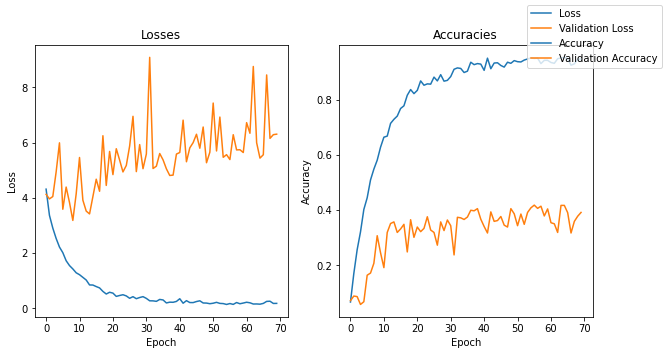

In [5]:
h = {'loss': [4.314303, 3.367166, 2.906756, 2.53095, 2.217982, 2.01541, 1.723469, 1.548172, 1.426322, 1.287134, 1.217588, 1.121726, 1.025371, 0.84686, 0.843544, 0.78831, 0.739147, 0.613079, 0.518689, 0.581846, 0.550969, 0.432706, 0.465156, 0.49238, 0.449513, 0.363599, 0.422518, 0.349302, 0.391791, 0.423227, 0.360038, 0.272715, 0.270796, 0.253601, 0.322672, 0.303596, 0.195575, 0.223343, 0.219102, 0.250422, 0.347801, 0.185523, 0.277786, 0.209858, 0.208096, 0.246394, 0.272905, 0.194126, 0.190548, 0.168, 0.185514, 0.217146, 0.179057, 0.172315, 0.141059, 0.173667, 0.143443, 0.210078, 0.166351, 0.191673, 0.220688, 0.200915, 0.15654, 0.158912, 0.150909, 0.178681, 0.251401, 0.257636, 0.177107, 0.179776], 'accuracy': [0.066667, 0.169608, 0.255882, 0.320588, 0.401961, 0.444118, 0.508824, 0.548039, 0.580392, 0.627451, 0.663725, 0.667647, 0.713726, 0.728431, 0.740196, 0.767647, 0.777451, 0.815686, 0.836275, 0.821569, 0.833333, 0.867647, 0.851961, 0.856863, 0.855882, 0.881373, 0.867647, 0.890196, 0.866667, 0.869608, 0.883333, 0.909804, 0.914706, 0.912745, 0.898039, 0.902941, 0.935294, 0.926471, 0.930392, 0.928431, 0.905882, 0.95, 0.911765, 0.932353, 0.933333, 0.923529, 0.917647, 0.935294, 0.931373, 0.941176, 0.937255, 0.936275, 0.943137, 0.947059, 0.95098, 0.94902, 0.95, 0.930392, 0.942157, 0.942157, 0.934314, 0.931373, 0.948039, 0.95098, 0.952941, 0.948039, 0.92451, 0.929412, 0.946078, 0.947059], 'val_loss': [4.125989, 3.961477, 4.04691, 4.935462, 5.991018, 3.586933, 4.389844, 3.83041, 3.182531, 4.142656, 5.459758, 3.916063, 3.520544, 3.41761, 4.044038, 4.674182, 4.237787, 6.247721, 4.449438, 5.678901, 4.840448, 5.777426, 5.367236, 4.937313, 5.172246, 5.875871, 6.950348, 4.949046, 5.927217, 5.054491, 5.587918, 9.084794, 5.061139, 5.146191, 5.603936, 5.373954, 5.048984, 4.809328, 4.822338, 5.583724, 5.641, 6.811876, 5.305921, 5.80857, 5.998223, 6.30148, 5.795619, 6.563094, 5.270943, 5.650896, 7.430711, 5.696996, 6.923491, 5.467106, 5.562344, 5.385721, 6.284963, 5.73469, 5.74063, 5.639729, 6.721549, 6.337252, 8.754416, 5.994981, 5.436954, 5.560372, 8.448232, 6.152016, 6.286388, 6.304527], 'val_accuracy': [0.071569, 0.088235, 0.086275, 0.057843, 0.067647, 0.163725, 0.171569, 0.206863, 0.306863, 0.245098, 0.191176, 0.318627, 0.35098, 0.356863, 0.318627, 0.331373, 0.348039, 0.248039, 0.364706, 0.30098, 0.338235, 0.321569, 0.333333, 0.37549, 0.327451, 0.318627, 0.272549, 0.356863, 0.32549, 0.363725, 0.343137, 0.237255, 0.373529, 0.371569, 0.365686, 0.37451, 0.39902, 0.397059, 0.404902, 0.366667, 0.340196, 0.316667, 0.393137, 0.358824, 0.361765, 0.376471, 0.345098, 0.338235, 0.404902, 0.386275, 0.343137, 0.385294, 0.348039, 0.391176, 0.407843, 0.417647, 0.405882, 0.413725, 0.378431, 0.403922, 0.353922, 0.35, 0.318627, 0.416667, 0.416667, 0.390196, 0.316667, 0.358824, 0.377451, 0.391176]}

run_summary(h)

## Model 48
* Augmentations:
  * RandomFlip('horizontal')
  * RandomRotation(0.1)
* depth=4, skips=[], skip_start_depth=2
* heat=1, chill=1, reheat=0, min_channels=32, max_channels=256
* MaxPool(2) follows both heat and chill convs.
* 3-way softmax split. Each split predicts N_CLASSES//3 + 1 (Not in this set) classes.
* Hyper Parameters:
  * lr = 0.00088
  * bs = 16

dense_1:  0.962745 | 0.743137
dense_3:  0.966667 | 0.753922
dense_5:  0.956863 | 0.702941


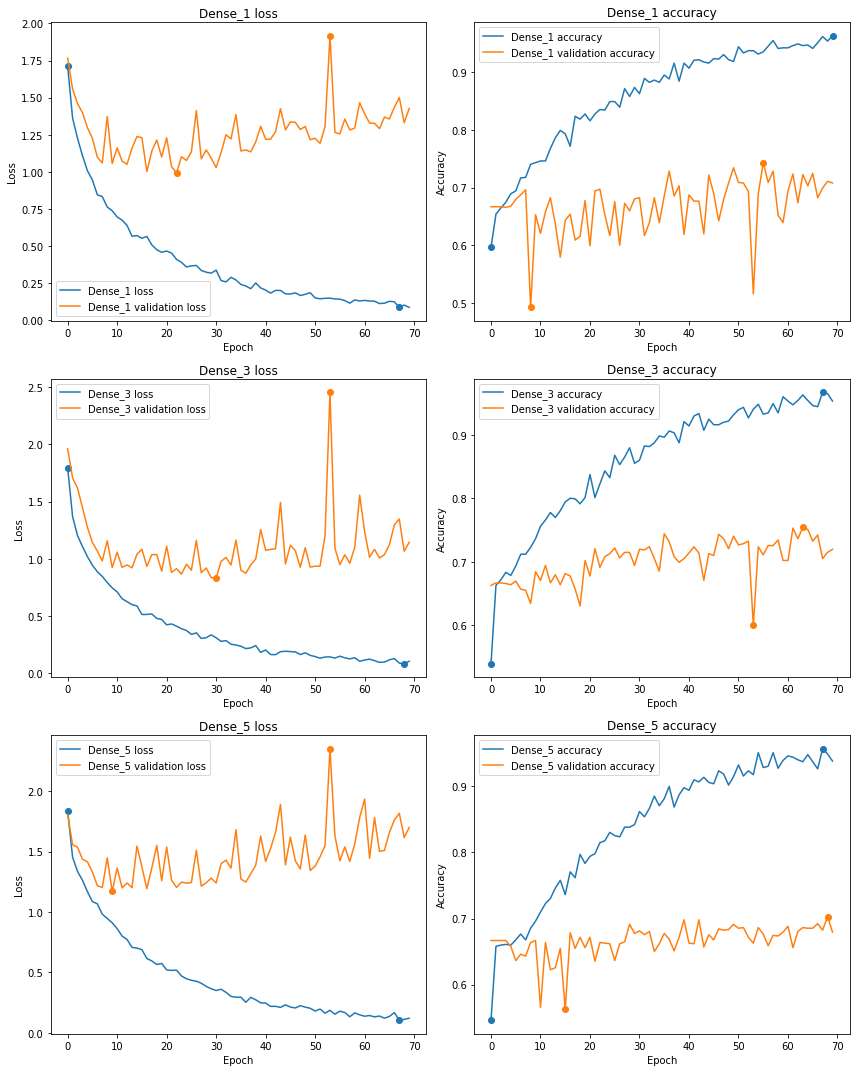

In [33]:
h = {'loss': [5.346158, 4.184424, 3.763664, 3.478731, 3.195165, 2.976148, 2.800878, 2.661108, 2.503042, 2.395636, 2.270025, 2.127022, 2.038327, 1.873658, 1.860716, 1.754333, 1.694784, 1.621726, 1.520804, 1.503223, 1.410675, 1.40064, 1.34047, 1.249749, 1.18058, 1.141251, 1.150036, 1.050106, 1.018963, 1.017839, 0.998005, 0.906896, 0.879516, 0.844111, 0.813577, 0.772521, 0.699811, 0.727605, 0.766669, 0.648272, 0.652901, 0.565532, 0.582715, 0.600369, 0.602107, 0.579311, 0.577219, 0.555647, 0.566425, 0.545423, 0.476531, 0.473024, 0.452105, 0.478629, 0.430424, 0.470725, 0.43517, 0.37361, 0.437826, 0.383117, 0.387208, 0.396353, 0.370834, 0.346581, 0.33419, 0.381106, 0.419814, 0.279864, 0.295467, 0.31282], 'dense_1_loss': [1.710097, 1.361793, 1.225341, 1.108472, 1.007179, 0.945101, 0.845529, 0.833447, 0.763043, 0.737904, 0.696036, 0.675042, 0.639284, 0.566597, 0.570456, 0.552682, 0.56492, 0.508005, 0.47567, 0.45805, 0.466506, 0.452704, 0.410226, 0.389913, 0.359315, 0.366496, 0.369447, 0.33557, 0.323924, 0.31763, 0.33794, 0.267728, 0.258621, 0.289442, 0.271575, 0.241666, 0.231132, 0.212758, 0.251525, 0.217927, 0.203386, 0.183008, 0.201234, 0.201004, 0.178405, 0.176818, 0.184775, 0.167151, 0.174698, 0.18575, 0.150474, 0.144803, 0.148083, 0.149065, 0.143794, 0.142401, 0.132463, 0.115012, 0.137258, 0.129621, 0.134226, 0.129879, 0.128894, 0.112547, 0.115115, 0.127931, 0.124112, 0.08656, 0.102163, 0.086955], 'dense_3_loss': [1.796512, 1.368429, 1.202268, 1.107451, 1.018944, 0.944121, 0.887292, 0.845782, 0.792933, 0.746431, 0.711104, 0.651007, 0.625963, 0.599311, 0.588447, 0.512959, 0.513896, 0.518243, 0.479313, 0.470105, 0.422788, 0.430593, 0.411064, 0.389041, 0.373084, 0.339454, 0.352869, 0.303812, 0.310484, 0.335183, 0.309456, 0.278084, 0.285325, 0.25284, 0.24694, 0.235503, 0.215138, 0.221211, 0.241349, 0.181895, 0.202803, 0.16332, 0.161858, 0.18835, 0.191919, 0.188786, 0.186159, 0.163469, 0.178567, 0.155958, 0.145308, 0.131218, 0.141326, 0.142715, 0.132077, 0.148688, 0.134484, 0.125277, 0.135122, 0.104147, 0.11513, 0.122915, 0.109557, 0.094702, 0.09729, 0.117347, 0.127867, 0.088627, 0.081926, 0.104592], 'dense_5_loss': [1.839549, 1.454202, 1.336055, 1.262809, 1.169042, 1.086926, 1.068057, 0.981879, 0.947065, 0.911301, 0.862886, 0.800972, 0.773079, 0.70775, 0.701813, 0.688691, 0.615967, 0.595478, 0.565821, 0.575068, 0.521381, 0.517343, 0.519181, 0.470794, 0.448182, 0.435301, 0.42772, 0.410724, 0.384555, 0.365026, 0.350609, 0.361084, 0.33557, 0.301829, 0.295063, 0.295352, 0.253541, 0.293635, 0.273795, 0.248451, 0.246712, 0.219204, 0.219624, 0.211015, 0.231783, 0.213707, 0.206285, 0.225027, 0.213161, 0.203715, 0.180749, 0.197003, 0.162696, 0.18685, 0.154552, 0.179637, 0.168224, 0.133321, 0.165445, 0.149349, 0.137851, 0.143559, 0.132383, 0.139333, 0.121785, 0.135828, 0.167836, 0.104677, 0.111378, 0.121274], 'dense_1_accuracy': [0.596078, 0.653922, 0.664706, 0.67451, 0.689216, 0.694118, 0.716667, 0.717647, 0.740196, 0.743137, 0.746078, 0.746078, 0.767647, 0.786274, 0.79902, 0.793137, 0.771569, 0.823529, 0.818627, 0.827451, 0.815686, 0.827451, 0.835294, 0.834314, 0.84902, 0.84902, 0.839216, 0.871569, 0.857843, 0.873529, 0.862745, 0.889216, 0.882353, 0.886275, 0.882353, 0.895098, 0.888235, 0.915686, 0.884314, 0.915686, 0.906863, 0.920588, 0.921569, 0.917647, 0.915686, 0.923529, 0.922549, 0.930392, 0.921569, 0.918627, 0.944118, 0.933333, 0.937255, 0.937255, 0.931373, 0.935294, 0.945098, 0.954902, 0.941176, 0.942157, 0.942157, 0.946078, 0.94902, 0.946078, 0.947059, 0.941176, 0.95098, 0.961765, 0.953922, 0.962745], 'dense_3_accuracy': [0.539216, 0.662745, 0.671569, 0.683333, 0.678431, 0.693137, 0.711765, 0.711765, 0.722549, 0.736274, 0.755882, 0.765686, 0.777451, 0.769608, 0.780392, 0.794118, 0.8, 0.79902, 0.791176, 0.80098, 0.837255, 0.80098, 0.822549, 0.843137, 0.832353, 0.867647, 0.852941, 0.864706, 0.879412, 0.854902, 0.859804, 0.882353, 0.881373, 0.887255, 0.898039, 0.896078, 0.905882, 0.902941, 0.887255, 0.920588, 0.913725, 0.929412, 0.933333, 0.906863, 0.92451, 0.915686, 0.915686, 0.919608, 0.921569, 0.931373, 0.939216, 0.943137, 0.926471, 0.940196, 0.948039, 0.932353, 0.934314, 0.94902, 0.934314, 0.959804, 0.952941, 0.947059, 0.953922, 0.962745, 0.953922, 0.946078, 0.944118, 0.966667, 0.964706, 0.952941], 'dense_5_accuracy': [0.546078, 0.657843, 0.659804, 0.660784, 0.659804, 0.667647, 0.676471, 0.667647, 0.685294, 0.696078, 0.709804, 0.722549, 0.730392, 0.746078, 0.757843, 0.736274, 0.770588, 0.761765, 0.797059, 0.783333, 0.794118, 0.798039, 0.814706, 0.817647, 0.830392, 0.82549, 0.823529, 0.838235, 0.838235, 0.842157, 0.861765, 0.853922, 0.866667, 0.885294, 0.870588, 0.881373, 0.9, 0.868627, 0.887255, 0.898039, 0.894118, 0.909804, 0.906863, 0.913725, 0.905882, 0.903922, 0.923529, 0.918627, 0.901961, 0.914706, 0.932353, 0.915686, 0.923529, 0.917647, 0.95098, 0.928431, 0.930392, 0.95098, 0.927451, 0.939216, 0.946078, 0.944118, 0.940196, 0.937255, 0.948039, 0.937255, 0.926471, 0.956863, 0.94902, 0.938235], 'val_loss': [5.534931, 4.823612, 4.613707, 4.281785, 3.987986, 3.700206, 3.385149, 3.244811, 3.980255, 3.150558, 3.584919, 3.198199, 3.239033, 3.282679, 3.824734, 3.687649, 3.128619, 3.540332, 3.804451, 3.252348, 3.879119, 3.179018, 3.1117, 3.216267, 3.26964, 3.279005, 4.085802, 3.181054, 3.310695, 3.209175, 3.101251, 3.509228, 3.692784, 3.530718, 4.230928, 3.316296, 3.26941, 3.400658, 3.587644, 4.192941, 3.713123, 3.829668, 4.018252, 4.810053, 3.629679, 4.075984, 3.83009, 3.568754, 4.040294, 3.48871, 3.542723, 3.585674, 4.057755, 6.723003, 3.98923, 3.628314, 3.931558, 3.661902, 3.957628, 4.80686, 4.562891, 3.786665, 4.193353, 3.801378, 3.915767, 4.138985, 4.491748, 4.66614, 4.014369, 4.271845], 'val_dense_1_loss': [1.765918, 1.55816, 1.459714, 1.397792, 1.297169, 1.225758, 1.098974, 1.060304, 1.372833, 1.056073, 1.162183, 1.072237, 1.051039, 1.159589, 1.238535, 1.23018, 1.001279, 1.13902, 1.214994, 1.10038, 1.229891, 1.033468, 0.993656, 1.102087, 1.076891, 1.134256, 1.412687, 1.087393, 1.148268, 1.092294, 1.029245, 1.130691, 1.250461, 1.221921, 1.3855, 1.140956, 1.147693, 1.134771, 1.201552, 1.307088, 1.220264, 1.220098, 1.270345, 1.425894, 1.28313, 1.336563, 1.333731, 1.285394, 1.305975, 1.216475, 1.226397, 1.191818, 1.304166, 1.915651, 1.265884, 1.255715, 1.355998, 1.282467, 1.294788, 1.466191, 1.390478, 1.329304, 1.327685, 1.290808, 1.369572, 1.356243, 1.434429, 1.500826, 1.331047, 1.426957], 'val_dense_3_loss': [1.962113, 1.707885, 1.617635, 1.44712, 1.275029, 1.143687, 1.067724, 0.981913, 1.158682, 0.924139, 1.05801, 0.925779, 0.946725, 0.921386, 1.040316, 1.083989, 0.933482, 1.036145, 1.037739, 0.892595, 1.110026, 0.881378, 0.914105, 0.866205, 0.953389, 0.900836, 1.161578, 0.879097, 0.919729, 0.835534, 0.831008, 0.977857, 1.012332, 0.946017, 1.163451, 0.901101, 0.873925, 0.947711, 0.998591, 1.256054, 1.073965, 1.082568, 1.088384, 1.493188, 0.95548, 1.119383, 1.071973, 0.926528, 1.096977, 0.927598, 0.935681, 0.936068, 1.203477, 2.455703, 1.092896, 0.948345, 1.036239, 0.961555, 1.099196, 1.55708, 1.237774, 1.013488, 1.082954, 1.007602, 1.036444, 1.123635, 1.296399, 1.347772, 1.066625, 1.144192], 'val_dense_5_loss': [1.806901, 1.557568, 1.536358, 1.436873, 1.415787, 1.330762, 1.218452, 1.202595, 1.44874, 1.170346, 1.364726, 1.200183, 1.24127, 1.201704, 1.545883, 1.373479, 1.193859, 1.365166, 1.551718, 1.259372, 1.539203, 1.26417, 1.203939, 1.247975, 1.23936, 1.243913, 1.511537, 1.214564, 1.242698, 1.281347, 1.240997, 1.400681, 1.429992, 1.36278, 1.681977, 1.27424, 1.247792, 1.318176, 1.387502, 1.6298, 1.418893, 1.527001, 1.659523, 1.890971, 1.391069, 1.620037, 1.424386, 1.356831, 1.637341, 1.344638, 1.380645, 1.457788, 1.550113, 2.351648, 1.63045, 1.424256, 1.539322, 1.41788, 1.563644, 1.783589, 1.934638, 1.443873, 1.782715, 1.502968, 1.509751, 1.659106, 1.760921, 1.817542, 1.616697, 1.700696], 'val_dense_1_accuracy': [0.666667, 0.666667, 0.666667, 0.665686, 0.667647, 0.679412, 0.687255, 0.696078, 0.492157, 0.652941, 0.620588, 0.657843, 0.682353, 0.636275, 0.579412, 0.643137, 0.653922, 0.608824, 0.615686, 0.677451, 0.59902, 0.694118, 0.697059, 0.652941, 0.616667, 0.67549, 0.6, 0.672549, 0.659804, 0.680392, 0.682353, 0.616667, 0.639216, 0.682353, 0.639216, 0.685294, 0.728431, 0.685294, 0.702941, 0.618627, 0.687255, 0.676471, 0.676471, 0.619608, 0.721569, 0.689216, 0.642157, 0.679412, 0.707843, 0.734314, 0.708824, 0.707843, 0.693137, 0.515686, 0.689216, 0.743137, 0.708824, 0.728431, 0.651961, 0.639216, 0.694118, 0.723529, 0.673529, 0.722549, 0.702941, 0.72451, 0.682353, 0.69902, 0.710784, 0.707843], 'val_dense_3_accuracy': [0.662745, 0.666667, 0.666667, 0.665686, 0.663725, 0.669608, 0.656863, 0.654902, 0.634314, 0.684314, 0.670588, 0.694118, 0.666667, 0.679412, 0.663725, 0.681373, 0.677451, 0.656863, 0.630392, 0.701961, 0.677451, 0.720588, 0.691176, 0.707843, 0.712745, 0.721569, 0.705882, 0.714706, 0.714706, 0.694118, 0.719608, 0.718627, 0.723529, 0.704902, 0.685294, 0.744118, 0.731373, 0.707843, 0.69902, 0.704902, 0.713726, 0.723529, 0.713726, 0.670588, 0.712745, 0.709804, 0.743137, 0.736274, 0.720588, 0.740196, 0.726471, 0.728431, 0.732353, 0.6, 0.723529, 0.710784, 0.72549, 0.72549, 0.734314, 0.701961, 0.701961, 0.752941, 0.736274, 0.753922, 0.75098, 0.732353, 0.742157, 0.704902, 0.714706, 0.719608], 'val_dense_5_accuracy': [0.666667, 0.666667, 0.666667, 0.666667, 0.657843, 0.636275, 0.646078, 0.643137, 0.663725, 0.666667, 0.565686, 0.663725, 0.622549, 0.62549, 0.654902, 0.562745, 0.678431, 0.654902, 0.671569, 0.655882, 0.671569, 0.635294, 0.663725, 0.662745, 0.661765, 0.636275, 0.661765, 0.664706, 0.691176, 0.677451, 0.681373, 0.67549, 0.680392, 0.65, 0.661765, 0.677451, 0.668627, 0.65098, 0.671569, 0.698039, 0.662745, 0.661765, 0.698039, 0.656863, 0.67549, 0.667647, 0.684314, 0.682353, 0.683333, 0.691176, 0.685294, 0.686275, 0.671569, 0.662745, 0.686275, 0.676471, 0.658824, 0.67451, 0.673529, 0.679412, 0.688235, 0.655882, 0.680392, 0.686275, 0.685294, 0.685294, 0.692157, 0.682353, 0.702941, 0.679412]}

def metric_name(output_name, set_name, metric_name):
    parts = [set_name, output_name, metric_name]
    name = reduce(lambda x, y: x + '_' + y if x else y , parts, '')
    return name

def plot_history(h, outputs=['']):
    fig, axes = plt.subplots(len(outputs), 2, figsize=(12, 5*len(outputs)), facecolor='w', edgecolor='k')

    def plot(ax, output, metric):
        label = '{} {}'.format(output, metric).strip().capitalize()
        data = h[metric_name(output, '', metric)]
        ax.plot(data, label=label)
        ax.scatter([np.argmax(data), np.argmin(data)], [max(data), min(data)])

        vlabel = '{} validation {}'.format(output, metric).strip().capitalize()
        data = h[metric_name(output, 'val', metric)]
        ax.plot(data, label=vlabel)
        ax.scatter([np.argmax(data), np.argmin(data)], [max(data), min(data)])

        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric.capitalize())
        ax.set_title('{} {}'.format(output, metric).strip().capitalize())
        ax.legend()

    for idx,o in enumerate(outputs):
        if len(outputs) == 1:
            plot(axes[0], o, 'loss')
            plot(axes[1], o, 'accuracy')
        else:
            plot(axes[idx, 0], o, 'loss')
            plot(axes[idx, 1], o, 'accuracy')

    plt.tight_layout()
    # fig.legend()

def run_summary(h, outputs=['']):
    plot_history(h, outputs)
    for o in outputs:
        print(o + ': ' if o else '', max(h[metric_name(o, '', 'accuracy')]), '|', max(h[metric_name(o, 'val', 'accuracy')]))

outputs = ['dense_1', 'dense_3', 'dense_5']
run_summary(h, outputs)